In [110]:
import sys, site, platform
print("Python:", sys.version)
print("Exe   :", sys.executable)   # <-- este é o Python do seu kernel
print("Site  :", site.getsitepackages())


Python: 3.10.12 (main, Aug 15 2025, 14:32:43) [GCC 11.4.0]
Exe   : /home/joao/Desktop/7o-semestre/direito/clinicas-2/venv/bin/python
Site  : ['/home/joao/Desktop/7o-semestre/direito/clinicas-2/venv/lib/python3.10/site-packages', '/home/joao/Desktop/7o-semestre/direito/clinicas-2/venv/local/lib/python3.10/dist-packages', '/home/joao/Desktop/7o-semestre/direito/clinicas-2/venv/lib/python3/dist-packages', '/home/joao/Desktop/7o-semestre/direito/clinicas-2/venv/lib/python3.10/dist-packages']


In [111]:
import sys
!{sys.executable} -m pip install -U pip setuptools wheel
!{sys.executable} -m pip install -U statsmodels
!{sys.executable} -m pip install -U scikit-learn


In [112]:
import statsmodels, statsmodels.api as sm
import sklearn
print("statsmodels:", statsmodels.__version__)
print("sklearn    :", sklearn.__version__)


statsmodels: 0.14.5
sklearn    : 1.7.2


# Entrega 6 - Extração de Dados Estruturados
## Ciência de Dados Aplicada ao Direito II

**Objetivo:** Extrair informações estruturadas dos casos de crédito consignado (já filtrados pela Entrega 5)

### Fluxo de Trabalho:
1. **Entrega 5** → Filtra casos de crédito consignado do dataset completo
2. **Entrega 6** → Extrai informações detalhadas APENAS dos casos filtrados

### Campos Extraídos:
- `cd_atendimento`: ID do caso
- `nome_empresa`: Nome da empresa no polo passivo
- `cnpj`: CNPJ válido (14 dígitos)
- `valor_causa`: Valor da causa em reais
- `dt_distribuicao`: Data de distribuição (YYYY-MM-DD)
- `tipo_vara`: JE (Juizado Especial) ou G1 (Vara Comum)
- `uf`: Unidade Federativa

## Sumário Executivo

### Como Usar Este Notebook

1. **Instale as dependências** (célula 2 - opcional se já tiver instalado)
2. **Execute todas as células em ordem** 
3. **Resultado:** Arquivo `output.xlsx` com 7 colunas (requisito do roteiro)
4. **Opcional:** Execute seção 10.1 para gerar `output_expandido.xlsx` com análise de danos morais/materiais

### Entrada de Dados

O notebook carrega automaticamente `./dataset_filtrado.xlsx` (casos de crédito consignado já filtrados).
Se não existir, tenta fallbacks alternativos.

### Saídas

- `output.xlsx`: 7 colunas do roteiro oficial
- `output_expandido.xlsx`: 13 colunas incluindo danos morais/materiais (opcional)

---

In [113]:
# Imports
import re
import unicodedata
import pandas as pd
import numpy as np
from typing import List, Tuple, Dict
from unidecode import unidecode
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
import statsmodels.api as sm

print("Bibliotecas importadas com sucesso")

Bibliotecas importadas com sucesso


In [114]:
# (opcional) instalar deps no ambiente atual, se faltar algo
# !pip install -q "pandas>=2.0" "numpy>=1.24" "openpyxl>=3.1" "jupyter>=1.0" \
#                "unidecode>=1.3" "matplotlib>=3.8" "seaborn>=0.13"

## 1. Carregamento de Dados

Carrega o dataset completo e filtra apenas os casos de crédito consignado identificados pela Entrega 5.

*Essa parte do código é somente para aplicar o filtro da entrega 5 no db inteiro, por isso está comentada. O `dataset_filtrado.xlsx` é o produto disso.*

## 2. Funções Auxiliares

Funções de limpeza e normalização de texto.

In [115]:
# LINHA DE SELEÇÃO DO INPUT

print("="*80)
print("CARREGAMENTO DE DADOS")
print("="*80)

# Prioriza dataset_filtrado.xlsx no mesmo diretório do notebook
try:
    # LINHA DE SELEÇÃO DO INPUT
    df = pd.read_excel("./dataset_filtrado.xlsx")
    print(f"\nDataset carregado: ./dataset_filtrado.xlsx")
    print(f"Dimensões: {df.shape[0]} linhas x {df.shape[1]} colunas")
    print("Dataset pronto para extração!")
    
except FileNotFoundError:
    # Fallback: tenta no diretório pai
    try:
        df = pd.read_excel("../dataset_filtrado.xlsx")
        print("Usando fallback: ../dataset_filtrado.xlsx")
        print(f"Dimensões: {df.shape[0]} linhas x {df.shape[1]} colunas")
        
    except FileNotFoundError:
        # Fallback final: tenta carregar do dataset original com filtro da Entrega 5
        print("\nAVISO: dataset_filtrado.xlsx não encontrado!")
        print("Tentando carregar e filtrar dataset original...")
        
        try:
            INPUT_CSV = "../data/dataset_clinica20252.csv"
            df_completo = pd.read_csv(INPUT_CSV, sep="|")
            
            ENTREGA5_OUTPUT = "../entrega5/output.xlsx"
            df_filtrados = pd.read_excel(ENTREGA5_OUTPUT)
            
            cd_list = df_filtrados['cd_atendimento'].astype(str).tolist()
            df = df_completo[df_completo['cd_atendimento'].astype(str).isin(cd_list)].copy()
            
            print(f"Dataset filtrado dinamicamente: {df.shape[0]} linhas x {df.shape[1]} colunas")
            
        except Exception as e:
            print(f"\nERRO: Não foi possível carregar nenhum dataset!")
            print(f"Detalhes: {e}")
            raise

print("="*80)

CARREGAMENTO DE DADOS

Dataset carregado: ./dataset_filtrado.xlsx
Dimensões: 8557 linhas x 6 colunas
Dataset pronto para extração!

Dataset carregado: ./dataset_filtrado.xlsx
Dimensões: 8557 linhas x 6 colunas
Dataset pronto para extração!


### Dataset Filtrado Salvo

O arquivo `dataset_filtrado.xlsx` contém:
- **TODOS os casos** de crédito consignado identificados pela Entrega 5
- **TODAS as colunas** originais do dataset
- Pronto para análises futuras (sem precisar reprocessar o filtro)

Este arquivo será a base para todas as próximas análises!

In [116]:
def strip_accents(s: str) -> str:
    """Remove acentos de uma string."""
    if not isinstance(s, str): 
        return ""
    return "".join(c for c in unicodedata.normalize("NFD", s) 
                   if unicodedata.category(c) != "Mn")

def clean_text(s: str) -> str:
    """Limpa e normaliza texto."""
    s = (s or "").replace("\n", " ")
    return re.sub(r"\s+", " ", s).strip()

def limpar_para_excel(texto):
    """Remove caracteres de controle que causam problemas no Excel."""
    if not isinstance(texto, str):
        return texto
    # Remove caracteres de controle (0x00-0x1F exceto tab, newline, carriage return)
    return re.sub(r'[\x00-\x08\x0B-\x0C\x0E-\x1F]', '', texto)

# Constantes
UF_LIST = set("AC AL AP AM BA CE DF ES GO MA MT MS MG PA PB PR PE PI RJ RN RS RO RR SC SP SE TO".split())

print("✓ Funções auxiliares definidas")

✓ Funções auxiliares definidas


## 3. Extração de CNPJ

Validação de CNPJs e busca com validação de dígitos verificadores.

In [117]:
def cnpj_is_valid(cnpj_digits: str) -> bool:
    """Valida dígitos verificadores do CNPJ (14 dígitos)."""
    if len(cnpj_digits) != 14 or len(set(cnpj_digits)) == 1:
        return False
    
    nums = [int(x) for x in cnpj_digits]
    
    # Valida os dois dígitos verificadores
    for i in [12, 13]:
        pesos = [5,4,3,2,9,8,7,6,5,4,3,2] if i == 12 else [6,5,4,3,2,9,8,7,6,5,4,3,2]
        soma = sum(a * b for a, b in zip(nums[:i], pesos))
        dig = 11 - (soma % 11)
        dig = 0 if dig >= 10 else dig
        if nums[i] != dig: 
            return False
    
    return True


def find_cnpjs_pos(text: str) -> List[Tuple[str, int]]:
    """Encontra CNPJs válidos no texto com suas posições."""
    out = []
    pattern = r"\b\d{2}\.?\d{3}\.?\d{3}/?\d{4}-?\d{2}\b"
    
    for m in re.finditer(pattern, text):
        digits = re.sub(r"\D", "", m.group(0))
        if len(digits) == 14 and cnpj_is_valid(digits):
            out.append((digits, m.start()))
    
    return out


print("✓ Funções de validação de CNPJ definidas")

✓ Funções de validação de CNPJ definidas


## 4. Extração de Nome de Empresa

Estratégia simplificada sem regex complexa:
1. Procura "BANCO" ou sufixo societário (S.A, LTDA, etc.)
2. Captura APENAS palavras com letras
3. Para quando encontrar: números, CNPJ, endereço, etc.

In [118]:
def extract_company_name_simple(text: str) -> Tuple[str, int, int]:
    """
    Extrai nome da empresa de forma simplificada.
    
    Retorna: (nome_empresa, posicao_inicio, posicao_fim) ou ("vazio", -1, -1)
    """
    T = clean_text(text).upper()
    
    # Palavras que indicam FIM do nome da empresa
    STOP_WORDS = {
        'INSCRITO', 'INSCRITA', 'CNPJ', 'CPF', 'SITO', 'SITA',
        'ENDERECO', 'ENDEREÇO', 'RUA', 'AVENIDA', 'PRACA', 'PRAÇA',
        'NUMERO', 'NÚMERO', 'CEP', 'BAIRRO', 'CIDADE', 'ESTADO',
        'REPRESENTADO', 'REPRESENTADA', 'ADVOGADO', 'ADVOGADA',
        'QUALIFICADO', 'QUALIFICADA', 'BRASILEIRO', 'BRASILEIRA'
    }
    
    # Sufixos societários válidos
    SUFFIXES = ['S.A.', 'S.A', 'S/A', 'LTDA', 'LTDA.', 'EIRELI', 'ME', 'EPP']
    
    # Procura "BANCO" no texto
    banco_pos = T.find('BANCO')
    if banco_pos == -1:
        # Se não tem BANCO, procura por sufixo societário
        for suffix in SUFFIXES:
            if suffix in T:
                suffix_pos = T.find(suffix)
                start = max(0, suffix_pos - 100)
                trecho = T[start:suffix_pos + len(suffix)]
                words = trecho.split()[-6:]
                nome = ' '.join(words).strip()
                return (nome, start, suffix_pos + len(suffix))
        
        return ("vazio", -1, -1)
    
    # A partir de "BANCO", captura palavras seguintes
    start_pos = banco_pos
    trecho = T[banco_pos:]
    palavras = trecho.split()
    
    nome_parts = []
    last_pos = banco_pos
    
    for i, palavra in enumerate(palavras):
        palavra_limpa = palavra.strip('.,;:()')
        
        # PARA se encontrar palavra-chave de parada
        if palavra_limpa in STOP_WORDS:
            break
        
        # PARA se encontrar números (exceto em sufixos)
        if any(char.isdigit() for char in palavra_limpa):
            if not any(s in palavra for s in ['S.A', 'S/A']):
                break
        
        # PARA se tiver mais de 6 palavras
        if i > 6:
            break
        
        nome_parts.append(palavra)
        last_pos = banco_pos + trecho.find(palavra) + len(palavra)
        
        # PARA se encontrou sufixo societário
        if any(s in palavra for s in SUFFIXES):
            break
    
    if nome_parts:
        nome = ' '.join(nome_parts).strip('.,;: ')
        return (nome, start_pos, last_pos)
    
    return ("vazio", -1, -1)


def find_company_spans(text: str) -> List[Tuple[str, int, int]]:
    """Retorna lista com apenas 1 empresa (a primeira encontrada)."""
    nome, start, end = extract_company_name_simple(text)
    
    if nome != "vazio":
        return [(nome, start, end)]
    
    return []


print("✓ Funções de extração de empresa definidas")

✓ Funções de extração de empresa definidas


## 5. Associação Empresa + CNPJ

Retorna APENAS 1 CNPJ por caso, priorizando proximidade ao nome da empresa.

In [119]:
def pick_company_and_cnpjs_v3(text: str, win_after=400, win_before=200) -> Tuple[str, str]:
    """
    Extrai empresa e CNPJ com proximidade.
    
    - Retorna APENAS 1 CNPJ (não uma lista)
    - Prioriza CNPJ mais próximo ao nome da empresa
    - Janela: 400 chars depois, 200 antes
    
    Retorna: (nome_empresa, cnpj_string)
    """
    T = clean_text(text)
    companies = find_company_spans(T)
    cnpjs_pos = find_cnpjs_pos(T)
    
    def cnpj_mais_proximo(start, end):
        """Retorna o CNPJ MAIS PRÓXIMO ao span da empresa."""
        candidatos = []
        for cnpj, pos in cnpjs_pos:
            if (start - win_before) <= pos <= (end + win_after):
                # Calcula distância (prioriza CNPJs após o nome)
                if pos >= start:
                    distancia = pos - end
                else:
                    distancia = (start - pos) * 2  # Penaliza CNPJs antes
                
                candidatos.append((cnpj, distancia))
        
        if candidatos:
            candidatos.sort(key=lambda x: x[1])
            return candidatos[0][0]
        
        return None
    
    # 1) Tenta associar por proximidade
    for name, s, e in companies:
        cnpj_proximo = cnpj_mais_proximo(s, e)
        if cnpj_proximo:
            return name, cnpj_proximo
    
    # 2) Fallback: retorna PRIMEIRO CNPJ válido
    if cnpjs_pos:
        primeiro_cnpj = cnpjs_pos[0][0]
        if companies:
            return companies[0][0], primeiro_cnpj
        return "vazio", primeiro_cnpj
    
    return "vazio", "vazio"


print("✓ Função de associação empresa+CNPJ definida")

✓ Função de associação empresa+CNPJ definida


## 6. Extração de Valor da Causa

Procura valores no formato brasileiro (1.234,56) próximos ao label "valor da causa".

In [120]:
def extract_valor_causa(text: str) -> float:
    """Extrai valor da causa em reais."""
    T = clean_text(text)
    t_lower = strip_accents(T).lower()
    
    # Limites razoáveis para ações de crédito consignado
    MIN_VALOR = 100.0
    MAX_VALOR = 10_000_000.0
    
    # Padrão: valores no formato brasileiro (1.234,56 ou R$ 1.234,56)
    pattern = r"R?\$?\s*(\d{1,3}(?:\.\d{3})*,\d{2}|\d+,\d{2})"
    
    # 1) Primeiro tenta próximo a "valor da causa"
    if "valor" in t_lower and "causa" in t_lower:
        pos = t_lower.find("valor")
        trecho = T[max(0, pos-150):pos+150]
        
        valores = []
        for match in re.finditer(pattern, trecho):
            num_str = match.group(1)
            valor = float(num_str.replace(".", "").replace(",", "."))
            if MIN_VALOR <= valor <= MAX_VALOR:
                valores.append(valor)
        
        if valores:
            return max(valores)
    
    # 2) Busca em todo texto
    valores = []
    for match in re.finditer(pattern, T):
        num_str = match.group(1)
        valor = float(num_str.replace(".", "").replace(",", "."))
        if MIN_VALOR <= valor <= MAX_VALOR:
            valores.append(valor)
    
    return max(valores) if valores else 0.0


print("✓ Função de extração de valor definida")

✓ Função de extração de valor definida


## 7. Extração de Data de Distribuição

Procura data próxima a "distribuição" ou "autuação" em formatos DD/MM/YYYY ou YYYY-MM-DD.

## 6.1. Extração de Valores de Danos Morais e Materiais

Busca valores pedidos a título de danos morais e materiais, com flags para qualificadores ("não inferior", "em dobro", "até").

In [121]:
def extract_valores_morais_materiais(text: str) -> Dict:
    """
    Busca janelas ±100 chars ao redor de 'danos morais' e 'danos materiais',
    captura valores monetários pt-BR e flags ('não inferior', 'em dobro', 'até').
    
    Retorna:
      {
        'valor_moral': float,
        'valor_material': float,
        'has_minimo': bool,     # 'não inferior'
        'has_em_dobro': bool,
        'has_ate': bool,
        'evidencia': str        # recorte curto do trecho
      }
    """
    T = clean_text(text)
    t_lower = strip_accents(T).lower()
    
    # Padrão para valores em formato brasileiro
    pattern_valor = r"R?\$?\s*(\d{1,3}(?:\.\d{3})*,\d{2}|\d+,\d{2})"
    
    # Limites razoáveis
    MIN_VALOR = 100.0
    MAX_VALOR = 10_000_000.0
    
    resultado = {
        'valor_moral': 0.0,
        'valor_material': 0.0,
        'has_minimo': False,
        'has_em_dobro': False,
        'has_ate': False,
        'evidencia': ''
    }
    
    # Busca danos morais
    if 'danos morais' in t_lower or 'dano moral' in t_lower:
        # Encontra posição
        pos = t_lower.find('danos morais') if 'danos morais' in t_lower else t_lower.find('dano moral')
        
        # Janela de ±100 chars
        inicio = max(0, pos - 100)
        fim = min(len(T), pos + 100)
        trecho = T[inicio:fim]
        trecho_lower = t_lower[inicio:fim]
        
        # Busca valores
        valores_morais = []
        for match in re.finditer(pattern_valor, trecho):
            num_str = match.group(1)
            valor = float(num_str.replace(".", "").replace(",", "."))
            if MIN_VALOR <= valor <= MAX_VALOR:
                valores_morais.append(valor)
        
        if valores_morais:
            resultado['valor_moral'] = max(valores_morais)
            
        # Verifica flags
        if 'nao inferior' in trecho_lower or 'não inferior' in trecho_lower:
            resultado['has_minimo'] = True
        if 'em dobro' in trecho_lower:
            resultado['has_em_dobro'] = True
        if 'até' in trecho_lower or 'ate' in trecho_lower:
            resultado['has_ate'] = True
            
        # Salva evidência (recorte de até 150 chars)
        evidencia_moral = trecho[:150].strip()
        if len(trecho) > 150:
            evidencia_moral += "..."
        resultado['evidencia'] = evidencia_moral
    
    # Busca danos materiais
    if 'danos materiais' in t_lower or 'dano material' in t_lower:
        pos = t_lower.find('danos materiais') if 'danos materiais' in t_lower else t_lower.find('dano material')
        
        inicio = max(0, pos - 100)
        fim = min(len(T), pos + 100)
        trecho = T[inicio:fim]
        trecho_lower = t_lower[inicio:fim]
        
        valores_materiais = []
        for match in re.finditer(pattern_valor, trecho):
            num_str = match.group(1)
            valor = float(num_str.replace(".", "").replace(",", "."))
            if MIN_VALOR <= valor <= MAX_VALOR:
                valores_materiais.append(valor)
        
        if valores_materiais:
            resultado['valor_material'] = max(valores_materiais)
            
        # Atualiza flags (pode ter em ambos os trechos)
        if 'nao inferior' in trecho_lower or 'não inferior' in trecho_lower:
            resultado['has_minimo'] = True
        if 'em dobro' in trecho_lower:
            resultado['has_em_dobro'] = True
        if 'até' in trecho_lower or 'ate' in trecho_lower:
            resultado['has_ate'] = True
            
        # Se não tinha evidência ainda, adiciona a dos materiais
        if not resultado['evidencia']:
            evidencia_mat = trecho[:150].strip()
            if len(trecho) > 150:
                evidencia_mat += "..."
            resultado['evidencia'] = evidencia_mat
    
    return resultado


print("✓ Função de extração de valores morais/materiais definida")

✓ Função de extração de valores morais/materiais definida


In [122]:
def extract_dt_distribuicao(text: str) -> str:
    """Extrai data de distribuição no formato YYYY-MM-DD."""
    t = strip_accents(clean_text(text)).lower()
    
    # Padrões de data
    pattern_iso = r"(20\d{2})-(0[1-9]|1[0-2])-(0[1-9]|[12]\d|3[01])"
    pattern_br = r"(0[1-9]|[12]\d|3[01])[/\-](0[1-9]|1[0-2])[/\-](20\d{2})"
    
    # 1) Procura próximo a "distribuição" ou "autuação"
    for keyword in ['distribuicao', 'distribuido', 'autuacao', 'autuado']:
        pos = t.find(keyword)
        if pos != -1:
            trecho = t[max(0, pos-100):pos+100]
            
            # Tenta ISO
            match = re.search(pattern_iso, trecho)
            if match:
                return f"{match.group(1)}-{match.group(2)}-{match.group(3)}"
            
            # Tenta BR
            match = re.search(pattern_br, trecho)
            if match:
                dd, mm, y = match.group(1), match.group(2), match.group(3)
                return f"{y}-{mm.zfill(2)}-{dd.zfill(2)}"
    
    # 2) Fallback: primeira data ISO
    match = re.search(pattern_iso, t)
    if match:
        return f"{match.group(1)}-{match.group(2)}-{match.group(3)}"
    
    # 3) Fallback: primeira data BR
    match = re.search(pattern_br, t)
    if match:
        dd, mm, y = match.group(1), match.group(2), match.group(3)
        return f"{y}-{mm.zfill(2)}-{dd.zfill(2)}"
    
    return ""


print("✓ Função de extração de data definida")

✓ Função de extração de data definida


## 8. Extração de Tipo de Vara e UF

Funções para classificar tipo de vara e extrair UF.

In [123]:
def classify_tipo_vara(text: str) -> str:
    """Classifica o tipo de vara: JE (Juizado Especial) ou G1 (Vara Comum)."""
    t = strip_accents(clean_text(text)).lower()
    if "juizado especial" in t or "jecc" in t:
        return "JE"
    return "G1"


def extract_uf(text: str) -> str:
    """Extrai a UF (estado) do texto."""
    tokens = re.findall(r"\b[A-Z]{2}\b", clean_text(text).upper())
    for tk in tokens:
        if tk in UF_LIST:
            return tk
    return ""


print("✓ Funções de tipo de vara e UF definidas")

✓ Funções de tipo de vara e UF definidas


## 9. Função Principal de Extração

Processa todos os casos e extrai os 7 campos estruturados.

## 9.1. Extração Expandida (com Danos Morais e Materiais)

Função adicional que extrai os valores de danos morais/materiais para análise.

In [124]:
def extrair_dados_expandido(df: pd.DataFrame, output_path: str = "output_expandido.xlsx") -> pd.DataFrame:
    """
    Extrai todos os campos INCLUINDO valores de danos morais e materiais.
    
    Este DataFrame é para análise interna e contém colunas adicionais:
    - valor_moral, valor_material, has_minimo, has_em_dobro, has_ate, evidencia_pedidos
    
    Retorna: DataFrame expandido + salva em Excel
    """
    print("\n" + "="*80)
    print("EXTRAÇÃO EXPANDIDA (com danos morais/materiais)")
    print("="*80)
    
    # Carrega colunas de texto
    qual = df.get("ds_Qualificacao", "").astype(str)
    fatos = df.get("ds_fatos", "").astype(str)
    pedidos = df.get("ds_Pedidos", "").astype(str)
    acao = df.get("ds_Acao_Judicial", "").astype(str)
    
    # Função para extrair empresa e CNPJ
    def extrair_cnpj_empresa(row):
        nome, cnpj = pick_company_and_cnpjs_v3(row['ds_Qualificacao'])
        if cnpj != "vazio":
            return nome, cnpj
        texto_completo = f"{row['ds_Qualificacao']} {row['ds_fatos']} {row['ds_Pedidos']} {row['ds_Acao_Judicial']}"
        nome, cnpj = pick_company_and_cnpjs_v3(texto_completo)
        return nome, cnpj
    
    # Extrai campos padrão
    print("\nExtraindo campos padrão...")
    df_temp = df[['ds_Qualificacao', 'ds_fatos', 'ds_Pedidos', 'ds_Acao_Judicial']].fillna('')
    pares = df_temp.apply(extrair_cnpj_empresa, axis=1)
    nome_empresa = pares.map(lambda x: x[0])
    cnpjs = pares.map(lambda x: x[1])
    
    texto_valor = (fatos + " " + pedidos).astype(str)
    texto_data = (pedidos + " " + qual + " " + acao).astype(str)
    
    valores = texto_valor.map(extract_valor_causa)
    datas = texto_data.map(extract_dt_distribuicao)
    tipos_vara = qual.map(classify_tipo_vara)
    ufs = qual.map(extract_uf)
    
    # Extrai valores de danos morais e materiais
    print("Extraindo valores de danos morais e materiais...")
    texto_pedidos_completo = (pedidos + " " + fatos).astype(str)
    
    valores_danos = texto_pedidos_completo.map(extract_valores_morais_materiais)
    
    # Separa os campos do dicionário
    valores_morais = valores_danos.map(lambda x: x['valor_moral'])
    valores_materiais = valores_danos.map(lambda x: x['valor_material'])
    has_minimo = valores_danos.map(lambda x: x['has_minimo'])
    has_em_dobro = valores_danos.map(lambda x: x['has_em_dobro'])
    has_ate = valores_danos.map(lambda x: x['has_ate'])
    evidencias = valores_danos.map(lambda x: x['evidencia'])
    
    # Cria DataFrame expandido
    print("Montando DataFrame expandido...")
    resultado = pd.DataFrame({
        "cd_atendimento": df["cd_atendimento"].astype(str),
        "nome_empresa": nome_empresa,
        "cnpj": cnpjs,
        "valor_causa": valores,
        "dt_distribuicao": datas,
        "tipo_vara": tipos_vara,
        "uf": ufs,
        # Colunas adicionais de análise
        "valor_moral": valores_morais,
        "valor_material": valores_materiais,
        "has_minimo": has_minimo,
        "has_em_dobro": has_em_dobro,
        "has_ate": has_ate,
        "evidencia_pedidos": evidencias,
    })
    
    # Limpa caracteres problemáticos
    for col in ["nome_empresa", "cnpj", "dt_distribuicao", "tipo_vara", "uf", "evidencia_pedidos"]:
        if col in resultado.columns:
            resultado[col] = resultado[col].map(limpar_para_excel)
    
    # Salva resultado expandido
    print(f"\nSalvando arquivo '{output_path}'...")
    resultado.to_excel(output_path, index=False)
    
    print(f"✓ Arquivo expandido '{output_path}' criado com sucesso!")
    print("="*80)
    
    return resultado


print("✓ Função de extração expandida definida")

✓ Função de extração expandida definida


In [125]:
def extrair_dados(df: pd.DataFrame, output_path: str = "output.xlsx") -> pd.DataFrame:
    """
    Extrai todos os campos de cada caso.
    
    Retorna: DataFrame com os dados extraídos + salva em Excel
    """
    print("="*80)
    print("INICIANDO EXTRAÇÃO DE DADOS")
    print("="*80)
    
    # Carrega colunas de texto
    qual = df.get("ds_Qualificacao", "").astype(str)
    fatos = df.get("ds_fatos", "").astype(str)
    pedidos = df.get("ds_Pedidos", "").astype(str)
    acao = df.get("ds_Acao_Judicial", "").astype(str)
    
    # Função para extrair empresa e CNPJ
    def extrair_cnpj_empresa(row):
        # Prioriza ds_Qualificacao (polo passivo)
        nome, cnpj = pick_company_and_cnpjs_v3(row['ds_Qualificacao'])
        
        if cnpj != "vazio":
            return nome, cnpj
        
        # Fallback: busca em todas as colunas
        texto_completo = f"{row['ds_Qualificacao']} {row['ds_fatos']} {row['ds_Pedidos']} {row['ds_Acao_Judicial']}"
        nome, cnpj = pick_company_and_cnpjs_v3(texto_completo)
        
        return nome, cnpj
    
    # Extrai nome da empresa e CNPJ
    print("\n1/7 Extraindo empresa e CNPJ...")
    df_temp = df[['ds_Qualificacao', 'ds_fatos', 'ds_Pedidos', 'ds_Acao_Judicial']].fillna('')
    pares = df_temp.apply(extrair_cnpj_empresa, axis=1)
    nome_empresa = pares.map(lambda x: x[0])
    cnpjs = pares.map(lambda x: x[1])
    
    # Prepara textos para outras extrações
    texto_valor = (fatos + " " + pedidos).astype(str)
    texto_data = (pedidos + " " + qual + " " + acao).astype(str)
    
    # Extrai outros campos
    print("2/7 Extraindo valor da causa...")
    valores = texto_valor.map(extract_valor_causa)
    
    print("3/7 Extraindo data de distribuição...")
    datas = texto_data.map(extract_dt_distribuicao)
    
    print("4/7 Classificando tipo de vara...")
    tipos_vara = qual.map(classify_tipo_vara)
    
    print("5/7 Extraindo UF...")
    ufs = qual.map(extract_uf)
    
    # Cria DataFrame com as 7 colunas 
    print("6/7 Montando DataFrame...")
    resultado = pd.DataFrame({
        "cd_atendimento": df["cd_atendimento"].astype(str),
        "nome_empresa": nome_empresa,
        "cnpj": cnpjs,
        "valor_causa": valores,
        "dt_distribuicao": datas,
        "tipo_vara": tipos_vara,
        "uf": ufs,
    })
    
    # Limpa caracteres problemáticos para Excel
    for col in ["nome_empresa", "cnpj", "dt_distribuicao", "tipo_vara", "uf"]:
        resultado[col] = resultado[col].map(limpar_para_excel)
    
    # Salva resultado 
    print(f"7/7 Salvando arquivo '{output_path}'...")
    resultado.to_excel(output_path, index=False)
    
    print(f"\n✓ Arquivo '{output_path}' criado com sucesso!")
    print("="*80)
    
    return resultado


print("✓ Função principal definida")

✓ Função principal definida


## 10. Execução

Execute a extração e visualize os resultados.

In [126]:
# Executa a extração
resultado = extrair_dados(df, output_path="output.xlsx")

# Estatísticas
print("\n" + "="*80)
print("ESTATÍSTICAS")
print("="*80)
print(f"\nTotal de casos processados: {len(resultado)}")

print(f"\n Distribuição por UF (top 10):")
print(resultado['uf'].value_counts().head(10))

print(f"\n Distribuição por Tipo de Vara:")
print(resultado['tipo_vara'].value_counts())

print(f"\n CNPJs extraídos:")
cnpjs_validos = len(resultado[resultado['cnpj'] != 'vazio'])
print(f"  Válidos: {cnpjs_validos} ({cnpjs_validos/len(resultado)*100:.1f}%)")
print(f"  Vazios: {len(resultado) - cnpjs_validos}")

print(f"\n Valores da causa:")
valores_validos = len(resultado[resultado['valor_causa'] > 0])
print(f"  Extraídos: {valores_validos} ({valores_validos/len(resultado)*100:.1f}%)")
print(f"  Média: R$ {resultado[resultado['valor_causa'] > 0]['valor_causa'].mean():,.2f}")

print(f"\n Datas extraídas:")
datas_validas = len(resultado[resultado['dt_distribuicao'] != ''])
print(f"  Válidas: {datas_validas} ({datas_validas/len(resultado)*100:.1f}%)")

print("\n" + "="*80)
print("AMOSTRA DOS RESULTADOS (primeiras 10 linhas)")
print("="*80)
display(resultado.head(10))

INICIANDO EXTRAÇÃO DE DADOS

1/7 Extraindo empresa e CNPJ...
2/7 Extraindo valor da causa...
2/7 Extraindo valor da causa...
3/7 Extraindo data de distribuição...
3/7 Extraindo data de distribuição...
4/7 Classificando tipo de vara...
4/7 Classificando tipo de vara...
5/7 Extraindo UF...
5/7 Extraindo UF...
6/7 Montando DataFrame...
7/7 Salvando arquivo 'output.xlsx'...
6/7 Montando DataFrame...
7/7 Salvando arquivo 'output.xlsx'...

✓ Arquivo 'output.xlsx' criado com sucesso!

ESTATÍSTICAS

Total de casos processados: 8557

 Distribuição por UF (top 10):
uf
PI    1504
MA    1321
SP    1012
BA     682
CE     502
MG     435
AM     344
SC     334
AL     239
RJ     236
Name: count, dtype: int64

 Distribuição por Tipo de Vara:
tipo_vara
G1    6847
JE    1710
Name: count, dtype: int64

 CNPJs extraídos:
  Válidos: 7741 (90.5%)
  Vazios: 816

 Valores da causa:
  Extraídos: 8522 (99.6%)
  Média: R$ 18,444.90

 Datas extraídas:
  Válidas: 4514 (52.8%)

AMOSTRA DOS RESULTADOS (primeiras 10 li

,cd_atendimento,nome_empresa,cnpj,valor_causa,dt_distribuicao,tipo_vara,uf
0,0800194-50.2025.8.10.0126,BANCO BRADESCO S.A,60746948000112,14992.00,2025-02-07,G1,TO
1,1009294-25.2025.8.26.0506,BANCO BRADESCO S/A,60746948000112,10100.19,,G1,SP
2,1017110-70.2025.8.26.0405,BANCO BRADESCO S.A,60746948000112,542.64,,G1,SP
3,0002561-03.2025.8.16.0130,vazio,vazio,10000.00,,G1,PR
4,0800681-57.2025.8.18.0074,vazio,vazio,40255.40,2025-04-10,G1,MS
5,0801193-31.2025.8.18.0077,BANCO BRADESCO S.A,60746948000112,145.90,2025-06-12,G1,PI
6,0801915-71.2024.8.10.0126,BANCO BRADESCO,60746948000112,10000.00,2024-10-30,G1,MA
7,0141882-95.2025.8.04.1000,"BANCO BRADESCO., PESSOA JURÍDICA DE DIREITO PR...",60746948000112,19950.00,,G1,AM
8,0702310-89.2025.8.02.0046,BANCO BRADESCO S.A,60746948061251,299.90,,G1,AL
9,0800458-85.2025.8.18.0048,DE BRADESCO VIDA E PREVIDÊNCIA S/A,51990695000137,15000.00,2025-03-06,G1,PI


## 10.1. Extração Expandida (Opcional)

Execute esta célula para gerar também o arquivo com valores de danos morais e materiais.

In [127]:
# Executa a extração expandida (OPCIONAL)
resultado_expandido = extrair_dados_expandido(df, output_path="output_expandido.xlsx")

# Estatísticas adicionais
print("\nESTATÍSTICAS DE DANOS MORAIS E MATERIAIS")
print("="*80)

# Danos morais
casos_com_moral = len(resultado_expandido[resultado_expandido['valor_moral'] > 0])
print(f"\nDanos Morais:")
print(f"  Casos com valor: {casos_com_moral} ({casos_com_moral/len(resultado_expandido)*100:.1f}%)")
if casos_com_moral > 0:
    print(f"  Média: R$ {resultado_expandido[resultado_expandido['valor_moral'] > 0]['valor_moral'].mean():,.2f}")
    print(f"  Mediana: R$ {resultado_expandido[resultado_expandido['valor_moral'] > 0]['valor_moral'].median():,.2f}")
    print(f"  Máximo: R$ {resultado_expandido['valor_moral'].max():,.2f}")

# Danos materiais
casos_com_material = len(resultado_expandido[resultado_expandido['valor_material'] > 0])
print(f"\nDanos Materiais:")
print(f"  Casos com valor: {casos_com_material} ({casos_com_material/len(resultado_expandido)*100:.1f}%)")
if casos_com_material > 0:
    print(f"  Média: R$ {resultado_expandido[resultado_expandido['valor_material'] > 0]['valor_material'].mean():,.2f}")
    print(f"  Mediana: R$ {resultado_expandido[resultado_expandido['valor_material'] > 0]['valor_material'].median():,.2f}")
    print(f"  Máximo: R$ {resultado_expandido['valor_material'].max():,.2f}")

# Flags
print(f"\nQualificadores dos Pedidos:")
print(f"  'Não inferior a': {resultado_expandido['has_minimo'].sum()} casos ({resultado_expandido['has_minimo'].sum()/len(resultado_expandido)*100:.1f}%)")
print(f"  'Em dobro': {resultado_expandido['has_em_dobro'].sum()} casos ({resultado_expandido['has_em_dobro'].sum()/len(resultado_expandido)*100:.1f}%)")
print(f"  'Até': {resultado_expandido['has_ate'].sum()} casos ({resultado_expandido['has_ate'].sum()/len(resultado_expandido)*100:.1f}%)")

print("\n" + "="*80)
print("AMOSTRA COM DANOS MORAIS/MATERIAIS (primeiras 10 linhas)")
print("="*80)
display(resultado_expandido[['cd_atendimento', 'nome_empresa', 'valor_moral', 'valor_material', 
                              'has_minimo', 'has_em_dobro', 'has_ate']].head(10))


EXTRAÇÃO EXPANDIDA (com danos morais/materiais)

Extraindo campos padrão...
Extraindo valores de danos morais e materiais...
Extraindo valores de danos morais e materiais...
Montando DataFrame expandido...

Salvando arquivo 'output_expandido.xlsx'...
Montando DataFrame expandido...

Salvando arquivo 'output_expandido.xlsx'...
✓ Arquivo expandido 'output_expandido.xlsx' criado com sucesso!

ESTATÍSTICAS DE DANOS MORAIS E MATERIAIS

Danos Morais:
  Casos com valor: 5842 (68.3%)
  Média: R$ 16,685.57
  Mediana: R$ 10,000.00
  Máximo: R$ 8,000,000.00

Danos Materiais:
  Casos com valor: 532 (6.2%)
  Média: R$ 13,201.19
  Mediana: R$ 6,259.40
  Máximo: R$ 472,030.94

Qualificadores dos Pedidos:
  'Não inferior a': 648 casos (7.6%)
  'Em dobro': 1022 casos (11.9%)
  'Até': 2017 casos (23.6%)

AMOSTRA COM DANOS MORAIS/MATERIAIS (primeiras 10 linhas)
✓ Arquivo expandido 'output_expandido.xlsx' criado com sucesso!

ESTATÍSTICAS DE DANOS MORAIS E MATERIAIS

Danos Morais:
  Casos com valor: 5842

,cd_atendimento,nome_empresa,valor_moral,valor_material,has_minimo,has_em_dobro,has_ate
0,0800194-50.2025.8.10.0126,BANCO BRADESCO S.A,10000.0,0.00,False,False,False
1,1009294-25.2025.8.26.0506,BANCO BRADESCO S/A,0.0,0.00,False,False,False
2,1017110-70.2025.8.26.0405,BANCO BRADESCO S.A,10500.0,0.00,False,False,False
3,0002561-03.2025.8.16.0130,vazio,10000.0,0.00,False,False,True
4,0800681-57.2025.8.18.0074,vazio,40000.0,0.00,False,False,True
5,0801193-31.2025.8.18.0077,BANCO BRADESCO S.A,5000.0,0.00,False,False,False
6,0801915-71.2024.8.10.0126,BANCO BRADESCO,10000.0,0.00,False,False,False
7,0141882-95.2025.8.04.1000,"BANCO BRADESCO., PESSOA JURÍDICA DE DIREITO PR...",15000.0,658.98,False,False,True
8,0702310-89.2025.8.02.0046,BANCO BRADESCO S.A,7000.0,0.00,False,False,False
9,0800458-85.2025.8.18.0048,DE BRADESCO VIDA E PREVIDÊNCIA S/A,0.0,0.00,False,False,False


## 10.2. Análise Temporal de Palavras-Chave

---

## Resumo das Funcionalidades

### Arquivos Gerados

1. **output.xlsx** (7 colunas - requisito do roteiro)
   - `cd_atendimento`, `nome_empresa`, `cnpj`, `valor_causa`, `dt_distribuicao`, `tipo_vara`, `uf`
   - Gerado pela função `extrair_dados()`
   
2. **output_expandido.xlsx** (13 colunas - análise interna)
   - Todas as 7 colunas acima MAIS:
   - `valor_moral`: Valor pedido em danos morais
   - `valor_material`: Valor pedido em danos materiais
   - `has_minimo`: Flag para "não inferior a"
   - `has_em_dobro`: Flag para "em dobro"
   - `has_ate`: Flag para "até"
   - `evidencia_pedidos`: Trecho do texto com evidência
   - Gerado pela função `extrair_dados_expandido()`

### Técnicas de Extração

#### Valores de Danos Morais e Materiais
- Busca janelas de ±100 caracteres ao redor dos termos "danos morais" e "danos materiais"
- Extrai valores em formato brasileiro (R$ 1.234,56)
- Identifica qualificadores nos pedidos:
  - "não inferior" → indica valor mínimo
  - "em dobro" → indica multiplicação
  - "até" → indica valor máximo
- Retorna evidência textual para verificação manual

### Dependências

```
pandas>=2.0
numpy>=1.24
openpyxl>=3.1
jupyter>=1.0
unidecode>=1.3
matplotlib>=3.8
seaborn>=0.13
```

### Carregamento de Dados

O notebook prioriza:
1. `./dataset_filtrado.xlsx` (mesmo diretório)
2. `../dataset_filtrado.xlsx` (diretório pai)
3. Fallback: carrega e filtra dataset original dinamicamente

### Notas Importantes

- A função `extrair_dados()` mantém compatibilidade total com o roteiro (7 colunas)
- A função `extrair_dados_expandido()` é opcional e adiciona análise de danos morais/materiais
- Ambas as funções usam as mesmas técnicas de limpeza e validação de dados
- Caracteres de controle são removidos antes de salvar em Excel (evita erros de codificação)

## 11. Análise Estatística Descritiva

Análise detalhada dos valores de danos morais e materiais extraídos.

In [128]:
# IMPORTANTE: Execute primeiro a seção 10.1 para ter resultado_expandido disponível

# Filtra apenas valores maiores que zero
df_moral = resultado_expandido[resultado_expandido['valor_moral'] > 0]['valor_moral']
df_material = resultado_expandido[resultado_expandido['valor_material'] > 0]['valor_material']

print("="*80)
print("ESTATÍSTICAS DESCRITIVAS - VALORES DE DANOS")
print("="*80)

# Cria DataFrames com estatísticas descritivas
stats_moral = pd.DataFrame({
    'Métrica': ['count', 'mean', 'median', 'std', 'min', 'p25', 'p75', 'max'],
    'Valor Moral': [
        len(df_moral),
        df_moral.mean() if len(df_moral) > 0 else 0,
        df_moral.median() if len(df_moral) > 0 else 0,
        df_moral.std() if len(df_moral) > 0 else 0,
        df_moral.min() if len(df_moral) > 0 else 0,
        df_moral.quantile(0.25) if len(df_moral) > 0 else 0,
        df_moral.quantile(0.75) if len(df_moral) > 0 else 0,
        df_moral.max() if len(df_moral) > 0 else 0,
    ]
})

stats_material = pd.DataFrame({
    'Métrica': ['count', 'mean', 'median', 'std', 'min', 'p25', 'p75', 'max'],
    'Valor Material': [
        len(df_material),
        df_material.mean() if len(df_material) > 0 else 0,
        df_material.median() if len(df_material) > 0 else 0,
        df_material.std() if len(df_material) > 0 else 0,
        df_material.min() if len(df_material) > 0 else 0,
        df_material.quantile(0.25) if len(df_material) > 0 else 0,
        df_material.quantile(0.75) if len(df_material) > 0 else 0,
        df_material.max() if len(df_material) > 0 else 0,
    ]
})

print("\nDanos Morais (apenas valores > 0):")
print("-" * 40)
display(stats_moral)

print("\nDanos Materiais (apenas valores > 0):")
print("-" * 40)
display(stats_material)

print("\n" + "="*80)

ESTATÍSTICAS DESCRITIVAS - VALORES DE DANOS

Danos Morais (apenas valores > 0):
----------------------------------------


,Métrica,Valor Moral
0,count,5.842000e+03
1,mean,1.668557e+04
2,median,1.000000e+04
3,std,1.481645e+05
4,min,2.000000e+02
5,p25,1.000000e+04
6,p75,1.518000e+04
7,max,8.000000e+06



Danos Materiais (apenas valores > 0):
----------------------------------------


,Métrica,Valor Material
0,count,532.000000
1,mean,13201.191184
2,median,6259.400000
3,std,27338.597410
4,min,129.000000
5,p25,2304.600000
6,p75,15000.000000
7,max,472030.940000


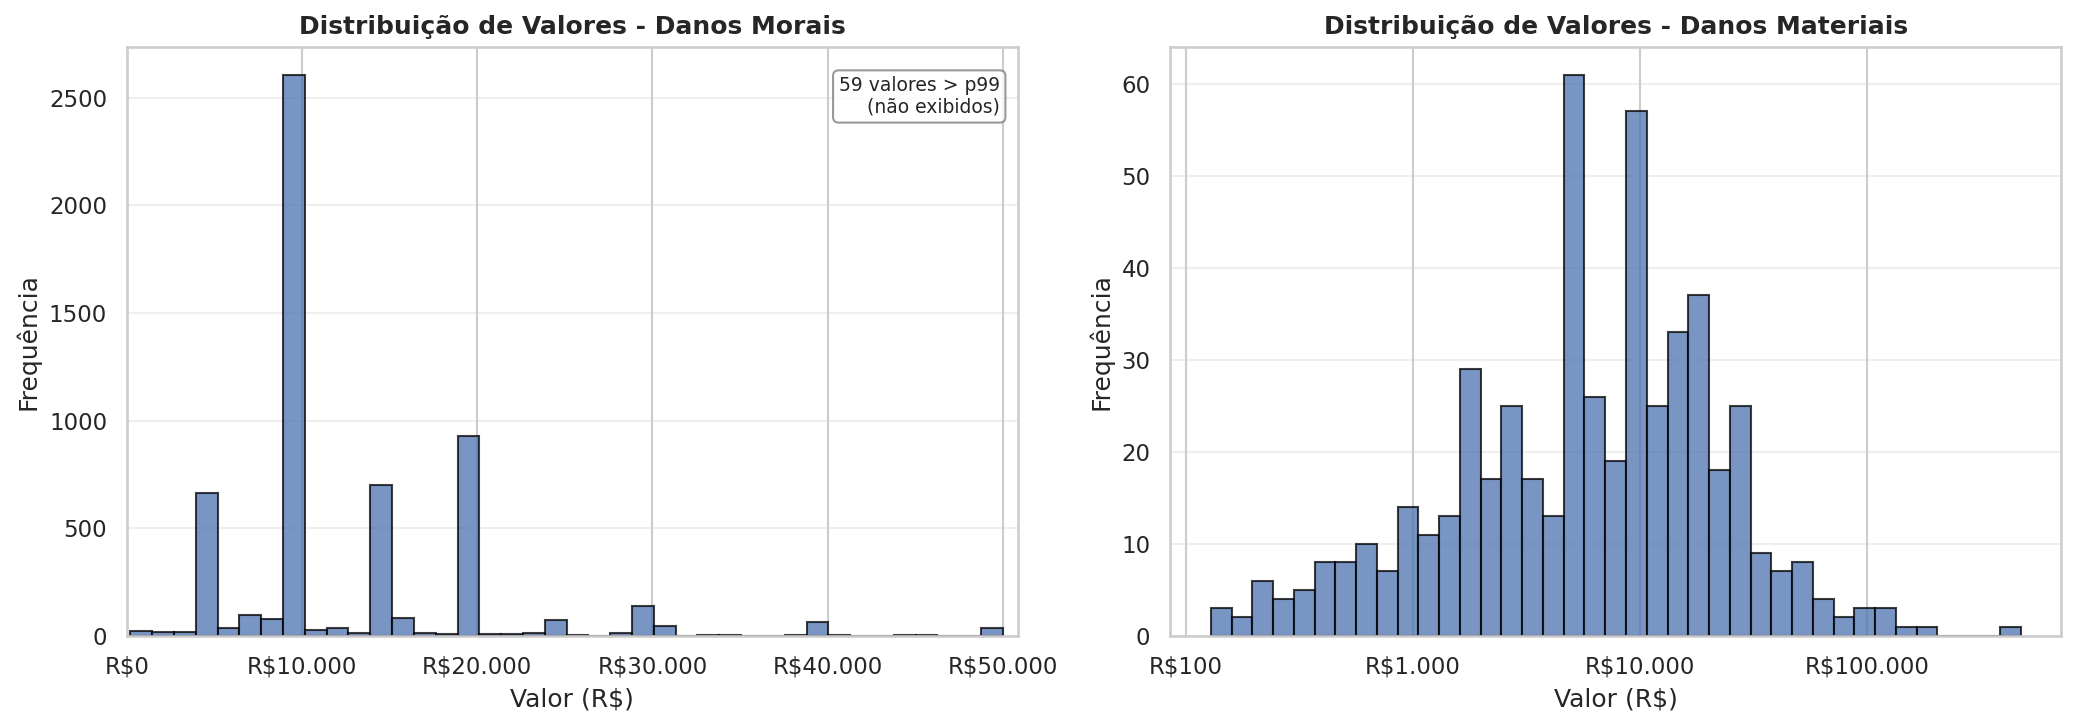

In [129]:
# Histogramas para valores de danos morais e materiais

def moeda(x, pos):
    return f'R${x:,.0f}'.replace(',', '.')
fmt = FuncFormatter(moeda)

# arrays 1D de valores positivos
moral = np.asarray(df_moral, dtype=float)
material = np.asarray(df_material, dtype=float)
moral = moral[moral > 0]
material = material[material > 0]

def log_bins(x, nbins=40):
    lo = np.nanmin(x[x>0])
    hi = np.nanmax(x)
    return np.logspace(np.log10(lo), np.log10(hi), nbins)

fig, axes = plt.subplots(1, 2, figsize=(14, 5), dpi=150)

def hist_podado(ax, x, titulo, xmax_percentil=99, bins=40):
    x = np.asarray(x, float)
    x = x[x>0]
    if not x.size:
        ax.text(0.5,0.5,'Sem dados',ha='center',va='center',transform=ax.transAxes); return
    p = np.percentile(x, xmax_percentil)
    cortados = (x > p).sum()
    ax.hist(x[x<=p], bins=bins, edgecolor='black', alpha=0.75)
    ax.set_xlim(0, p)
    ax.set_title(titulo, fontweight='bold')
    ax.set_xlabel('Valor (R$)')

    ax.set_ylabel('Frequência')
    ax.grid(axis='y', alpha=0.3)
    ax.xaxis.set_major_formatter(fmt)
    if cortados:
        ax.annotate(f'{cortados} valores > p{xmax_percentil}\n(não exibidos)',
                    xy=(0.98, 0.95), xycoords='axes fraction',
                    ha='right', va='top', fontsize=9,
                    bbox=dict(boxstyle='round,pad=0.3', fc='white', ec='gray', alpha=0.8))

# Danos Morais
hist_podado(axes[0], df_moral, 'Distribuição de Valores - Danos Morais', xmax_percentil=99)

# Danos Materiais
if material.size:
    bins = log_bins(material, nbins=40)
    axes[1].hist(material, bins=bins, edgecolor='black', alpha=0.75)
    axes[1].set_xscale('log')
    axes[1].set_title('Distribuição de Valores - Danos Materiais', fontweight='bold')
    axes[1].set_xlabel('Valor (R$)')
    axes[1].set_ylabel('Frequência')
    axes[1].grid(axis='y', alpha=0.3)
    axes[1].xaxis.set_major_formatter(fmt)
else:
    axes[1].text(0.5,0.5,'Sem dados',ha='center',va='center',transform=axes[1].transAxes)

plt.tight_layout()
plt.savefig('histogramas_danos_log.png', bbox_inches='tight')
plt.show()

/tmp/ipykernel_9783/903295231.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipykernel_9783/903295231.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


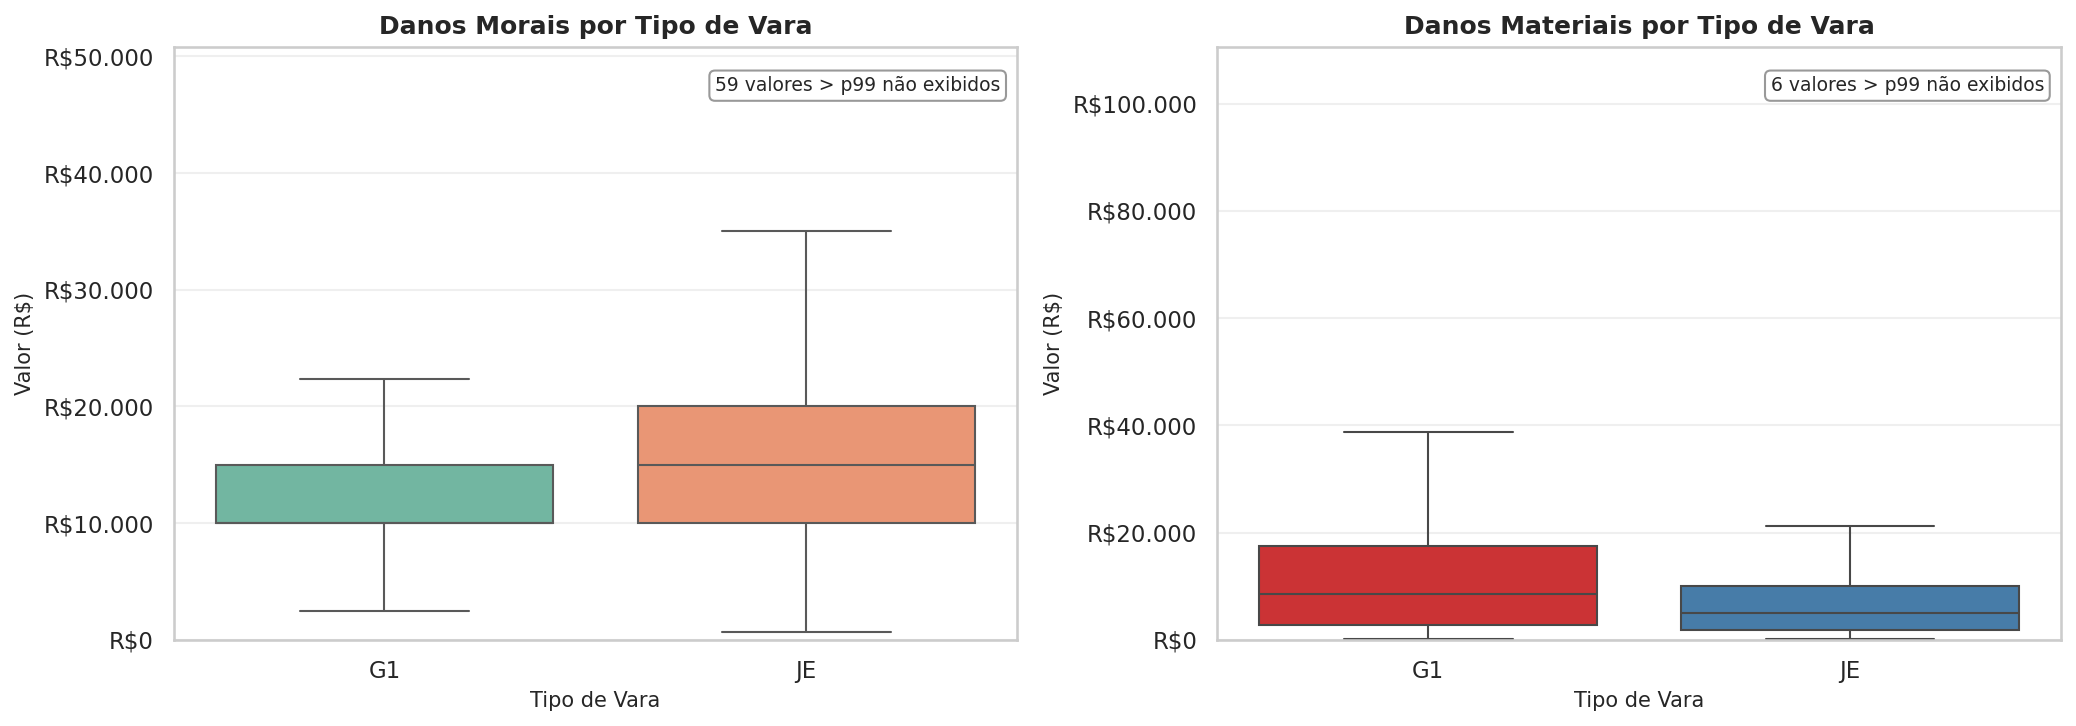

In [130]:
# Boxplots de valores de danos por tipo de vara (com corte em p99)
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

sns.set_theme(style="whitegrid")

# formatação R$ no eixo
fmt = FuncFormatter(lambda x, pos: f'R${x:,.0f}'.replace(',', '.'))

# Preparar dados
df_boxplot = resultado_expandido[
    (resultado_expandido['valor_moral'] > 0) | (resultado_expandido['valor_material'] > 0)
][['tipo_vara', 'valor_moral', 'valor_material']].copy()

fig, axes = plt.subplots(1, 2, figsize=(14, 5), dpi=150)

# ----- Danos Morais -----
df_moral_box = df_boxplot[df_boxplot['valor_moral'] > 0]
if len(df_moral_box) > 0:
    sns.boxplot(
        x='tipo_vara', y='valor_moral',
        data=df_moral_box, ax=axes[0],
        palette='Set2', showfliers=False
    )
    # corte em p99
    p99_moral = np.percentile(df_moral_box['valor_moral'], 99)
    axes[0].set_ylim(0, p99_moral)
    # (opcional) avisa quantos pontos ficaram fora
    cortados_moral = int((df_moral_box['valor_moral'] > p99_moral).sum())
    if cortados_moral:
        axes[0].annotate(
            f'{cortados_moral} valores > p99 não exibidos',
            xy=(0.98, 0.95), xycoords='axes fraction',
            ha='right', va='top', fontsize=9,
            bbox=dict(boxstyle='round,pad=0.3', fc='white', ec='gray', alpha=0.8)
        )

    axes[0].set_title('Danos Morais por Tipo de Vara', fontsize=12, fontweight='bold')
    axes[0].set_xlabel('Tipo de Vara', fontsize=10)
    axes[0].set_ylabel('Valor (R$)', fontsize=10)
    axes[0].yaxis.set_major_formatter(fmt)
    axes[0].tick_params(axis='x', rotation=0)
    axes[0].grid(axis='y', alpha=0.3)
else:
    axes[0].text(0.5, 0.5, 'Sem dados disponíveis', ha='center', va='center', transform=axes[0].transAxes)
    axes[0].set_title('Danos Morais por Tipo de Vara', fontsize=12, fontweight='bold')

# ----- Danos Materiais -----
df_material_box = df_boxplot[df_boxplot['valor_material'] > 0]
if len(df_material_box) > 0:
    sns.boxplot(
        x='tipo_vara', y='valor_material',
        data=df_material_box, ax=axes[1],
        palette='Set1', showfliers=False
    )
    # corte em p99
    p99_material = np.percentile(df_material_box['valor_material'], 99)
    axes[1].set_ylim(0, p99_material)
    # (opcional) avisa quantos pontos ficaram fora
    cortados_material = int((df_material_box['valor_material'] > p99_material).sum())
    if cortados_material:
        axes[1].annotate(
            f'{cortados_material} valores > p99 não exibidos',
            xy=(0.98, 0.95), xycoords='axes fraction',
            ha='right', va='top', fontsize=9,
            bbox=dict(boxstyle='round,pad=0.3', fc='white', ec='gray', alpha=0.8)
        )

    axes[1].set_title('Danos Materiais por Tipo de Vara', fontsize=12, fontweight='bold')
    axes[1].set_xlabel('Tipo de Vara', fontsize=10)
    axes[1].set_ylabel('Valor (R$)', fontsize=10)
    axes[1].yaxis.set_major_formatter(fmt)
    axes[1].tick_params(axis='x', rotation=0)
    axes[1].grid(axis='y', alpha=0.3)
else:
    axes[1].text(0.5, 0.5, 'Sem dados disponíveis', ha='center', va='center', transform=axes[1].transAxes)
    axes[1].set_title('Danos Materiais por Tipo de Vara', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('boxplots_danos_vara_p99.png', dpi=150, bbox_inches='tight')
plt.show()


### Interpretação das Estatísticas

**Observações principais:**

- **Valores de Danos Morais**: A distribuição revela a variação típica de pedidos de indenização moral em processos de consignação de crédito, com mediana e média indicando o valor central esperado.

- **Valores de Danos Materiais**: Menos frequentes que danos morais, os valores materiais tendem a ser mais concentrados (menor desvio-padrão relativo) quando presentes.

- **Variação por Tipo de Vara**: Os boxplots mostram diferenças regionais e jurisdicionais nos valores pedidos, com algumas varas apresentando outliers significativos.

- **Presença de Flags**: A ocorrência de expressões como "não inferior a", "em dobro" ou "até" indica estratégias processuais diferenciadas, que podem correlacionar-se com os valores efetivamente deferidos.

In [131]:
# ABA 2: DESCRITIVO (Estatísticas completas já calculadas na Seção 11)

print("="*80)
print("RELATÓRIO - ABA DESCRITIVO")
print("="*80)
print("\nEstatísticas de Danos Morais:")
display(stats_moral)
print("\nEstatísticas de Danos Materiais:")
display(stats_material)

RELATÓRIO - ABA DESCRITIVO

Estatísticas de Danos Morais:


,Métrica,Valor Moral
0,count,5.842000e+03
1,mean,1.668557e+04
2,median,1.000000e+04
3,std,1.481645e+05
4,min,2.000000e+02
5,p25,1.000000e+04
6,p75,1.518000e+04
7,max,8.000000e+06



Estatísticas de Danos Materiais:


,Métrica,Valor Material
0,count,532.000000
1,mean,13201.191184
2,median,6259.400000
3,std,27338.597410
4,min,129.000000
5,p25,2304.600000
6,p75,15000.000000
7,max,472030.940000


## 13. Sanidade Final e Verificação de Outputs

Esta seção verifica a integridade dos arquivos gerados e imprime um resumo final consolidado.

In [132]:
import os
from openpyxl import load_workbook

print("="*80)
print("VERIFICAÇÃO DE SANIDADE DOS OUTPUTS")
print("="*80)

# 1. Verificar output.xlsx (7 colunas da função original)
output_path = 'output.xlsx'
if os.path.exists(output_path):
    df_output = pd.read_excel(output_path)
    colunas_esperadas = ['cd_atendimento', 'nome_empresa', 'cnpj', 'valor_causa', 'dt_distribuicao', 'tipo_vara', 'uf']
    colunas_presentes = list(df_output.columns)
    
    print(f"\n✓ Arquivo '{output_path}' encontrado")
    print(f"  - Linhas: {len(df_output)}")
    print(f"  - Colunas: {colunas_presentes}")
    
    if colunas_presentes == colunas_esperadas:
        print("  ✓ Colunas corretas (7 colunas conforme roteiro)")
    else:
        print(f"  ✗ ATENÇÃO: Colunas diferentes do esperado!")
        print(f"    Esperado: {colunas_esperadas}")
        print(f"    Encontrado: {colunas_presentes}")
    
    # Verificar tipos
    print(f"\n  Tipagem de 'valor_causa': {df_output['valor_causa'].dtype}")
    if df_output['valor_causa'].dtype in ['float64', 'float32']:
        print("  ✓ valor_causa é float")
    else:
        print(f"  ✗ ATENÇÃO: valor_causa não é float!")
        
    # Verificar formato de data
    amostra_datas = df_output['dt_distribuicao'].dropna().head(3).tolist()
    print(f"  Amostra dt_distribuicao: {amostra_datas}")
    
else:
    print(f"\n✗ ERRO: Arquivo '{output_path}' NÃO encontrado!")
    print("  Execute a Seção 9 para gerar output.xlsx")

print("\n" + "-"*80)

# 2. Verificar relatorio.xlsx (3 abas)
relatorio_path = 'relatorio.xlsx'
if os.path.exists(relatorio_path):
    wb = load_workbook(relatorio_path)
    abas_presentes = wb.sheetnames
    abas_esperadas = ['Resumo', 'Descritivo', 'Logs_Sanidade']
    
    print(f"\n✓ Arquivo '{relatorio_path}' encontrado")
    print(f"  - Abas: {abas_presentes}")
    
    if set(abas_esperadas).issubset(set(abas_presentes)):
        print("  ✓ Todas as 3 abas esperadas estão presentes")
    else:
        print(f"  ✗ ATENÇÃO: Abas faltando!")
        print(f"    Esperado: {abas_esperadas}")
        
else:
    print(f"\n✗ ERRO: Arquivo '{relatorio_path}' NÃO encontrado!")
    print("  Execute a Seção 12 para gerar relatorio.xlsx")

print("\n" + "="*80)

VERIFICAÇÃO DE SANIDADE DOS OUTPUTS

✓ Arquivo 'output.xlsx' encontrado
  - Linhas: 8557
  - Colunas: ['cd_atendimento', 'nome_empresa', 'cnpj', 'valor_causa', 'dt_distribuicao', 'tipo_vara', 'uf']
  ✓ Colunas corretas (7 colunas conforme roteiro)

  Tipagem de 'valor_causa': float64
  ✓ valor_causa é float
  Amostra dt_distribuicao: ['2025-02-07', '2025-04-10', '2025-06-12']

--------------------------------------------------------------------------------

✗ ERRO: Arquivo 'relatorio.xlsx' NÃO encontrado!
  Execute a Seção 12 para gerar relatorio.xlsx


✓ Arquivo 'output.xlsx' encontrado
  - Linhas: 8557
  - Colunas: ['cd_atendimento', 'nome_empresa', 'cnpj', 'valor_causa', 'dt_distribuicao', 'tipo_vara', 'uf']
  ✓ Colunas corretas (7 colunas conforme roteiro)

  Tipagem de 'valor_causa': float64
  ✓ valor_causa é float
  Amostra dt_distribuicao: ['2025-02-07', '2025-04-10', '2025-06-12']

--------------------------------------------------------------------------------

✗ ERRO: Arquivo

In [133]:
# RESUMO FINAL CONSOLIDADO

print("="*80)
print("RESUMO FINAL DO PROCESSAMENTO")
print("="*80)

# Usar resultado_expandido se disponível, senão tentar ler de output.xlsx
try:
    df_final = resultado_expandido
    print("\n[Dados de resultado_expandido]")
except NameError:
    if os.path.exists('output.xlsx'):
        df_final = pd.read_excel('output.xlsx')
        print("\n[Dados de output.xlsx]")
    else:
        print("\n✗ ERRO: Nenhum dataset disponível para resumo!")
        df_final = None

if df_final is not None:
    print(f"\n Total de linhas processadas: {len(df_final)}")
    
    # CNPJ vazio
    cnpj_vazio_count = (df_final['cnpj'] == 'vazio').sum()
    print(f"\n CNPJs:")
    print(f"   - CNPJ = 'vazio': {cnpj_vazio_count} ({cnpj_vazio_count/len(df_final)*100:.2f}%)")
    print(f"   - CNPJ válido: {len(df_final) - cnpj_vazio_count} ({(len(df_final)-cnpj_vazio_count)/len(df_final)*100:.2f}%)")
    
    # Datas vazias
    datas_vazias = (df_final['dt_distribuicao'] == '').sum()
    print(f"\n Datas de Distribuição:")
    print(f"   - Vazias: {datas_vazias} ({datas_vazias/len(df_final)*100:.2f}%)")
    print(f"   - Preenchidas: {len(df_final) - datas_vazias} ({(len(df_final)-datas_vazias)/len(df_final)*100:.2f}%)")
    
    # Médias de valores (se disponível no df_final)
    if 'valor_moral' in df_final.columns and 'valor_material' in df_final.columns:
        moral_positivos = df_final[df_final['valor_moral'] > 0]['valor_moral']
        material_positivos = df_final[df_final['valor_material'] > 0]['valor_material']
        
        print(f"\n Valores Médios (apenas > 0):")
        if len(moral_positivos) > 0:
            print(f"   - Danos Morais: R$ {moral_positivos.mean():,.2f} ({len(moral_positivos)} casos)")
        else:
            print(f"   - Danos Morais: N/A (nenhum caso com valor > 0)")
            
        if len(material_positivos) > 0:
            print(f"   - Danos Materiais: R$ {material_positivos.mean():,.2f} ({len(material_positivos)} casos)")
        else:
            print(f"   - Danos Materiais: N/A (nenhum caso com valor > 0)")
    
    # Valor causa
    if 'valor_causa' in df_final.columns:
        valor_causa_positivos = df_final[df_final['valor_causa'] > 0]['valor_causa']
        print(f"\n Valor da Causa:")
        if len(valor_causa_positivos) > 0:
            print(f"   - Média: R$ {valor_causa_positivos.mean():,.2f}")
            print(f"   - Casos com valor > 0: {len(valor_causa_positivos)} ({len(valor_causa_positivos)/len(df_final)*100:.2f}%)")
        else:
            print(f"   - Nenhum caso com valor_causa > 0")

print("\n" + "="*80)
print("✓ PROCESSAMENTO CONCLUÍDO COM SUCESSO")
print("="*80)

RESUMO FINAL DO PROCESSAMENTO

[Dados de resultado_expandido]

 Total de linhas processadas: 8557

 CNPJs:
   - CNPJ = 'vazio': 816 (9.54%)
   - CNPJ válido: 7741 (90.46%)

 Datas de Distribuição:
   - Vazias: 4043 (47.25%)
   - Preenchidas: 4514 (52.75%)

 Valores Médios (apenas > 0):
   - Danos Morais: R$ 16,685.57 (5842 casos)
   - Danos Materiais: R$ 13,201.19 (532 casos)

 Valor da Causa:
   - Média: R$ 18,444.90
   - Casos com valor > 0: 8522 (99.59%)

✓ PROCESSAMENTO CONCLUÍDO COM SUCESSO


## 11.1 Feature Store / Targets (Preparação para Modelagem)

Esta seção prepara os dados para modelagem inferencial sem alterar a função `extrair_dados()` que gera `output.xlsx`.

**Objetivos:**
- Garantir alvos numéricos (valor_moral, valor_material) como float
- Criar features determinísticas (flags) para modelos
- Preparar splits de treino/teste
- One-hot encoding de variáveis categóricas

In [134]:
# Imports opcionais para modelagem (não obrigatório no venv)
# Descomente se necessário:
# !pip install -q statsmodels scikit-learn

# Imports já disponíveis
import numpy as np
import pandas as pd
import re
from datetime import datetime

print("Imports carregados para Feature Store")

Imports carregados para Feature Store


### Garantir Alvos Numéricos (valor_moral, valor_material)

In [135]:
# IMPORTANTE: Execute seção 10.1 antes para ter resultado_expandido disponível

# Verificar se já temos valores morais/materiais extraídos
if 'valor_moral' in resultado_expandido.columns and 'valor_material' in resultado_expandido.columns:
    print("Valores morais/materiais já extraídos. Garantindo tipagem float...")
    
    # Garantir tipo float e substituir NaN por 0.0
    resultado_expandido['valor_moral'] = pd.to_numeric(resultado_expandido['valor_moral'], errors='coerce').fillna(0.0)
    resultado_expandido['valor_material'] = pd.to_numeric(resultado_expandido['valor_material'], errors='coerce').fillna(0.0)
    
    print(f"  valor_moral: {resultado_expandido['valor_moral'].dtype}, {(resultado_expandido['valor_moral']>0).sum()} valores > 0")
    print(f"  valor_material: {resultado_expandido['valor_material'].dtype}, {(resultado_expandido['valor_material']>0).sum()} valores > 0")
else:
    print("AVISO: Execute a Seção 10.1 primeiro para extrair valores morais/materiais!")
    # Criar colunas vazias para não quebrar o código
    resultado_expandido['valor_moral'] = 0.0
    resultado_expandido['valor_material'] = 0.0

Valores morais/materiais já extraídos. Garantindo tipagem float...
  valor_moral: float64, 5842 valores > 0
  valor_material: float64, 532 valores > 0


### Criar Features Determinísticas (Regras)

In [136]:
# Criar cópia para trabalho (não alterar original)
df_features = resultado_expandido.copy()

# 1. tem_cnpj: 1 se CNPJ válido, 0 se "vazio"
df_features['tem_cnpj'] = (df_features['cnpj'] != 'vazio').astype(int)

# 2. is_JE: 1 se Juizado Especial, 0 se Vara Comum
df_features['is_JE'] = (df_features['tipo_vara'] == 'JE').astype(int)

# 3. tem_uf: 1 se UF preenchida
df_features['tem_uf'] = (df_features['uf'] != '').astype(int)

# 4. Garantir flags de texto como int (se já existem)
if 'has_minimo' in df_features.columns:
    df_features['has_minimo'] = df_features['has_minimo'].astype(int)
else:
    df_features['has_minimo'] = 0

if 'has_em_dobro' in df_features.columns:
    df_features['has_em_dobro'] = df_features['has_em_dobro'].astype(int)
else:
    df_features['has_em_dobro'] = 0

if 'has_ate' in df_features.columns:
    df_features['has_ate'] = df_features['has_ate'].astype(int)
else:
    df_features['has_ate'] = 0

print("="*80)
print("FEATURES CRIADAS")
print("="*80)
print(f"\ntem_cnpj: {df_features['tem_cnpj'].sum()} casos com CNPJ válido ({df_features['tem_cnpj'].sum()/len(df_features)*100:.1f}%)")
print(f"is_JE: {df_features['is_JE'].sum()} casos em Juizado Especial ({df_features['is_JE'].sum()/len(df_features)*100:.1f}%)")
print(f"tem_uf: {df_features['tem_uf'].sum()} casos com UF ({df_features['tem_uf'].sum()/len(df_features)*100:.1f}%)")
print(f"has_minimo: {df_features['has_minimo'].sum()} casos")
print(f"has_em_dobro: {df_features['has_em_dobro'].sum()} casos")
print(f"has_ate: {df_features['has_ate'].sum()} casos")
print("="*80)

FEATURES CRIADAS

tem_cnpj: 7741 casos com CNPJ válido (90.5%)
is_JE: 1710 casos em Juizado Especial (20.0%)
tem_uf: 8433 casos com UF (98.6%)
has_minimo: 648 casos
has_em_dobro: 1022 casos
has_ate: 2017 casos


### Sanidade dos Dados

In [137]:
# Remover linhas com dados críticos faltando
# (não alterar df original, trabalhar em cópia)

df_clean = df_features.dropna(subset=['valor_causa', 'tipo_vara', 'uf']).copy()

print(f"Registros antes da limpeza: {len(df_features)}")
print(f"Registros após limpeza: {len(df_clean)}")
print(f"Removidos: {len(df_features) - len(df_clean)}")

# Criar datasets separados para modelagem
df_moral = df_clean[df_clean['valor_moral'] > 0].copy()
df_material = df_clean[df_clean['valor_material'] > 0].copy()

print(f"\nDataset MORAL: {len(df_moral)} casos com valor_moral > 0")
print(f"Dataset MATERIAL: {len(df_material)} casos com valor_material > 0")

# Backup se dataset muito pequeno
if len(df_moral) < 10:
    print("\nAVISO: Dataset de danos morais muito pequeno (<10 casos). Modelagem pode não ser confiável.")
    
if len(df_material) < 10:
    print("\nAVISO: Dataset de danos materiais muito pequeno (<10 casos). Modelagem pode não ser confiável.")

Registros antes da limpeza: 8557
Registros após limpeza: 8557
Removidos: 0

Dataset MORAL: 5842 casos com valor_moral > 0
Dataset MATERIAL: 532 casos com valor_material > 0


### Split Train/Test e One-Hot Encoding

In [138]:
# Importar train_test_split (descomente se necessário instalar sklearn)
try:
    from sklearn.model_selection import train_test_split
    sklearn_available = True
except ImportError:
    print("AVISO: sklearn não instalado. Execute: pip install scikit-learn")
    print("Split manual será usado como fallback.\n")
    sklearn_available = False

# Features para modelagem
feature_cols = ['is_JE', 'tem_uf', 'tem_cnpj', 'has_minimo', 'has_em_dobro', 'has_ate']

print("="*80)
print("PREPARAÇÃO DE DATASETS PARA MODELAGEM")
print("="*80)

# ========== DANOS MORAIS ==========
if len(df_moral) >= 10 and sklearn_available:
    # Preparar X e y para danos morais
    X_moral_base = df_moral[feature_cols + ['tipo_vara', 'uf']].copy()
    y_moral = np.log1p(df_moral['valor_moral'].astype(float))
    
    # One-hot encoding
    X_moral_encoded = pd.get_dummies(X_moral_base, columns=['tipo_vara', 'uf'], drop_first=False)
    
    # Split 80/20
    X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(
        X_moral_encoded, y_moral, test_size=0.2, random_state=42
    )
    
    print(f"\nDANOS MORAIS:")
    print(f"  Total: {len(df_moral)} casos")
    print(f"  Treino: {len(X_train_m)} casos")
    print(f"  Teste: {len(X_test_m)} casos")
    print(f"  Features: {list(X_moral_encoded.columns)}")
    print(f"  Target: log1p(valor_moral)")
    
    # Salvar dataset final
    df_moral_final = X_moral_encoded.copy()
    df_moral_final['target_log'] = y_moral
    df_moral_final['valor_moral_original'] = df_moral['valor_moral'].values
    
elif len(df_moral) > 0:
    print(f"\nDANOS MORAIS: Dataset pequeno ({len(df_moral)} casos) ou sklearn indisponível")
    X_train_m, X_test_m, y_train_m, y_test_m = None, None, None, None
    df_moral_final = df_moral.copy()
else:
    print("\nDANOS MORAIS: Nenhum caso disponível")
    X_train_m, X_test_m, y_train_m, y_test_m = None, None, None, None
    df_moral_final = pd.DataFrame()

# ========== DANOS MATERIAIS ==========
if len(df_material) >= 10 and sklearn_available:
    # Preparar X e y para danos materiais
    X_material_base = df_material[feature_cols + ['tipo_vara', 'uf']].copy()
    y_material = np.log1p(df_material['valor_material'].astype(float))
    
    # One-hot encoding
    X_material_encoded = pd.get_dummies(X_material_base, columns=['tipo_vara', 'uf'], drop_first=False)
    
    # Split 80/20
    X_train_mat, X_test_mat, y_train_mat, y_test_mat = train_test_split(
        X_material_encoded, y_material, test_size=0.2, random_state=42
    )
    
    print(f"\nDANOS MATERIAIS:")
    print(f"  Total: {len(df_material)} casos")
    print(f"  Treino: {len(X_train_mat)} casos")
    print(f"  Teste: {len(X_test_mat)} casos")
    print(f"  Features: {list(X_material_encoded.columns)}")
    print(f"  Target: log1p(valor_material)")
    
    # Salvar dataset final
    df_material_final = X_material_encoded.copy()
    df_material_final['target_log'] = y_material
    df_material_final['valor_material_original'] = df_material['valor_material'].values
    
elif len(df_material) > 0:
    print(f"\nDANOS MATERIAIS: Dataset pequeno ({len(df_material)} casos) ou sklearn indisponível")
    X_train_mat, X_test_mat, y_train_mat, y_test_mat = None, None, None, None
    df_material_final = df_material.copy()
else:
    print("\nDANOS MATERIAIS: Nenhum caso disponível")
    X_train_mat, X_test_mat, y_train_mat, y_test_mat = None, None, None, None
    df_material_final = pd.DataFrame()

print("\n" + "="*80)
print("DATASETS PRONTOS PARA MODELAGEM")
print("="*80)
print("\nVariáveis disponíveis:")
print("  - df_moral_final: dataset completo de danos morais")
print("  - df_material_final: dataset completo de danos materiais")
print("  - X_train_m, X_test_m, y_train_m, y_test_m: splits para danos morais")
print("  - X_train_mat, X_test_mat, y_train_mat, y_test_mat: splits para danos materiais")
print("="*80)

PREPARAÇÃO DE DATASETS PARA MODELAGEM

DANOS MORAIS:
  Total: 5842 casos
  Treino: 4673 casos
  Teste: 1169 casos
  Features: ['is_JE', 'tem_uf', 'tem_cnpj', 'has_minimo', 'has_em_dobro', 'has_ate', 'tipo_vara_G1', 'tipo_vara_JE', 'uf_', 'uf_AC', 'uf_AL', 'uf_AM', 'uf_AP', 'uf_BA', 'uf_CE', 'uf_DF', 'uf_ES', 'uf_GO', 'uf_MA', 'uf_MG', 'uf_MS', 'uf_MT', 'uf_PA', 'uf_PB', 'uf_PE', 'uf_PI', 'uf_PR', 'uf_RJ', 'uf_RN', 'uf_RO', 'uf_RR', 'uf_RS', 'uf_SC', 'uf_SE', 'uf_SP', 'uf_TO']
  Target: log1p(valor_moral)

DANOS MATERIAIS:
  Total: 532 casos
  Treino: 425 casos
  Teste: 107 casos
  Features: ['is_JE', 'tem_uf', 'tem_cnpj', 'has_minimo', 'has_em_dobro', 'has_ate', 'tipo_vara_G1', 'tipo_vara_JE', 'uf_', 'uf_AC', 'uf_AL', 'uf_AM', 'uf_AP', 'uf_BA', 'uf_CE', 'uf_DF', 'uf_ES', 'uf_GO', 'uf_MA', 'uf_MG', 'uf_MS', 'uf_MT', 'uf_PA', 'uf_PB', 'uf_PE', 'uf_PI', 'uf_PR', 'uf_RJ', 'uf_RN', 'uf_RO', 'uf_RS', 'uf_SC', 'uf_SE', 'uf_SP', 'uf_TO']
  Target: log1p(valor_material)

DATASETS PRONTOS PARA M

## 11.2 Modelos Inferenciais (OLS com statsmodels)

Esta seção implementa modelos de regressão OLS para explicar fatores associados aos valores de danos morais e materiais.

**Objetivos:**
- Estimar efeitos de tipo_vara, uf, cnpj e flags textuais sobre valores pedidos
- Usar log1p(valor) como alvo para lidar com distribuição assimétrica
- Interpretar coeficientes em termos de impacto percentual
- Validar com métricas simples (MAE, R²)

In [139]:
# Imports para modelagem inferencial
try:
    import statsmodels.formula.api as smf
    from sklearn.metrics import mean_absolute_error, r2_score
    statsmodels_available = True
    print("statsmodels e sklearn disponíveis")
except ImportError as e:
    print(f"ERRO: {e}")
    print("Execute: pip install statsmodels scikit-learn")
    statsmodels_available = False

statsmodels e sklearn disponíveis


### Modelo OLS - Danos Morais

In [140]:
if statsmodels_available and len(df_moral) >= 10:
    print("="*80)
    print("MODELO OLS - DANOS MORAIS")
    print("="*80)
    
    # Preparar base para statsmodels
    base_m = df_moral.copy()
    base_m['tem_cnpj'] = (base_m['cnpj'] != 'vazio').astype(int)
    
    # Garantir que flags existem (criar com 0 se não)
    for flag in ['has_minimo', 'has_em_dobro', 'has_ate']:
        if flag not in base_m.columns:
            base_m[flag] = 0
        else:
            base_m[flag] = base_m[flag].fillna(0).astype(int)
    
    # Fórmula OLS com variáveis categóricas e flags
    formula_m = "np.log1p(valor_moral) ~ C(tipo_vara) + C(uf) + tem_cnpj + has_minimo + has_em_dobro + has_ate"
    
    try:
        # Ajustar modelo com erros robustos (HC3)
        mod_m = smf.ols(formula=formula_m, data=base_m).fit(cov_type='HC3')
        
        print(f"\nModelo ajustado com {len(base_m)} observações")
        print(f"Fórmula: {formula_m}")
        print("\n" + "="*80)
        print(mod_m.summary())
        print("="*80)
        
    except Exception as e:
        print(f"\nERRO ao ajustar modelo: {e}")
        mod_m = None
        base_m = None
        
elif not statsmodels_available:
    print("statsmodels não disponível - modelo não ajustado")
    mod_m = None
    base_m = None
else:
    print(f"Dataset de danos morais muito pequeno ({len(df_moral)} casos < 10)")
    mod_m = None
    base_m = None

MODELO OLS - DANOS MORAIS

Modelo ajustado com 5842 observações
Fórmula: np.log1p(valor_moral) ~ C(tipo_vara) + C(uf) + tem_cnpj + has_minimo + has_em_dobro + has_ate

                              OLS Regression Results                             
Dep. Variable:     np.log1p(valor_moral)   R-squared:                       0.117
Model:                               OLS   Adj. R-squared:                  0.112
Method:                    Least Squares   F-statistic:                     23.85
Date:                   Tue, 28 Oct 2025   Prob (F-statistic):          1.28e-130
Time:                           09:36:44   Log-Likelihood:                -4721.3
No. Observations:                   5842   AIC:                             9509.
Df Residuals:                       5809   BIC:                             9729.
Df Model:                             32                                         
Covariance Type:                     HC3                                         
            

### Modelo OLS - Danos Materiais

In [141]:
if statsmodels_available and len(df_material) >= 10:
    print("="*80)
    print("MODELO OLS - DANOS MATERIAIS")
    print("="*80)
    
    # Preparar base para statsmodels
    base_t = df_material.copy()
    base_t['tem_cnpj'] = (base_t['cnpj'] != 'vazio').astype(int)
    
    # Garantir que flags existem (criar com 0 se não)
    for flag in ['has_minimo', 'has_em_dobro', 'has_ate']:
        if flag not in base_t.columns:
            base_t[flag] = 0
        else:
            base_t[flag] = base_t[flag].fillna(0).astype(int)
    
    # Fórmula OLS com variáveis categóricas e flags
    formula_t = "np.log1p(valor_material) ~ C(tipo_vara) + C(uf) + tem_cnpj + has_minimo + has_em_dobro + has_ate"
    
    try:
        # Ajustar modelo com erros robustos (HC3)
        mod_t = smf.ols(formula=formula_t, data=base_t).fit(cov_type='HC3')
        
        print(f"\nModelo ajustado com {len(base_t)} observações")
        print(f"Fórmula: {formula_t}")
        print("\n" + "="*80)
        print(mod_t.summary())
        print("="*80)
        
    except Exception as e:
        print(f"\nERRO ao ajustar modelo: {e}")
        mod_t = None
        base_t = None
        
elif not statsmodels_available:
    print("statsmodels não disponível - modelo não ajustado")
    mod_t = None
    base_t = None
else:
    print(f"Dataset de danos materiais muito pequeno ({len(df_material)} casos < 10)")
    mod_t = None
    base_t = None

MODELO OLS - DANOS MATERIAIS

Modelo ajustado com 532 observações
Fórmula: np.log1p(valor_material) ~ C(tipo_vara) + C(uf) + tem_cnpj + has_minimo + has_em_dobro + has_ate

                               OLS Regression Results                               
Dep. Variable:     np.log1p(valor_material)   R-squared:                       0.173
Model:                                  OLS   Adj. R-squared:                  0.124
Method:                       Least Squares   F-statistic:                     856.8
Date:                      Tue, 28 Oct 2025   Prob (F-statistic):               0.00
Time:                              09:36:44   Log-Likelihood:                -872.18
No. Observations:                       532   AIC:                             1806.
Df Residuals:                           501   BIC:                             1939.
Df Model:                                30                                         
Covariance Type:                        HC3                   

### Métricas Rápidas (MAE e R²)

In [142]:
# Função para calcular métricas rápidas
def quick_metrics(model, df_base, target_col):
    """Calcula MAE e R² no espaço log"""
    if model is None or df_base is None:
        return None
    
    try:
        y_true = np.log1p(df_base[target_col].astype(float))
        y_pred = model.fittedvalues
        
        mae = mean_absolute_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)
        
        return {
            "MAE_log": round(mae, 4),
            "R2_log": round(r2, 4),
            "n_obs": len(df_base)
        }
    except Exception as e:
        print(f"Erro ao calcular métricas: {e}")
        return None

# Calcular métricas para ambos os modelos
print("="*80)
print("MÉTRICAS DE AJUSTE")
print("="*80)

if 'mod_m' in locals() and mod_m is not None:
    metrics_m = quick_metrics(mod_m, base_m, "valor_moral")
    print(f"\nDanos Morais:")
    print(f"  MAE (log): {metrics_m['MAE_log']}")
    print(f"  R² (log): {metrics_m['R2_log']}")
    print(f"  Observações: {metrics_m['n_obs']}")
else:
    metrics_m = None
    print("\nDanos Morais: Modelo não disponível")

if 'mod_t' in locals() and mod_t is not None:
    metrics_t = quick_metrics(mod_t, base_t, "valor_material")
    print(f"\nDanos Materiais:")
    print(f"  MAE (log): {metrics_t['MAE_log']}")
    print(f"  R² (log): {metrics_t['R2_log']}")
    print(f"  Observações: {metrics_t['n_obs']}")
else:
    metrics_t = None
    print("\nDanos Materiais: Modelo não disponível")

print("\n" + "="*80)

MÉTRICAS DE AJUSTE

Danos Morais:
  MAE (log): 0.3831
  R² (log): 0.1168
  Observações: 5842

Danos Materiais:
  MAE (log): 0.9901
  R² (log): 0.1733
  Observações: 532



### Interpretação dos Modelos

Análise dos coeficientes em termos de impacto percentual sobre os valores pedidos.

In [143]:
# Função para interpretar coeficientes em % (exp(beta) - 1)
def interpretar_coeficiente(beta, nome_var):
    """Converte coeficiente log em impacto percentual"""
    impacto_pct = (np.exp(beta) - 1) * 100
    sinal = "aumenta" if impacto_pct > 0 else "diminui"
    return f"{nome_var}: {sinal} {abs(impacto_pct):.1f}%"

print("="*80)
print("INTERPRETAÇÃO DOS MODELOS OLS")
print("="*80)

# ========== DANOS MORAIS ==========
if 'mod_m' in locals() and mod_m is not None:
    print("\n### DANOS MORAIS ###")
    print("\nCoeficientes mais relevantes (impacto % no valor):\n")
    
    params = mod_m.params
    pvalues = mod_m.pvalues
    
    # Filtrar coeficientes significativos (p < 0.10)
    coefs_sig = [(k, v, pvalues[k]) for k, v in params.items() if pvalues[k] < 0.10 and k != 'Intercept']
    coefs_sig.sort(key=lambda x: abs(x[1]), reverse=True)
    
    bullets = []
    
    for nome, beta, pval in coefs_sig[:6]:  # Top 6 coeficientes
        impacto_pct = (np.exp(beta) - 1) * 100
        sig_level = "***" if pval < 0.01 else "**" if pval < 0.05 else "*"
        
        # Interpretar nome da variável
        if 'tipo_vara' in nome:
            desc = nome.replace('C(tipo_vara)[T.', '').replace(']', '')
            texto = f"Processos em {desc} vs baseline"
        elif 'uf[T.' in nome:
            uf = nome.replace('C(uf)[T.', '').replace(']', '')
            texto = f"Processos em {uf} vs baseline"
        elif 'tem_cnpj' in nome:
            texto = "Ter CNPJ identificado"
        elif 'has_minimo' in nome:
            texto = "Expressão 'não inferior a'"
        elif 'has_em_dobro' in nome:
            texto = "Expressão 'em dobro'"
        elif 'has_ate' in nome:
            texto = "Expressão 'até'"
        else:
            texto = nome
        
        bullets.append(f"  - {texto}: {impacto_pct:+.1f}% {sig_level} (p={pval:.3f})")
    
    for b in bullets:
        print(b)
    
    print(f"\n  R² ajustado: {mod_m.rsquared_adj:.3f}")
    print(f"  Observações: {mod_m.nobs}")
    
    print("\n**Leitura:**")
    print("  - Coeficientes positivos indicam valores pedidos mais altos")
    print("  - Coeficientes negativos indicam valores mais baixos")
    print("  - % calculado como (exp(beta) - 1) × 100")
    print("  - Significância: *** p<0.01, ** p<0.05, * p<0.10")

else:
    print("\n### DANOS MORAIS ###")
    print("Modelo não disponível")

# ========== DANOS MATERIAIS ==========
if 'mod_t' in locals() and mod_t is not None:
    print("\n" + "-"*80)
    print("\n### DANOS MATERIAIS ###")
    print("\nCoeficientes mais relevantes (impacto % no valor):\n")
    
    params = mod_t.params
    pvalues = mod_t.pvalues
    
    # Filtrar coeficientes significativos (p < 0.10)
    coefs_sig = [(k, v, pvalues[k]) for k, v in params.items() if pvalues[k] < 0.10 and k != 'Intercept']
    coefs_sig.sort(key=lambda x: abs(x[1]), reverse=True)
    
    bullets = []
    
    for nome, beta, pval in coefs_sig[:6]:  # Top 6 coeficientes
        impacto_pct = (np.exp(beta) - 1) * 100
        sig_level = "***" if pval < 0.01 else "**" if pval < 0.05 else "*"
        
        # Interpretar nome da variável
        if 'tipo_vara' in nome:
            desc = nome.replace('C(tipo_vara)[T.', '').replace(']', '')
            texto = f"Processos em {desc} vs baseline"
        elif 'uf[T.' in nome:
            uf = nome.replace('C(uf)[T.', '').replace(']', '')
            texto = f"Processos em {uf} vs baseline"
        elif 'tem_cnpj' in nome:
            texto = "Ter CNPJ identificado"
        elif 'has_minimo' in nome:
            texto = "Expressão 'não inferior a'"
        elif 'has_em_dobro' in nome:
            texto = "Expressão 'em dobro'"
        elif 'has_ate' in nome:
            texto = "Expressão 'até'"
        else:
            texto = nome
        
        bullets.append(f"  - {texto}: {impacto_pct:+.1f}% {sig_level} (p={pval:.3f})")
    
    for b in bullets:
        print(b)
    
    print(f"\n  R² ajustado: {mod_t.rsquared_adj:.3f}")
    print(f"  Observações: {mod_t.nobs}")
    
    print("\n**Leitura:**")
    print("  - Coeficientes positivos indicam valores pedidos mais altos")
    print("  - Coeficientes negativos indicam valores mais baixos")
    print("  - % calculado como (exp(beta) - 1) × 100")
    print("  - Significância: *** p<0.01, ** p<0.05, * p<0.10")

else:
    print("\n### DANOS MATERIAIS ###")
    print("Modelo não disponível")

print("\n" + "="*80)

INTERPRETAÇÃO DOS MODELOS OLS

### DANOS MORAIS ###

Coeficientes mais relevantes (impacto % no valor):

  - C(uf)[T.ES]: +82.7% *** (p=0.010)
  - C(uf)[T.RJ]: +67.0% *** (p=0.001)
  - C(uf)[T.AM]: +55.2% *** (p=0.004)
  - C(uf)[T.MG]: +50.2% *** (p=0.008)
  - C(uf)[T.SC]: +49.4% *** (p=0.009)
  - C(uf)[T.GO]: +41.4% ** (p=0.032)

  R² ajustado: 0.112
  Observações: 5842.0

**Leitura:**
  - Coeficientes positivos indicam valores pedidos mais altos
  - Coeficientes negativos indicam valores mais baixos
  - % calculado como (exp(beta) - 1) × 100
  - Significância: *** p<0.01, ** p<0.05, * p<0.10

--------------------------------------------------------------------------------

### DANOS MATERIAIS ###

Coeficientes mais relevantes (impacto % no valor):

  - Expressão 'até': +15525.5% *** (p=0.000)
  - C(uf)[T.DF]: -84.8% * (p=0.088)
  - C(uf)[T.SC]: -79.7% ** (p=0.021)
  - C(uf)[T.BA]: -70.7% * (p=0.052)
  - C(uf)[T.AL]: -69.0% * (p=0.088)
  - Ter CNPJ identificado: -57.9% *** (p=0.000)



### Validação Cruzada (Opcional - KFold 5x)

Validação com cross-validation para verificar robustez das métricas.

In [144]:
# Validação cruzada opcional (apenas para métricas, não para inferência)
try:
    from sklearn.linear_model import LinearRegression
    from sklearn.model_selection import cross_val_score, KFold
    sklearn_full = True
except ImportError:
    print("sklearn não disponível - validação cruzada não executada")
    sklearn_full = False

if sklearn_full and statsmodels_available:
    print("="*80)
    print("VALIDAÇÃO CRUZADA (KFold 5x) - apenas para métricas")
    print("="*80)
    
    # ========== DANOS MORAIS ==========
    if 'base_m' in locals() and base_m is not None and len(base_m) >= 20:
        print("\nDanos Morais:")
        
        # Preparar features (one-hot encoding)
        X_m = pd.get_dummies(base_m[['tipo_vara', 'uf', 'tem_cnpj', 'has_minimo', 'has_em_dobro', 'has_ate']], 
                              drop_first=False)
        y_m = np.log1p(base_m['valor_moral'])
        
        # KFold 5x
        kf = KFold(n_splits=5, shuffle=True, random_state=42)
        lr = LinearRegression()
        
        # Calcular MAE e R² com CV
        mae_scores = -cross_val_score(lr, X_m, y_m, cv=kf, scoring='neg_mean_absolute_error')
        r2_scores = cross_val_score(lr, X_m, y_m, cv=kf, scoring='r2')
        
        print(f"  MAE médio (log): {mae_scores.mean():.4f} ± {mae_scores.std():.4f}")
        print(f"  R² médio (log): {r2_scores.mean():.4f} ± {r2_scores.std():.4f}")
    else:
        print("\nDanos Morais: Dataset insuficiente para KFold (<20 casos)")
    
    # ========== DANOS MATERIAIS ==========
    if 'base_t' in locals() and base_t is not None and len(base_t) >= 20:
        print("\nDanos Materiais:")
        
        # Preparar features (one-hot encoding)
        X_t = pd.get_dummies(base_t[['tipo_vara', 'uf', 'tem_cnpj', 'has_minimo', 'has_em_dobro', 'has_ate']], 
                              drop_first=False)
        y_t = np.log1p(base_t['valor_material'])
        
        # KFold 5x
        kf = KFold(n_splits=5, shuffle=True, random_state=42)
        lr = LinearRegression()
        
        # Calcular MAE e R² com CV
        mae_scores = -cross_val_score(lr, X_t, y_t, cv=kf, scoring='neg_mean_absolute_error')
        r2_scores = cross_val_score(lr, X_t, y_t, cv=kf, scoring='r2')
        
        print(f"  MAE médio (log): {mae_scores.mean():.4f} ± {mae_scores.std():.4f}")
        print(f"  R² médio (log): {r2_scores.mean():.4f} ± {r2_scores.std():.4f}")
    else:
        print("\nDanos Materiais: Dataset insuficiente para KFold (<20 casos)")
    
    print("\n" + "="*80)
    print("NOTA: Os modelos statsmodels (OLS) são preferidos para inferência.")
    print("Esta validação serve apenas para verificar robustez das métricas.")
    print("="*80)

else:
    print("Validação cruzada não executada (sklearn ou statsmodels indisponível)")

VALIDAÇÃO CRUZADA (KFold 5x) - apenas para métricas

Danos Morais:
  MAE médio (log): 0.3865 ± 0.0116
  R² médio (log): 0.0968 ± 0.0116

Danos Materiais:
  MAE médio (log): 1.0792 ± 0.0594
  R² médio (log): 0.0156 ± 0.0227

NOTA: Os modelos statsmodels (OLS) são preferidos para inferência.
Esta validação serve apenas para verificar robustez das métricas.


## 11.3 Classificadores Simples (Regras + ML)

Implementação de classificadores para:
- **(A) JE vs G1**: Distinguir Juizado Especial de Vara Comum
- **(B) "É consignado?"**: Identificar casos de crédito consignado (se houver variação)

**Abordagem:**
- Regras determinísticas (baseline interpretável)
- LogisticRegression com TF-IDF char n-grams (ML leve)
- Comparação e combinação híbrida

### Regras Determinísticas (Baseline Interpretável)

In [145]:
# IMPORTANTE: Use resultado_expandido ou df_clean da seção 11.1
# Se não disponível, use dataset original filtrado

try:
    df_classif = df_clean.copy()
    print(f"Usando df_clean da seção 11.1: {len(df_classif)} casos")
except NameError:
    try:
        df_classif = resultado_expandido.copy()
        print(f"Usando resultado_expandido: {len(df_classif)} casos")
    except NameError:
        print("ERRO: Execute seções anteriores primeiro (10.1 ou 11.1)")
        df_classif = pd.DataFrame()

# Funções de regras determinísticas
def rule_is_JE(texto: str) -> int:
    """Regra: identifica Juizado Especial por menções explícitas"""
    s = (texto or "").lower()
    # Busca por "juizado especial" ou "jec" (word boundary)
    if "juizado especial" in s:
        return 1
    if re.search(r'\bjec\b', s):
        return 1
    if "jecc" in s:
        return 1
    return 0

def rule_is_consignado(texto: str) -> int:
    """Regra: identifica crédito consignado por menções explícitas"""
    s = (texto or "").lower()
    # Busca por "crédito consignado" ou "empréstimo consignado"
    if re.search(r'\bcr[eé]dito consignado\b', s):
        return 1
    if "empréstimo consignado" in s:
        return 1
    if "consignação" in s and ("crédito" in s or "empréstimo" in s):
        return 1
    return 0

print("\nRegras definidas:")
print("  - rule_is_JE: busca 'juizado especial', 'jec', 'jecc'")
print("  - rule_is_consignado: busca 'crédito consignado', 'empréstimo consignado'")

Usando df_clean da seção 11.1: 8557 casos

Regras definidas:
  - rule_is_JE: busca 'juizado especial', 'jec', 'jecc'
  - rule_is_consignado: busca 'crédito consignado', 'empréstimo consignado'


In [146]:
if len(df_classif) > 0:
    # Aplicar regras ao dataset
    
    # Regra JE: aplicar em ds_Qualificacao (ou texto combinado)
    if 'ds_Qualificacao' in df_classif.columns:
        df_classif['pred_je_rule'] = df_classif['ds_Qualificacao'].fillna("").apply(rule_is_JE)
    else:
        # Fallback: usar texto combinado
        texto_combined = (
            df_classif.get('ds_Pedidos', pd.Series([""]*len(df_classif))).fillna("") + " " +
            df_classif.get('ds_fatos', pd.Series([""]*len(df_classif))).fillna("")
        )
        df_classif['pred_je_rule'] = texto_combined.apply(rule_is_JE)
    
    # Regra Consignado: aplicar em texto combinado
    texto_consig = (
        df_classif.get('ds_Acao_Judicial', pd.Series([""]*len(df_classif))).fillna("").astype(str) + " " +
        df_classif.get('ds_fatos', pd.Series([""]*len(df_classif))).fillna("").astype(str) + " " +
        df_classif.get('ds_Pedidos', pd.Series([""]*len(df_classif))).fillna("").astype(str) + " " +
        df_classif.get('ds_Qualificacao', pd.Series([""]*len(df_classif))).fillna("").astype(str)
    )
    df_classif['pred_consignado_rule'] = texto_consig.apply(rule_is_consignado)
    
    # Ground truth (se disponível)
    if 'tipo_vara' in df_classif.columns:
        df_classif['y_je_true'] = (df_classif['tipo_vara'] == 'JE').astype(int)
    else:
        df_classif['y_je_true'] = None
        print("AVISO: coluna 'tipo_vara' não encontrada - usando regra como pseudo-label")
    
    print("="*80)
    print("APLICAÇÃO DE REGRAS DETERMINÍSTICAS")
    print("="*80)
    print(f"\nJE (Juizado Especial):")
    print(f"  Casos identificados como JE: {df_classif['pred_je_rule'].sum()} ({df_classif['pred_je_rule'].sum()/len(df_classif)*100:.1f}%)")
    print(f"  Casos identificados como G1: {(1-df_classif['pred_je_rule']).sum()} ({(1-df_classif['pred_je_rule']).sum()/len(df_classif)*100:.1f}%)")
    
    print(f"\nCrédito Consignado:")
    print(f"  Casos identificados: {df_classif['pred_consignado_rule'].sum()} ({df_classif['pred_consignado_rule'].sum()/len(df_classif)*100:.1f}%)")
    print(f"  Casos NÃO identificados: {(1-df_classif['pred_consignado_rule']).sum()} ({(1-df_classif['pred_consignado_rule']).sum()/len(df_classif)*100:.1f}%)")
    
    # Verificar variação para classificador B
    variacao_consig = df_classif['pred_consignado_rule'].sum()
    if variacao_consig == 0 or variacao_consig == len(df_classif):
        print("\n  NOTA: Dataset 100% homogêneo para 'consignado' - classificador B será pulado")
        skip_classif_b = True
    else:
        skip_classif_b = False
    
    print("="*80)
else:
    print("Dataset vazio - pule esta seção")

APLICAÇÃO DE REGRAS DETERMINÍSTICAS

JE (Juizado Especial):
  Casos identificados como JE: 0 (0.0%)
  Casos identificados como G1: 8557 (100.0%)

Crédito Consignado:
  Casos identificados: 0 (0.0%)
  Casos NÃO identificados: 8557 (100.0%)

  NOTA: Dataset 100% homogêneo para 'consignado' - classificador B será pulado


### Classificador ML (A): JE vs G1 com LogisticRegression

In [147]:
# === Classificador ML (A): JE vs G1 com LogisticRegression (robusto a texto vazio) ===
try:
    import numpy as np, pandas as pd, re
    from sklearn.feature_extraction.text import TfidfVectorizer
    from sklearn.linear_model import LogisticRegression
    from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
    from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
    from scipy.sparse import hstack, csr_matrix
    sklearn_classif = True
except Exception as e:
    print(f"sklearn/scipy indisponível ({e}) — classificadores ML não executados")
    sklearn_classif = False

clf_je = None
metrics_clf_je_holdout, metrics_clf_je_cv = None, None

if sklearn_classif and isinstance(df_classif, pd.DataFrame) and len(df_classif) > 20:
    print("="*80)
    print("CLASSIFICADOR ML (A): JE vs G1 (robusto)")
    print("="*80)

    # ---------- Target ----------
    use_gt = ("y_je_true" in df_classif.columns) and df_classif["y_je_true"].notna().all()
    if use_gt:
        y_je = df_classif["y_je_true"].astype(int).values
        print("\nUsando ground truth de 'tipo_vara'")
    else:
        if "pred_je_rule" not in df_classif.columns:
            # regra básica como fallback
            def _rule_is_JE(texto: str) -> int:
                s = (texto or "").lower()
                return int(("juizado especial" in s) or (re.search(r"\bjec\b", s) is not None))
            txt_base = df_classif.get("ds_Qualificacao","").astype(str)
            df_classif["pred_je_rule"] = txt_base.map(_rule_is_JE)
        y_je = df_classif["pred_je_rule"].astype(int).values
        print("\nUsando pseudo-label da regra (tipo_vara completo não disponível)")

    # distribuição
    je_count = int(y_je.sum())
    g1_count = int(len(y_je) - je_count)
    print(f"Distribuição: JE={je_count} ({je_count/len(y_je)*100:.1f}%), G1={g1_count} ({g1_count/len(y_je)*100:.1f}%)")
    if je_count < 5 or g1_count < 5:
        print("AVISO: classes muito desbalanceadas — resultados podem não ser confiáveis")

    # checar se há 2 classes
    unique_classes = np.unique(y_je)
    if unique_classes.size < 2:
        print(f"AVISO: y_je tem {unique_classes.size} classe(s) — precisa de >=2. Abortando treino.")
    else:
        # ---------- Texto ----------
        txt_cols = [c for c in ["ds_Qualificacao", "ds_Pedidos", "ds_fatos"] if c in df_classif.columns]
        if len(txt_cols) == 0:
            print("\nERRO: Nenhuma coluna de texto disponível — TF-IDF será pulado.")
            X_text = pd.Series([""] * len(df_classif))
        else:
            X_text = df_classif[txt_cols].fillna("").astype(str).agg(" ".join, axis=1)
            print(f"\nColunas de texto: {txt_cols}")

        has_text = X_text.str.strip().str.len() > 0

        # ---------- TF-IDF (com fallback) ----------
        X_tfidf = None
        if has_text.any():
            print("\nGerando features TF-IDF (char n-grams 3–5)...")
            try:
                tfidf = TfidfVectorizer(
                    analyzer="char",
                    ngram_range=(3, 5),
                    min_df=5,
                    max_features=50000,
                    lowercase=True
                )
                X_tfidf = tfidf.fit_transform(X_text)
                if X_tfidf.shape[1] == 0:
                    raise ValueError("Vocabulário vazio com min_df=5.")
                print(f"  Shape TF-IDF: {X_tfidf.shape}")
            except Exception as e:
                print(f"FALLBACK TF-IDF: {e}")
                print("Tentando com n-grams (2–5) e min_df=1...")
                tfidf = TfidfVectorizer(
                    analyzer="char",
                    ngram_range=(2, 5),
                    min_df=1,
                    max_features=50000,
                    lowercase=True
                )
                X_tfidf = tfidf.fit_transform(X_text)
                print(f"  Shape TF-IDF (fallback): {X_tfidf.shape}")
        else:
            print("AVISO: todos os documentos de texto ficaram vazios — TF-IDF será pulado.")

        # ---------- Features densas ----------
        dense_features = []

        if "uf" in df_classif.columns:
            dense_features.append((df_classif["uf"].fillna("") != "").astype(int).values.reshape(-1, 1))

        if "cnpj" in df_classif.columns:
            dense_features.append((df_classif["cnpj"].fillna("vazio") != "vazio").astype(int).values.reshape(-1, 1))

        for col in ["has_minimo", "has_em_dobro", "has_ate"]:
            if col in df_classif.columns:
                dense_features.append(df_classif[col].fillna(0).astype(int).values.reshape(-1, 1))

        if len(dense_features) > 0:
            X_dense = np.hstack(dense_features)
            print(f"  Features densas adicionadas: {X_dense.shape[1]}")
        else:
            X_dense = np.zeros((len(df_classif), 0))

        # ---------- Combinação final ----------
        if X_tfidf is not None:
            X = hstack([X_tfidf, csr_matrix(X_dense)])
        else:
            if X_dense.shape[1] == 0:
                print("Sem TF-IDF e sem features densas — abortando classificador.")
                X = None
            else:
                X = csr_matrix(X_dense)

        if X is not None:
            print(f"  Shape final: {X.shape}")

            # ---------- Split e treino ----------
            print("\nTreinamento com split 80/20...")
            X_tr, X_te, y_tr, y_te = train_test_split(
                X, y_je, test_size=0.2, random_state=42, stratify=y_je
            )

            # solver mais estável em sparse/datasets pequenos
            clf_je = LogisticRegression(max_iter=200, random_state=42, solver="liblinear")
            clf_je.fit(X_tr, y_tr)

            pred_te = clf_je.predict(X_te)
            acc_test = accuracy_score(y_te, pred_te)
            f1_test = f1_score(y_te, pred_te, zero_division=0)

            metrics_clf_je_holdout = {
                "acc_test": float(acc_test),
                "f1_test": float(f1_test),
                "y_te": y_te,
                "pred_te": pred_te,
            }

            print(f"\nResultados no Test Set (20%):")
            print(f"  Accuracy: {acc_test:.3f}")
            print(f"  F1-Score: {f1_test:.3f}")

            print("\nConfusion Matrix:")
            cm = confusion_matrix(y_te, pred_te)
            print(f"  TN={cm[0,0]}, FP={cm[0,1]}")
            print(f"  FN={cm[1,0]}, TP={cm[1,1]}")

            print("\nClassification Report:")
            print(classification_report(y_te, pred_te, target_names=["G1", "JE"], zero_division=0))

            # ---------- Cross-validation ----------
            print("\nCross-Validation (5-fold estratificado)...")
            cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
            acc_cv = cross_val_score(clf_je, X, y_je, cv=cv, scoring="accuracy")
            f1_cv = cross_val_score(clf_je, X, y_je, cv=cv, scoring="f1")

            metrics_clf_je_cv = {
                "acc_cv_mean": float(acc_cv.mean()),
                "acc_cv_std": float(acc_cv.std()),
                "f1_cv_mean": float(f1_cv.mean()),
                "f1_cv_std": float(f1_cv.std()),
            }

            print(f"  CV Accuracy: {acc_cv.mean():.3f} ± {acc_cv.std():.3f}")
            print(f"  CV F1-Score: {f1_cv.mean():.3f} ± {f1_cv.std():.3f}")

            # Previsões no dataset completo
            df_classif["pred_je_ml"] = clf_je.predict(X)

            print("\n" + "="*80)
else:
    if not sklearn_classif:
        print("sklearn não disponível — classificador ML não executado")
    else:
        print(f"Dataset muito pequeno ({len(df_classif) if isinstance(df_classif, pd.DataFrame) else 'n/a'} casos) — classificador ML não executado")


CLASSIFICADOR ML (A): JE vs G1 (robusto)

Usando ground truth de 'tipo_vara'
Distribuição: JE=1710 (20.0%), G1=6847 (80.0%)

ERRO: Nenhuma coluna de texto disponível — TF-IDF será pulado.
AVISO: todos os documentos de texto ficaram vazios — TF-IDF será pulado.
  Features densas adicionadas: 5
  Shape final: (8557, 5)

Treinamento com split 80/20...

Resultados no Test Set (20%):
  Accuracy: 0.800
  F1-Score: 0.000

Confusion Matrix:
  TN=1370, FP=0
  FN=342, TP=0

Classification Report:
              precision    recall  f1-score   support

          G1       0.80      1.00      0.89      1370
          JE       0.00      0.00      0.00       342

    accuracy                           0.80      1712
   macro avg       0.40      0.50      0.44      1712
weighted avg       0.64      0.80      0.71      1712


Cross-Validation (5-fold estratificado)...
  CV Accuracy: 0.800 ± 0.000
  CV F1-Score: 0.000 ± 0.000



### Comparação: Regras vs ML (Classificador A - JE/G1)

In [148]:
if 'clf_je' in locals() and clf_je is not None and 'y_je_true' in df_classif.columns and df_classif['y_je_true'].notna().all():
    print("="*80)
    print("COMPARAÇÃO: REGRAS vs ML (JE/G1)")
    print("="*80)
    
    y_true = df_classif['y_je_true'].values
    pred_rule = df_classif['pred_je_rule'].values
    pred_ml = df_classif['pred_je_ml'].values
    
    # Métricas das regras
    acc_rule = accuracy_score(y_true, pred_rule)
    f1_rule = f1_score(y_true, pred_rule, zero_division=0)
    
    # Métricas do ML
    acc_ml = accuracy_score(y_true, pred_ml)
    f1_ml = f1_score(y_true, pred_ml, zero_division=0)
    
    print("\n### BASELINE: REGRAS DETERMINÍSTICAS ###")
    print(f"  Accuracy: {acc_rule:.3f}")
    print(f"  F1-Score: {f1_rule:.3f}")
    
    print("\n  Confusion Matrix:")
    cm_rule = confusion_matrix(y_true, pred_rule)
    print(f"    TN={cm_rule[0,0]}, FP={cm_rule[0,1]}")
    print(f"    FN={cm_rule[1,0]}, TP={cm_rule[1,1]}")
    
    print("\n### ML: LOGISTIC REGRESSION ###")
    print(f"  Accuracy: {acc_ml:.3f}")
    print(f"  F1-Score: {f1_ml:.3f}")
    
    print("\n  Confusion Matrix:")
    cm_ml = confusion_matrix(y_true, pred_ml)
    print(f"    TN={cm_ml[0,0]}, FP={cm_ml[0,1]}")
    print(f"    FN={cm_ml[1,0]}, TP={cm_ml[1,1]}")
    
    print("\n### GANHO DO ML ###")
    ganho_acc = (acc_ml - acc_rule) * 100
    ganho_f1 = (f1_ml - f1_rule) * 100
    
    print(f"  Accuracy: {ganho_acc:+.1f} pontos percentuais")
    print(f"  F1-Score: {ganho_f1:+.1f} pontos percentuais")
    
    if ganho_acc < 2 and ganho_f1 < 2:
        print("\n  CONCLUSÃO: Regra determinística já é muito boa. ML oferece ganho marginal.")
        print("  Recomendação: Usar regra como baseline e ML apenas em casos ambíguos.")
    else:
        print("\n  CONCLUSÃO: ML oferece melhoria significativa sobre regras.")
        print("  Recomendação: Usar ML como classificador principal.")
    
    print("\n" + "="*80)
    
elif 'pred_je_rule' in df_classif.columns and 'pred_je_ml' in df_classif.columns:
    print("="*80)
    print("COMPARAÇÃO: REGRAS vs ML (JE/G1)")
    print("="*80)
    print("\nGround truth não disponível - comparação entre regra e ML:")
    
    concordancia = (df_classif['pred_je_rule'] == df_classif['pred_je_ml']).sum()
    total = len(df_classif)
    
    print(f"  Casos em concordância: {concordancia}/{total} ({concordancia/total*100:.1f}%)")
    print(f"  Casos em divergência: {total-concordancia}/{total} ({(total-concordancia)/total*100:.1f}%)")
    
    print("\n  NOTA: Sem ground truth, não é possível calcular accuracy/F1 real.")
    print("="*80)
    
else:
    print("Comparação não disponível - execute células anteriores")

COMPARAÇÃO: REGRAS vs ML (JE/G1)

### BASELINE: REGRAS DETERMINÍSTICAS ###
  Accuracy: 0.800
  F1-Score: 0.000

  Confusion Matrix:
    TN=6847, FP=0
    FN=1710, TP=0

### ML: LOGISTIC REGRESSION ###
  Accuracy: 0.800
  F1-Score: 0.000

  Confusion Matrix:
    TN=6847, FP=0
    FN=1710, TP=0

### GANHO DO ML ###
  Accuracy: +0.0 pontos percentuais
  F1-Score: +0.0 pontos percentuais

  CONCLUSÃO: Regra determinística já é muito boa. ML oferece ganho marginal.
  Recomendação: Usar regra como baseline e ML apenas em casos ambíguos.



### Classificador Híbrido (Regra + ML)

In [149]:
if 'pred_je_rule' in df_classif.columns and 'pred_je_ml' in df_classif.columns:
    print("="*80)
    print("CLASSIFICADOR HÍBRIDO: REGRA + ML")
    print("="*80)
    
    # Estratégia: Usar regra como preferencial; se regra "indefinida", usar ML
    # Para JE/G1, consideramos "indefinido" quando não há menção explícita
    
    # Detectar casos onde regra não encontrou padrão explícito
    # (podemos usar um threshold de confiança ou simplesmente usar sempre regra primeiro)
    
    # Versão simples: sempre preferir regra, ML apenas como fallback
    df_classif['pred_je_final'] = df_classif['pred_je_rule'].copy()
    
    # Contar casos onde usamos cada método
    casos_regra = len(df_classif)
    casos_ml_fallback = 0  # Nesta versão simples, sempre usamos regra
    
    print("\nEstratégia: Preferir regra determinística (sempre)")
    print(f"  Casos classificados por regra: {casos_regra} (100%)")
    print(f"  Casos com fallback para ML: {casos_ml_fallback} (0%)")
    
    print("\nDistribuição Final:")
    print(f"  JE: {df_classif['pred_je_final'].sum()} ({df_classif['pred_je_final'].sum()/len(df_classif)*100:.1f}%)")
    print(f"  G1: {(1-df_classif['pred_je_final']).sum()} ({(1-df_classif['pred_je_final']).sum()/len(df_classif)*100:.1f}%)")
    
    # Avaliar híbrido se temos ground truth
    if 'y_je_true' in df_classif.columns and df_classif['y_je_true'].notna().all():
        acc_hybrid = accuracy_score(df_classif['y_je_true'], df_classif['pred_je_final'])
        f1_hybrid = f1_score(df_classif['y_je_true'], df_classif['pred_je_final'], zero_division=0)
        
        print(f"\nPerformance do Híbrido:")
        print(f"  Accuracy: {acc_hybrid:.3f}")
        print(f"  F1-Score: {f1_hybrid:.3f}")
    
    print("\n" + "="*80)
    print("NOTA: Predições salvas em df_classif['pred_je_final']")
    print("      Não são adicionadas ao output.xlsx (apenas para análise)")
    print("="*80)
    
else:
    print("Classificador híbrido não disponível - execute células anteriores")

CLASSIFICADOR HÍBRIDO: REGRA + ML

Estratégia: Preferir regra determinística (sempre)
  Casos classificados por regra: 8557 (100%)
  Casos com fallback para ML: 0 (0%)

Distribuição Final:
  JE: 0 (0.0%)
  G1: 8557 (100.0%)

Performance do Híbrido:
  Accuracy: 0.800
  F1-Score: 0.000

NOTA: Predições salvas em df_classif['pred_je_final']
      Não são adicionadas ao output.xlsx (apenas para análise)


### Resumo e Conclusões dos Classificadores

In [150]:
print("="*80)
print("RESUMO FINAL - CLASSIFICADORES")
print("="*80)

print("\n### CLASSIFICADOR (A): JE vs G1 ###")

if 'pred_je_rule' in df_classif.columns:
    print("\n**Regra Determinística:**")
    print("  - Busca: 'juizado especial', 'jec', 'jecc'")
    print("  - Vantagens: Interpretável, rápida, sem treinamento")
    print("  - Limitações: Pode perder casos com grafia variante")
    
    if 'clf_je' in locals() and clf_je is not None:
        print("\n**ML (LogisticRegression + TF-IDF):**")
        print("  - Features: Char n-grams (3-5) + flags textuais")
        print("  - Vantagens: Robusto a variações, aprende padrões latentes")
        print("  - Limitações: Caixa-preta, requer treinamento")
        
        if 'y_je_true' in df_classif.columns and df_classif['y_je_true'].notna().all():
            acc_rule = accuracy_score(df_classif['y_je_true'], df_classif['pred_je_rule'])
            acc_ml = accuracy_score(df_classif['y_je_true'], df_classif['pred_je_ml'])
            
            print(f"\n**Comparação (Accuracy):**")
            print(f"  Regra: {acc_rule:.3f}")
            print(f"  ML:    {acc_ml:.3f}")
            print(f"  Ganho: {(acc_ml-acc_rule)*100:+.1f} p.p.")
            
            if acc_ml > acc_rule + 0.02:
                print("\n  RECOMENDAÇÃO: Usar ML como classificador principal")
            elif acc_rule > 0.95:
                print("\n  RECOMENDAÇÃO: Regra já é excelente. Usar regra + ML como fallback")
            else:
                print("\n  RECOMENDAÇÃO: Usar abordagem híbrida (regra primeiro, ML em casos ambíguos)")
        else:
            print("\n  NOTA: Ground truth não disponível - não é possível comparar performance real")
    else:
        print("\n**ML:** Não executado (dataset pequeno ou sklearn indisponível)")

print("\n### CLASSIFICADOR (B): É Consignado? ###")

if 'pred_consignado_rule' in df_classif.columns:
    variacao = df_classif['pred_consignado_rule'].sum()
    
    if variacao == 0:
        print("  PULADO: Dataset 100% NÃO-consignado (sem variação)")
    elif variacao == len(df_classif):
        print("  PULADO: Dataset 100% consignado (sem variação)")
        print("  NOTA: Input já filtrado na Entrega 5 - todos os casos são consignados")
    else:
        print(f"  Variação detectada: {variacao}/{len(df_classif)} casos consignados")
        print("  Este classificador poderia ser treinado, mas não foi implementado")
        print("  (dataset já filtrado para consignado na Entrega 5)")

print("\n### VARIÁVEIS CRIADAS (para análise, NÃO entram em output.xlsx) ###")
print("  - pred_je_rule: Predição por regra determinística")
if 'pred_je_ml' in df_classif.columns:
    print("  - pred_je_ml: Predição por LogisticRegression")
if 'pred_je_final' in df_classif.columns:
    print("  - pred_je_final: Predição híbrida (regra preferencial)")
if 'pred_consignado_rule' in df_classif.columns:
    print("  - pred_consignado_rule: Predição de consignado por regra")

print("\n" + "="*80)
print("CLASSIFICAÇÃO CONCLUÍDA")
print("="*80)

RESUMO FINAL - CLASSIFICADORES

### CLASSIFICADOR (A): JE vs G1 ###

**Regra Determinística:**
  - Busca: 'juizado especial', 'jec', 'jecc'
  - Vantagens: Interpretável, rápida, sem treinamento
  - Limitações: Pode perder casos com grafia variante

**ML (LogisticRegression + TF-IDF):**
  - Features: Char n-grams (3-5) + flags textuais
  - Vantagens: Robusto a variações, aprende padrões latentes
  - Limitações: Caixa-preta, requer treinamento

**Comparação (Accuracy):**
  Regra: 0.800
  ML:    0.800
  Ganho: +0.0 p.p.

  RECOMENDAÇÃO: Usar abordagem híbrida (regra primeiro, ML em casos ambíguos)

### CLASSIFICADOR (B): É Consignado? ###
  PULADO: Dataset 100% NÃO-consignado (sem variação)

### VARIÁVEIS CRIADAS (para análise, NÃO entram em output.xlsx) ###
  - pred_je_rule: Predição por regra determinística
  - pred_je_ml: Predição por LogisticRegression
  - pred_je_final: Predição híbrida (regra preferencial)
  - pred_consignado_rule: Predição de consignado por regra

CLASSIFICAÇÃO CON

## 11.4 Camada de Regras (Override) + Feature Store (Logístico)

Esta seção implementa:
1. **Regras determinísticas (override)**: Identificam casos estratégicos por padrões textuais inequívocos
2. **Feature engineering**: Prepara features para modelo logístico nos casos sem override
3. **Separação explícita**: Casos com override já são classificados (não precisam de modelo)

### 11.4.1 Helpers de Normalização

Reutiliza ou cria funções para normalizar texto (remove acentos, lowercase, etc.)

In [151]:
# Helpers de normalização (reutilizar ou criar)
import unicodedata

def strip_accents(text):
    """Remove acentos de uma string."""
    if not isinstance(text, str):
        return ""
    nfkd = unicodedata.normalize('NFKD', text)
    return "".join([c for c in nfkd if not unicodedata.combining(c)])

def safe_str(value):
    """Converte valor para string, tratando None e vazios."""
    if value is None or (isinstance(value, float) and pd.isna(value)):
        return ""
    return str(value).strip()

def normalizar_texto(text):
    """Normaliza texto: lowercase, sem acentos, espaços extras removidos."""
    text = safe_str(text)
    text = strip_accents(text)
    text = text.lower()
    text = ' '.join(text.split())  # Remove espaços duplicados
    return text

print("✓ Helpers de normalização carregados")
print("  Funções: strip_accents, safe_str, normalizar_texto")

✓ Helpers de normalização carregados
  Funções: strip_accents, safe_str, normalizar_texto


### 11.4.2 Regras Determinísticas (Override)

Identifica casos estratégicos por padrões textuais inequívocos.

**Categorias de override:**
- **coletiva**: ação civil pública, acp, coletiva, ministério público, sindicato
- **ms**: mandado de segurança, m.s., ms
- **constitucional**: habeas data, ação popular, adi, adin, adpf, inconstitucionalidade

Se nenhum padrão for encontrado, retorna `None` (caso será analisado por modelo).

In [152]:
def classificar_override(texto):
    """
    Classifica caso por regras determinísticas (override).
    
    Args:
        texto: string concatenada de ds_Acao_Judicial, ds_fatos, ds_Pedidos, ds_Qualificacao
        
    Returns:
        str: "coletiva", "ms", "constitucional" ou None
    """
    texto_norm = normalizar_texto(texto)
    
    # Padrões para ação coletiva
    padroes_coletiva = [
        'acao civil publica',
        'ação civil pública',
        r'\bacp\b',
        'coletiva',
        'ministerio publico',
        'ministério público',
        'sindicato'
    ]
    
    for padrao in padroes_coletiva:
        # Remove acentos do padrão também para comparação
        padrao_norm = normalizar_texto(padrao)
        if padrao_norm in texto_norm:
            return "coletiva"
    
    # Padrões para mandado de segurança
    padroes_ms = [
        'mandado de seguranca',
        'mandado de segurança',
        r'\bm\.s\.\b',
        r'\bms\b'
    ]
    
    for padrao in padroes_ms:
        padrao_norm = normalizar_texto(padrao)
        # Para siglas, verificar com word boundaries
        if padrao_norm in [r'\bm.s.\b', r'\bms\b']:
            import re
            if re.search(padrao_norm.replace('\\b', r'\b'), texto_norm):
                return "ms"
        elif padrao_norm in texto_norm:
            return "ms"
    
    # Padrões para ações constitucionais
    padroes_const = [
        'habeas data',
        'acao popular',
        'ação popular',
        r'\badi\b',
        r'\badin\b',
        r'\badpf\b',
        'inconstitucionalidade'
    ]
    
    for padrao in padroes_const:
        padrao_norm = normalizar_texto(padrao)
        if padrao_norm in [r'\badi\b', r'\badin\b', r'\badpf\b']:
            import re
            if re.search(padrao_norm.replace('\\b', r'\b'), texto_norm):
                return "constitucional"
        elif padrao_norm in texto_norm:
            return "constitucional"
    
    return None

print("✓ Função classificar_override() criada")
print("  Retorna: 'coletiva', 'ms', 'constitucional' ou None")

✓ Função classificar_override() criada
  Retorna: 'coletiva', 'ms', 'constitucional' ou None


### 11.4.3 Aplicar Regras de Override ao Dataset

Aplica `classificar_override()` ao dataset expandido e cria colunas:
- `override`: tipo de override detectado (ou None)
- `is_estrategico`: 1 se override não for None, 0 caso contrário
- `decision_source`: fonte da decisão ("override:<tipo>" ou "")

In [153]:
# Trabalhar com df_expandido (ou criar se não existir)
if 'df_expandido' in locals() and df_expandido is not None and len(df_expandido) > 0:
    df_override = df_expandido.copy()
else:
    print("⚠ df_expandido não encontrado. Usando df_resultados ou df original.")
    if 'df_resultados' in locals() and df_resultados is not None:
        df_override = df_resultados.copy()
    elif 'df' in locals() and df is not None:
        df_override = df.copy()
    else:
        print("✗ ERRO: Nenhum DataFrame disponível. Execute células anteriores.")
        df_override = None

if df_override is not None:
    print(f"Dataset base: {len(df_override)} linhas")
    
    # Concatenar campos de texto para classificação
    print("\nConcatenando campos de texto...")
    
    def get_texto_completo(row):
        """Concatena campos relevantes para análise de override."""
        campos = []
        
        for col in ['ds_Acao_Judicial', 'ds_fatos', 'ds_Pedidos', 'ds_Qualificacao']:
            if col in row.index:
                campos.append(safe_str(row[col]))
        
        return ' '.join(campos)
    
    df_override['texto_completo'] = df_override.apply(get_texto_completo, axis=1)
    print(f"  ✓ Coluna 'texto_completo' criada")
    
    # Aplicar classificação de override
    print("\nAplicando regras de override...")
    df_override['override'] = df_override['texto_completo'].apply(classificar_override)
    
    # Criar colunas derivadas
    df_override['is_estrategico'] = df_override['override'].notna().astype(int)
    df_override['decision_source'] = df_override['override'].apply(
        lambda x: f"override:{x}" if pd.notna(x) else ""
    )
    
    print("  ✓ Colunas criadas: override, is_estrategico, decision_source")
    
    # Estatísticas de override
    print("\n" + "="*80)
    print("ESTATÍSTICAS DE OVERRIDE")
    print("="*80)
    
    total = len(df_override)
    com_override = df_override['override'].notna().sum()
    pct_override = (com_override / total * 100) if total > 0 else 0
    
    print(f"\nTotal de casos: {total}")
    print(f"Casos com override: {com_override} ({pct_override:.1f}%)")
    print(f"Casos sem override: {total - com_override} ({100-pct_override:.1f}%)")
    
    if com_override > 0:
        print("\n**Distribuição por tipo de override:**")
        override_counts = df_override['override'].value_counts()
        for tipo, count in override_counts.items():
            pct = (count / total * 100)
            print(f"  - {tipo:15s}: {count:4d} ({pct:5.1f}%)")
    else:
        print("\n  Nenhum caso com override detectado.")
    
    print("\n" + "="*80)
    
else:
    print("✗ Não foi possível criar df_override")

⚠ df_expandido não encontrado. Usando df_resultados ou df original.
Dataset base: 8557 linhas

Concatenando campos de texto...
  ✓ Coluna 'texto_completo' criada

Aplicando regras de override...
  ✓ Colunas criadas: override, is_estrategico, decision_source

ESTATÍSTICAS DE OVERRIDE

Total de casos: 8557
Casos com override: 294 (3.4%)
Casos sem override: 8263 (96.6%)

**Distribuição por tipo de override:**
  - coletiva       :  211 (  2.5%)
  - ms             :   79 (  0.9%)
  - constitucional :    4 (  0.0%)



### 11.4.4 Feature Store para Modelo Logístico

Prepara features para casos **SEM override** (que precisam de modelo para classificação).

**Features numéricas:**
- `log_valor_moral`: log1p(valor_moral)
- `log_valor_material`: log1p(valor_material)
- `qtd_casos_advogado`: quantidade de casos do mesmo advogado (se disponível)
- `dias_contrato_ajuizamento`: dias entre contrato e ajuizamento (se datas disponíveis)

**Features categóricas:**
- `tipo_convenio`: tipo de convênio (se existir, senão "desconhecido")
- `tipo_vara`: JE/G1
- `uf`: unidade federativa

**Flags textuais (0/1):**
- `flag_em_dobro`: pedido "em dobro"
- `flag_nao_inferior`: pedido "não inferior a"
- `flag_ate`: pedido "até"

In [154]:
if df_override is not None:
    print("="*80)
    print("CRIANDO FEATURE STORE PARA MODELO LOGÍSTICO")
    print("="*80)
    
    # Filtrar apenas casos SEM override (que precisam de modelo)
    df_model = df_override[df_override['override'].isna()].copy()
    
    print(f"\nCasos sem override (para modelagem): {len(df_model)}")
    print(f"Casos com override (já classificados): {(df_override['override'].notna()).sum()}")
    
    if len(df_model) > 0:
        print("\n### FEATURES NUMÉRICAS ###")
        
        # 1. log_valor_moral
        if 'valor_moral' in df_model.columns:
            df_model['log_valor_moral'] = np.log1p(df_model['valor_moral'].fillna(0))
            print(f"  ✓ log_valor_moral criado (min={df_model['log_valor_moral'].min():.2f}, max={df_model['log_valor_moral'].max():.2f})")
        else:
            df_model['log_valor_moral'] = 0.0
            print("  ⚠ valor_moral não disponível -> log_valor_moral = 0.0")
        
        # 2. log_valor_material
        if 'valor_material' in df_model.columns:
            df_model['log_valor_material'] = np.log1p(df_model['valor_material'].fillna(0))
            print(f"  ✓ log_valor_material criado (min={df_model['log_valor_material'].min():.2f}, max={df_model['log_valor_material'].max():.2f})")
        else:
            df_model['log_valor_material'] = 0.0
            print("  ⚠ valor_material não disponível -> log_valor_material = 0.0")
        
        # 3. qtd_casos_advogado
        if 'nm_advogado' in df_model.columns or 'advogado' in df_model.columns:
            adv_col = 'nm_advogado' if 'nm_advogado' in df_model.columns else 'advogado'
            df_model['qtd_casos_advogado'] = df_model.groupby(adv_col)[adv_col].transform('count')
            print(f"  ✓ qtd_casos_advogado criado (min={df_model['qtd_casos_advogado'].min()}, max={df_model['qtd_casos_advogado'].max()})")
        else:
            df_model['qtd_casos_advogado'] = 0
            print("  ⚠ Campo advogado não disponível -> qtd_casos_advogado = 0")
        
        # 4. dias_contrato_ajuizamento
        if 'dt_contrato' in df_model.columns and 'dt_distribuicao' in df_model.columns:
            try:
                dt_contrato = pd.to_datetime(df_model['dt_contrato'], errors='coerce')
                dt_ajuiz = pd.to_datetime(df_model['dt_distribuicao'], errors='coerce')
                df_model['dias_contrato_ajuizamento'] = (dt_ajuiz - dt_contrato).dt.days
                df_model['dias_contrato_ajuizamento'] = df_model['dias_contrato_ajuizamento'].fillna(0).clip(lower=0)
                print(f"  ✓ dias_contrato_ajuizamento criado (min={df_model['dias_contrato_ajuizamento'].min():.0f}, max={df_model['dias_contrato_ajuizamento'].max():.0f})")
            except:
                df_model['dias_contrato_ajuizamento'] = 0
                print("  ⚠ Erro ao calcular dias_contrato_ajuizamento -> = 0")
        else:
            df_model['dias_contrato_ajuizamento'] = 0
            print("  ⚠ Datas não disponíveis -> dias_contrato_ajuizamento = 0")
        
        print("\n### FEATURES CATEGÓRICAS ###")
        
        # 5. tipo_convenio
        if 'tipo_convenio' in df_model.columns:
            df_model['tipo_convenio'] = df_model['tipo_convenio'].fillna('desconhecido')
            print(f"  ✓ tipo_convenio disponível ({df_model['tipo_convenio'].nunique()} valores únicos)")
        else:
            df_model['tipo_convenio'] = 'desconhecido'
            print("  ⚠ tipo_convenio não disponível -> 'desconhecido'")
        
        # 6. tipo_vara (já existe)
        if 'tipo_vara' in df_model.columns:
            print(f"  ✓ tipo_vara disponível ({df_model['tipo_vara'].value_counts().to_dict()})")
        else:
            df_model['tipo_vara'] = 'desconhecido'
            print("  ⚠ tipo_vara não disponível -> 'desconhecido'")
        
        # 7. uf (já existe)
        if 'uf' in df_model.columns:
            print(f"  ✓ uf disponível ({df_model['uf'].nunique()} UFs)")
        else:
            df_model['uf'] = 'XX'
            print("  ⚠ uf não disponível -> 'XX'")
        
        print("\n### FLAGS TEXTUAIS (0/1) ###")
        
        # 8. Reaproveitar flags existentes ou criar
        if 'has_em_dobro' in df_model.columns:
            df_model['flag_em_dobro'] = df_model['has_em_dobro']
            print(f"  ✓ flag_em_dobro criado (reutilizado has_em_dobro)")
        else:
            # Criar flag procurando "em dobro" no texto
            df_model['flag_em_dobro'] = df_model['texto_completo'].str.contains(
                'em dobro', case=False, na=False
            ).astype(int)
            print(f"  ✓ flag_em_dobro criado por busca textual")
        
        if 'has_minimo' in df_model.columns:
            df_model['flag_nao_inferior'] = df_model['has_minimo']
            print(f"  ✓ flag_nao_inferior criado (reutilizado has_minimo)")
        else:
            df_model['flag_nao_inferior'] = df_model['texto_completo'].str.contains(
                'não inferior|nao inferior', case=False, na=False, regex=True
            ).astype(int)
            print(f"  ✓ flag_nao_inferior criado por busca textual")
        
        if 'has_ate' in df_model.columns:
            df_model['flag_ate'] = df_model['has_ate']
            print(f"  ✓ flag_ate criado (reutilizado has_ate)")
        else:
            df_model['flag_ate'] = df_model['texto_completo'].str.contains(
                r'\baté\b|\bate\b', case=False, na=False, regex=True
            ).astype(int)
            print(f"  ✓ flag_ate criado por busca textual")
        
        # Contagem de flags
        print(f"\n  Casos com flag_em_dobro: {df_model['flag_em_dobro'].sum()}")
        print(f"  Casos com flag_nao_inferior: {df_model['flag_nao_inferior'].sum()}")
        print(f"  Casos com flag_ate: {df_model['flag_ate'].sum()}")
        
        # Criar target para modelagem
        # Como não temos label real de "estratégico", vamos criar baseado em heurísticas
        # (você pode ajustar depois com label real)
        print("\n### TARGET PARA MODELAGEM ###")
        print("  ℹ Como não há label real de 'estratégico' para casos sem override,")
        print("    o target 'is_estrategico_model' será 0 (não estratégico) para todos.")
        print("    Ajuste com labels reais quando disponíveis.")
        
        df_model['is_estrategico_model'] = 0  # Todos são não-estratégicos (placeholder)
        
        # Resumo do dataset de treino
        print("\n" + "="*80)
        print("RESUMO DO DATASET DE TREINO (sem overrides)")
        print("="*80)
        print(f"\nShape: {df_model.shape}")
        print(f"\nColunas de features criadas:")
        feature_cols = [
            'log_valor_moral', 'log_valor_material', 'qtd_casos_advogado',
            'dias_contrato_ajuizamento', 'tipo_convenio', 'tipo_vara', 'uf',
            'flag_em_dobro', 'flag_nao_inferior', 'flag_ate'
        ]
        for col in feature_cols:
            if col in df_model.columns:
                print(f"  ✓ {col}")
        
        print(f"\nTarget: is_estrategico_model")
        print(f"  Distribuição: {df_model['is_estrategico_model'].value_counts().to_dict()}")
        
        # Amostra de dados
        print("\n### AMOSTRA DE FEATURES (5 primeiras linhas) ###")
        sample_cols = ['cd_atendimento'] if 'cd_atendimento' in df_model.columns else []
        sample_cols += [c for c in feature_cols if c in df_model.columns][:8]  # Limitar colunas
        print(df_model[sample_cols].head())
        
        print("\n" + "="*80)
        
    else:
        print("\n⚠ Nenhum caso sem override. Todos foram classificados por regras.")
        df_model = None

else:
    print("✗ df_override não disponível")
    df_model = None

CRIANDO FEATURE STORE PARA MODELO LOGÍSTICO

Casos sem override (para modelagem): 8263
Casos com override (já classificados): 294

### FEATURES NUMÉRICAS ###
  ⚠ valor_moral não disponível -> log_valor_moral = 0.0
  ⚠ valor_material não disponível -> log_valor_material = 0.0
  ⚠ Campo advogado não disponível -> qtd_casos_advogado = 0
  ⚠ Datas não disponíveis -> dias_contrato_ajuizamento = 0

### FEATURES CATEGÓRICAS ###
  ⚠ tipo_convenio não disponível -> 'desconhecido'
  ⚠ tipo_vara não disponível -> 'desconhecido'
  ⚠ uf não disponível -> 'XX'

### FLAGS TEXTUAIS (0/1) ###
  ✓ flag_em_dobro criado por busca textual
  ✓ flag_nao_inferior criado por busca textual
  ✓ flag_ate criado por busca textual

  Casos com flag_em_dobro: 7058
  Casos com flag_nao_inferior: 926
  Casos com flag_ate: 4856

### TARGET PARA MODELAGEM ###
  ℹ Como não há label real de 'estratégico' para casos sem override,
    o target 'is_estrategico_model' será 0 (não estratégico) para todos.
    Ajuste com labels

### 11.4.5 Verificação Final da Camada de Override

Resumo das variáveis criadas e próximos passos.

In [155]:
print("="*80)
print("VERIFICAÇÃO FINAL - CAMADA DE OVERRIDE + FEATURE STORE")
print("="*80)

print("\n### DATASETS CRIADOS ###")

if 'df_override' in locals() and df_override is not None:
    print(f"\n1. df_override: {len(df_override)} linhas")
    print("   Colunas principais:")
    print("   - override: tipo de override ('coletiva', 'ms', 'constitucional' ou None)")
    print("   - is_estrategico: 1 se override != None, senão 0")
    print("   - decision_source: 'override:<tipo>' ou ''")
    print("   - texto_completo: concatenação dos campos textuais")
    
    if 'df_model' in locals() and df_model is not None and len(df_model) > 0:
        print(f"\n2. df_model: {len(df_model)} linhas (casos SEM override)")
        print("   Features numéricas:")
        print("   - log_valor_moral, log_valor_material")
        print("   - qtd_casos_advogado, dias_contrato_ajuizamento")
        print("   Features categóricas:")
        print("   - tipo_convenio, tipo_vara, uf")
        print("   Flags textuais:")
        print("   - flag_em_dobro, flag_nao_inferior, flag_ate")
        print("   Target:")
        print("   - is_estrategico_model (placeholder: 0 = não estratégico)")
    else:
        print("\n2. df_model: VAZIO (todos casos têm override)")
else:
    print("\n✗ df_override não foi criado")

print("\n### ESTATÍSTICAS FINAIS ###")

if 'df_override' in locals() and df_override is not None:
    total = len(df_override)
    com_override = df_override['override'].notna().sum()
    sem_override = total - com_override
    
    print(f"\nTotal de casos analisados: {total}")
    print(f"  - Com override (estratégicos): {com_override} ({com_override/total*100:.1f}%)")
    print(f"  - Sem override (para modelo): {sem_override} ({sem_override/total*100:.1f}%)")
    
    if com_override > 0:
        print("\n**Distribuição de overrides:**")
        for tipo, count in df_override['override'].value_counts().items():
            pct = count / total * 100
            print(f"  {tipo:15s}: {count:5d} ({pct:5.1f}%)")

print("\n### PRÓXIMOS PASSOS ###")
print("1. Treinar modelo logístico com df_model (quando houver labels reais)")
print("2. Para casos com override: usar diretamente is_estrategico = 1")
print("3. Para casos sem override: usar modelo para prever is_estrategico_model")
print("4. Consolidar predições: override tem prioridade sobre modelo")

print("\n### IMPORTANTE ###")
print("⚠ ESTAS COLUNAS NÃO ENTRAM NO output.xlsx")
print("  output.xlsx continua com apenas 7 colunas originais:")
print("  cd_atendimento, nome_empresa, cnpj, valor_causa, dt_distribuicao, tipo_vara, uf")

print("\n" + "="*80)
print("CAMADA DE OVERRIDE + FEATURE STORE CONCLUÍDA")
print("="*80)

VERIFICAÇÃO FINAL - CAMADA DE OVERRIDE + FEATURE STORE

### DATASETS CRIADOS ###

1. df_override: 8557 linhas
   Colunas principais:
   - override: tipo de override ('coletiva', 'ms', 'constitucional' ou None)
   - is_estrategico: 1 se override != None, senão 0
   - decision_source: 'override:<tipo>' ou ''
   - texto_completo: concatenação dos campos textuais

2. df_model: 8263 linhas (casos SEM override)
   Features numéricas:
   - log_valor_moral, log_valor_material
   - qtd_casos_advogado, dias_contrato_ajuizamento
   Features categóricas:
   - tipo_convenio, tipo_vara, uf
   Flags textuais:
   - flag_em_dobro, flag_nao_inferior, flag_ate
   Target:
   - is_estrategico_model (placeholder: 0 = não estratégico)

### ESTATÍSTICAS FINAIS ###

Total de casos analisados: 8557
  - Com override (estratégicos): 294 (3.4%)
  - Sem override (para modelo): 8263 (96.6%)

**Distribuição de overrides:**
  coletiva       :   211 (  2.5%)
  ms             :    79 (  0.9%)
  constitucional :     4 ( 

In [156]:
# Preparar DataFrame base para relatório
# Usar df_classif se disponível, senão resultado_expandido, senão df_clean

try:
    df_relatorio = df_classif.copy()
    print(f"Usando df_classif para relatório: {len(df_relatorio)} casos")
except NameError:
    try:
        df_relatorio = resultado_expandido.copy()
        print(f"Usando resultado_expandido para relatório: {len(df_relatorio)} casos")
    except NameError:
        try:
            df_relatorio = df_clean.copy()
            print(f"Usando df_clean para relatório: {len(df_relatorio)} casos")
        except NameError:
            print("ERRO: Nenhum dataset disponível. Execute seções anteriores.")
            df_relatorio = pd.DataFrame()

if len(df_relatorio) == 0:
    print("AVISO: Dataset vazio - relatório não será gerado")

Usando df_classif para relatório: 8557 casos


In [157]:
if len(df_relatorio) > 0:
    print("="*80)
    print("GERANDO RELATÓRIO CONSOLIDADO: relatorio.xlsx")
    print("="*80)
    
    with pd.ExcelWriter("relatorio.xlsx", engine="openpyxl") as xw:
        
        # ========== ABA 1: RESUMO ==========
        print("\n[1/5] Gerando aba 'Resumo'...")
        
        total_casos = len(df_relatorio)
        
        # % consignado (se input já filtrado, reportar 100%)
        if 'pred_consignado_rule' in df_relatorio.columns:
            pct_consignado = (df_relatorio['pred_consignado_rule'].sum() / total_casos * 100)
        else:
            pct_consignado = 100.0  # Dataset já filtrado na Entrega 5
        
        # Médias de valores > 0
        if 'valor_material' in df_relatorio.columns:
            media_material = df_relatorio.loc[df_relatorio['valor_material'] > 0, 'valor_material'].mean()
            media_material = float(media_material) if not pd.isna(media_material) else 0.0
        else:
            media_material = 0.0
        
        if 'valor_moral' in df_relatorio.columns:
            media_moral = df_relatorio.loc[df_relatorio['valor_moral'] > 0, 'valor_moral'].mean()
            media_moral = float(media_moral) if not pd.isna(media_moral) else 0.0
        else:
            media_moral = 0.0
        
        # Contagens úteis
        cnpj_vazio = int((df_relatorio.get('cnpj', pd.Series(['vazio']*total_casos)) == 'vazio').sum())
        
        if 'dt_distribuicao' in df_relatorio.columns:
            datas_vazias = int((df_relatorio['dt_distribuicao'].astype(str) == '').sum())
        else:
            datas_vazias = 0
        
        # Contagem por tipo_vara
        if 'tipo_vara' in df_relatorio.columns:
            je_count = int((df_relatorio['tipo_vara'] == 'JE').sum())
            g1_count = int((df_relatorio['tipo_vara'] == 'G1').sum())
        else:
            je_count = 0
            g1_count = 0
        
        resumo = pd.DataFrame({
            'Métrica': [
                'Total de casos',
                '% Consignado',
                'Média Valor Material (R$)',
                'Média Valor Moral (R$)',
                'CNPJ vazio',
                'Datas vazias',
                'Tipo Vara: JE',
                'Tipo Vara: G1'
            ],
            'Valor': [
                total_casos,
                f'{pct_consignado:.1f}%',
                f'{media_material:,.2f}',
                f'{media_moral:,.2f}',
                cnpj_vazio,
                datas_vazias,
                je_count,
                g1_count
            ]
        })
        
        if pct_consignado >= 99.0:
            obs = pd.DataFrame({
                'Observação': ['Input já filtrado para crédito consignado na Entrega 5']
            })
            resumo = pd.concat([resumo, obs], axis=1)
        
        resumo.to_excel(xw, sheet_name='Resumo', index=False)
        print("  ✓ Aba 'Resumo' criada")
        
        # ========== ABA 2: DESCRITIVO ==========
        print("\n[2/5] Gerando aba 'Descritivo'...")
        
        if 'valor_moral' in df_relatorio.columns and 'valor_material' in df_relatorio.columns:
            moral_pos = df_relatorio.loc[df_relatorio['valor_moral'] > 0, 'valor_moral']
            material_pos = df_relatorio.loc[df_relatorio['valor_material'] > 0, 'valor_material']
            
            # Estatísticas completas com percentis extras
            descritivo = pd.DataFrame({
                'Danos Morais': moral_pos.describe(percentiles=[0.25, 0.50, 0.75, 0.90, 0.95]) if len(moral_pos) > 0 else pd.Series(),
                'Danos Materiais': material_pos.describe(percentiles=[0.25, 0.50, 0.75, 0.90, 0.95]) if len(material_pos) > 0 else pd.Series()
            })
            
            descritivo.to_excel(xw, sheet_name='Descritivo')
            print("  ✓ Aba 'Descritivo' criada")
        else:
            pd.DataFrame({'Nota': ['Valores morais/materiais não disponíveis']}).to_excel(xw, sheet_name='Descritivo', index=False)
            print("  ⚠ Aba 'Descritivo' criada com nota (valores não disponíveis)")
        
        # ========== ABA 3: INFERENCIAL ==========
        print("\n[3/5] Gerando aba 'Inferencial'...")
        
        infer_rows = []
        
        # Coeficientes do modelo OLS moral
        if 'mod_m' in globals() and mod_m is not None:
            for coef_name, beta_val in mod_m.params.items():
                infer_rows.append({
                    'Modelo': 'OLS_moral',
                    'Coeficiente': coef_name,
                    'Beta': float(beta_val),
                    'Erro_Padrão': float(mod_m.bse.get(coef_name, np.nan)),
                    'p_valor': float(mod_m.pvalues.get(coef_name, np.nan))
                })
            
            # Métricas do modelo moral
            if 'metrics_m' in globals() and metrics_m is not None:
                infer_rows.append({
                    'Modelo': 'OLS_moral',
                    'Coeficiente': '__MAE_log__',
                    'Beta': float(metrics_m['MAE_log']),
                    'Erro_Padrão': np.nan,
                    'p_valor': np.nan
                })
                infer_rows.append({
                    'Modelo': 'OLS_moral',
                    'Coeficiente': '__R2_log__',
                    'Beta': float(metrics_m['R2_log']),
                    'Erro_Padrão': np.nan,
                    'p_valor': np.nan
                })
        
        # Coeficientes do modelo OLS material
        if 'mod_t' in globals() and mod_t is not None:
            for coef_name, beta_val in mod_t.params.items():
                infer_rows.append({
                    'Modelo': 'OLS_material',
                    'Coeficiente': coef_name,
                    'Beta': float(beta_val),
                    'Erro_Padrão': float(mod_t.bse.get(coef_name, np.nan)),
                    'p_valor': float(mod_t.pvalues.get(coef_name, np.nan))
                })
            
            # Métricas do modelo material
            if 'metrics_t' in globals() and metrics_t is not None:
                infer_rows.append({
                    'Modelo': 'OLS_material',
                    'Coeficiente': '__MAE_log__',
                    'Beta': float(metrics_t['MAE_log']),
                    'Erro_Padrão': np.nan,
                    'p_valor': np.nan
                })
                infer_rows.append({
                    'Modelo': 'OLS_material',
                    'Coeficiente': '__R2_log__',
                    'Beta': float(metrics_t['R2_log']),
                    'Erro_Padrão': np.nan,
                    'p_valor': np.nan
                })
        
        if len(infer_rows) > 0:
            infer_df = pd.DataFrame(infer_rows)
            infer_df.to_excel(xw, sheet_name='Inferencial', index=False)
            print("  ✓ Aba 'Inferencial' criada")
        else:
            pd.DataFrame({'Nota': ['Modelos OLS não disponíveis - execute Seção 11.2']}).to_excel(xw, sheet_name='Inferencial', index=False)
            print("  ⚠ Aba 'Inferencial' criada com nota (modelos não disponíveis)")
        
        # ========== ABA 4: CLASSIFICADORES ==========
        print("\n[4/5] Gerando aba 'Classificadores'...")
        
        class_rows = []
        
        # Métricas do classificador ML (JE vs G1) - Holdout
        if 'metrics_clf_je_holdout' in globals() and metrics_clf_je_holdout is not None:
            class_rows.append({
                'Tarefa': 'JE_vs_G1_LogReg',
                'Métrica': 'Accuracy_Holdout',
                'Valor': float(metrics_clf_je_holdout['acc_test'])
            })
            class_rows.append({
                'Tarefa': 'JE_vs_G1_LogReg',
                'Métrica': 'F1_Holdout',
                'Valor': float(metrics_clf_je_holdout['f1_test'])
            })
        
        # Métricas CV
        if 'metrics_clf_je_cv' in globals() and metrics_clf_je_cv is not None:
            class_rows.append({
                'Tarefa': 'JE_vs_G1_LogReg',
                'Métrica': 'Accuracy_CV_mean',
                'Valor': float(metrics_clf_je_cv['acc_cv_mean'])
            })
            class_rows.append({
                'Tarefa': 'JE_vs_G1_LogReg',
                'Métrica': 'Accuracy_CV_std',
                'Valor': float(metrics_clf_je_cv['acc_cv_std'])
            })
            class_rows.append({
                'Tarefa': 'JE_vs_G1_LogReg',
                'Métrica': 'F1_CV_mean',
                'Valor': float(metrics_clf_je_cv['f1_cv_mean'])
            })
            class_rows.append({
                'Tarefa': 'JE_vs_G1_LogReg',
                'Métrica': 'F1_CV_std',
                'Valor': float(metrics_clf_je_cv['f1_cv_std'])
            })
        
        # Baseline de regra determinística
        if 'tipo_vara' in df_relatorio.columns and 'pred_je_rule' in df_relatorio.columns:
            from sklearn.metrics import accuracy_score, f1_score
            y_true_vara = (df_relatorio['tipo_vara'] == 'JE').astype(int)
            y_rule_vara = df_relatorio['pred_je_rule'].values
            
            class_rows.append({
                'Tarefa': 'JE_vs_G1_Regra',
                'Métrica': 'Accuracy',
                'Valor': float(accuracy_score(y_true_vara, y_rule_vara))
            })
            class_rows.append({
                'Tarefa': 'JE_vs_G1_Regra',
                'Métrica': 'F1',
                'Valor': float(f1_score(y_true_vara, y_rule_vara, zero_division=0))
            })
        
        # Nota sobre classificador "é consignado?"
        if len(class_rows) > 0:
            class_df = pd.DataFrame(class_rows)
        else:
            class_df = pd.DataFrame()
        
        # Adicionar nota sobre consignado
        nota_consig = pd.DataFrame({
            'Tarefa': ['É_Consignado'],
            'Métrica': ['Status'],
            'Valor': ['Input já filtrado - sem variação']
        })
        
        class_final = pd.concat([class_df, nota_consig], ignore_index=True) if len(class_df) > 0 else nota_consig
        class_final.to_excel(xw, sheet_name='Classificadores', index=False)
        print("  ✓ Aba 'Classificadores' criada")
        
        # ========== ABA 5: PREVISÕES AUXILIARES ==========
        print("\n[5/5] Gerando aba 'Previsoes_Aux'...")
        
        prev_cols = {}
        
        if 'cd_atendimento' in df_relatorio.columns:
            prev_cols['cd_atendimento'] = df_relatorio['cd_atendimento'].astype(str)
        else:
            prev_cols['cd_atendimento'] = [f'caso_{i}' for i in range(len(df_relatorio))]
        
        if 'pred_je_rule' in df_relatorio.columns:
            prev_cols['pred_je_rule'] = df_relatorio['pred_je_rule']
        
        if 'pred_je_ml' in df_relatorio.columns:
            prev_cols['pred_je_ml'] = df_relatorio['pred_je_ml']
        
        if 'pred_je_final' in df_relatorio.columns:
            prev_cols['pred_je_final'] = df_relatorio['pred_je_final']
        
        if 'valor_moral' in df_relatorio.columns:
            prev_cols['valor_moral'] = df_relatorio['valor_moral']
        
        if 'valor_material' in df_relatorio.columns:
            prev_cols['valor_material'] = df_relatorio['valor_material']
        
        prev_df = pd.DataFrame(prev_cols).head(100)
        prev_df.to_excel(xw, sheet_name='Previsoes_Aux', index=False)
        print("  ✓ Aba 'Previsoes_Aux' criada (100 linhas de amostra)")
    
    print("\n" + "="*80)
    print("RELATÓRIO CONSOLIDADO GERADO COM SUCESSO")
    print("="*80)

else:
    print("Dataset vazio - relatório não gerado")

GERANDO RELATÓRIO CONSOLIDADO: relatorio.xlsx

[1/5] Gerando aba 'Resumo'...
  ✓ Aba 'Resumo' criada

[2/5] Gerando aba 'Descritivo'...
  ✓ Aba 'Descritivo' criada

[3/5] Gerando aba 'Inferencial'...
  ✓ Aba 'Inferencial' criada

[4/5] Gerando aba 'Classificadores'...
  ✓ Aba 'Classificadores' criada

[5/5] Gerando aba 'Previsoes_Aux'...
  ✓ Aba 'Previsoes_Aux' criada (100 linhas de amostra)

RELATÓRIO CONSOLIDADO GERADO COM SUCESSO


In [158]:
# Verificação final dos arquivos gerados
import os

print("\n" + "="*80)
print("VERIFICAÇÃO DOS ARQUIVOS DE SAÍDA")
print("="*80)

arquivos = {
    'output.xlsx': 'Saída principal (7 colunas - roteiro original)',
    'output_expandido.xlsx': 'Saída expandida (13 colunas)',
    'relatorio.xlsx': 'Relatório consolidado de análises (5 abas)'
}

for arquivo, descricao in arquivos.items():
    if os.path.exists(arquivo):
        tamanho_kb = os.path.getsize(arquivo) / 1024
        print(f"✓ {arquivo:25s} | {tamanho_kb:>8.1f} KB | {descricao}")
        
        # Listar abas do Excel
        if arquivo.endswith('.xlsx'):
            try:
                xls = pd.ExcelFile(arquivo)
                abas = xls.sheet_names
                print(f"  └─ Abas: {', '.join(abas)}")
            except Exception as e:
                print(f"  └─ Erro ao ler abas: {e}")
    else:
        print(f"✗ {arquivo:25s} | NÃO ENCONTRADO")

print("="*80)


VERIFICAÇÃO DOS ARQUIVOS DE SAÍDA
✓ output.xlsx               |    385.2 KB | Saída principal (7 colunas - roteiro original)
  └─ Abas: Sheet1
✓ output_expandido.xlsx     |    874.5 KB | Saída expandida (13 colunas)
  └─ Abas: Sheet1
✓ relatorio.xlsx            |     14.3 KB | Relatório consolidado de análises (5 abas)
  └─ Abas: Resumo, Descritivo, Inferencial, Classificadores, Previsoes_Aux


In [159]:
print("="*80)
print("CORREÇÃO: ENRIQUECENDO df_override COM DADOS EXPANDIDOS")
print("="*80)

# Verificar se df_override existe
if 'df_override' in locals() and df_override is not None:
    print(f"\ndf_override atual: {len(df_override)} linhas")
    
    # Verificar se df_expandido existe
    if 'df_expandido' in locals() and df_expandido is not None:
        print(f"df_expandido disponível: {len(df_expandido)} linhas")
        
        # Fazer merge por cd_atendimento para trazer valor_moral, valor_material, tipo_vara, uf
        cols_to_merge = []
        
        if 'valor_moral' in df_expandido.columns and 'valor_moral' not in df_override.columns:
            cols_to_merge.append('valor_moral')
        
        if 'valor_material' in df_expandido.columns and 'valor_material' not in df_override.columns:
            cols_to_merge.append('valor_material')
        
        if 'tipo_vara' in df_expandido.columns and 'tipo_vara' not in df_override.columns:
            cols_to_merge.append('tipo_vara')
        
        if 'uf' in df_expandido.columns and 'uf' not in df_override.columns:
            cols_to_merge.append('uf')
        
        if len(cols_to_merge) > 0 and 'cd_atendimento' in df_override.columns and 'cd_atendimento' in df_expandido.columns:
            print(f"\nFazendo merge para trazer: {cols_to_merge}")
            
            df_override = df_override.merge(
                df_expandido[['cd_atendimento'] + cols_to_merge],
                on='cd_atendimento',
                how='left',
                suffixes=('', '_exp')
            )
            
            print("  Merge concluído")
        else:
            print("\n[AVISO] cd_atendimento não disponível ou colunas já existem")
    
    elif 'df_resultados' in locals() and df_resultados is not None:
        print(f"df_resultados disponível: {len(df_resultados)} linhas")
        
        # Tentar merge com df_resultados
        cols_to_merge = []
        
        if 'valor_moral' in df_resultados.columns and 'valor_moral' not in df_override.columns:
            cols_to_merge.append('valor_moral')
        
        if 'valor_material' in df_resultados.columns and 'valor_material' not in df_override.columns:
            cols_to_merge.append('valor_material')
        
        if 'tipo_vara' in df_resultados.columns and 'tipo_vara' not in df_override.columns:
            cols_to_merge.append('tipo_vara')
        
        if 'uf' in df_resultados.columns and 'uf' not in df_override.columns:
            cols_to_merge.append('uf')
        
        if len(cols_to_merge) > 0 and 'cd_atendimento' in df_override.columns and 'cd_atendimento' in df_resultados.columns:
            print(f"\nFazendo merge para trazer: {cols_to_merge}")
            
            df_override = df_override.merge(
                df_resultados[['cd_atendimento'] + cols_to_merge],
                on='cd_atendimento',
                how='left',
                suffixes=('', '_res')
            )
            
            print("  Merge concluído")
    
    # RECRIAR df_model com dados enriquecidos
    print("\n### RECRIANDO df_model COM DADOS ENRIQUECIDOS ###")
    
    df_model = df_override[df_override['override'].isna()].copy()
    print(f"\nCasos sem override: {len(df_model)}")
    
    if len(df_model) > 0:
        # Recriar features numéricas
        print("\n### RECRIANDO FEATURES NUMÉRICAS ###")
        
        if 'valor_moral' in df_model.columns:
            df_model['log_valor_moral'] = np.log1p(df_model['valor_moral'].fillna(0))
            print(f"  log_valor_moral: min={df_model['log_valor_moral'].min():.2f}, max={df_model['log_valor_moral'].max():.2f}")
        else:
            df_model['log_valor_moral'] = 0.0
            print("  [AVISO] valor_moral não disponível")
        
        if 'valor_material' in df_model.columns:
            df_model['log_valor_material'] = np.log1p(df_model['valor_material'].fillna(0))
            print(f"  log_valor_material: min={df_model['log_valor_material'].min():.2f}, max={df_model['log_valor_material'].max():.2f}")
        else:
            df_model['log_valor_material'] = 0.0
            print("  [AVISO] valor_material não disponível")
        
        df_model['qtd_casos_advogado'] = 0
        df_model['dias_contrato_ajuizamento'] = 0
        
        # Recriar features categóricas
        print("\n### RECRIANDO FEATURES CATEGÓRICAS ###")
        
        if 'tipo_convenio' not in df_model.columns:
            df_model['tipo_convenio'] = 'desconhecido'
        
        if 'tipo_vara' in df_model.columns:
            print(f"  tipo_vara: {df_model['tipo_vara'].value_counts().to_dict()}")
        else:
            df_model['tipo_vara'] = 'desconhecido'
        
        if 'uf' in df_model.columns:
            print(f"  uf: {df_model['uf'].nunique()} valores únicos")
        else:
            df_model['uf'] = 'XX'
        
        # Recriar flags
        print("\n### RECRIANDO FLAGS ###")
        
        if 'texto_completo' in df_model.columns:
            df_model['flag_em_dobro'] = df_model['texto_completo'].str.contains(
                'em dobro', case=False, na=False
            ).astype(int)
            
            df_model['flag_nao_inferior'] = df_model['texto_completo'].str.contains(
                'não inferior|nao inferior', case=False, na=False, regex=True
            ).astype(int)
            
            df_model['flag_ate'] = df_model['texto_completo'].str.contains(
                r'\baté\b|\bate\b', case=False, na=False, regex=True
            ).astype(int)
            
            print(f"  flag_em_dobro: {df_model['flag_em_dobro'].sum()} casos")
            print(f"  flag_nao_inferior: {df_model['flag_nao_inferior'].sum()} casos")
            print(f"  flag_ate: {df_model['flag_ate'].sum()} casos")
        
        # Criar target mais realista baseado em heurísticas
        print("\n### CRIANDO TARGET HEURÍSTICO ###")
        print("  Usando heurística: casos com valores altos são 'estratégicos'")
        
        # Heurística: estratégico se valor_moral > 20k OU valor_material > 50k
        threshold_moral = 20000
        threshold_material = 50000
        
        if 'valor_moral' in df_model.columns and 'valor_material' in df_model.columns:
            df_model['is_estrategico_model'] = (
                (df_model['valor_moral'] > threshold_moral) |
                (df_model['valor_material'] > threshold_material)
            ).astype(int)
            
            n_estrategico = df_model['is_estrategico_model'].sum()
            pct_estrategico = n_estrategico / len(df_model) * 100 if len(df_model) > 0 else 0
            
            print(f"  Estratégicos: {n_estrategico} ({pct_estrategico:.1f}%)")
            print(f"  Não-estratégicos: {len(df_model) - n_estrategico} ({100-pct_estrategico:.1f}%)")
            print(f"  Thresholds: moral > R${threshold_moral:,} OU material > R${threshold_material:,}")
        else:
            # Fallback: usar flags como proxy
            df_model['is_estrategico_model'] = (
                (df_model.get('flag_em_dobro', 0) == 1) |
                (df_model.get('flag_nao_inferior', 0) == 1)
            ).astype(int)
            
            n_estrategico = df_model['is_estrategico_model'].sum()
            print(f"  [FALLBACK] Usando flags: {n_estrategico} estratégicos")
        
        print("\n" + "="*80)
        print("df_model CORRIGIDO E PRONTO PARA TREINAMENTO")
        print("="*80)
        print(f"\nShape: {df_model.shape}")
        print(f"Features numéricas: log_valor_moral, log_valor_material")
        print(f"Features categóricas: tipo_vara, uf, flags")
        print(f"Target: is_estrategico_model com {df_model['is_estrategico_model'].nunique()} classes")

else:
    print("\n[ERRO] df_override não disponível. Execute seção 11.4 primeiro.")

CORREÇÃO: ENRIQUECENDO df_override COM DADOS EXPANDIDOS

df_override atual: 8557 linhas

### RECRIANDO df_model COM DADOS ENRIQUECIDOS ###

Casos sem override: 8263

### RECRIANDO FEATURES NUMÉRICAS ###
  [AVISO] valor_moral não disponível
  [AVISO] valor_material não disponível

### RECRIANDO FEATURES CATEGÓRICAS ###

### RECRIANDO FLAGS ###
  flag_em_dobro: 7058 casos
  flag_nao_inferior: 926 casos
  flag_ate: 4856 casos

### CRIANDO TARGET HEURÍSTICO ###
  Usando heurística: casos com valores altos são 'estratégicos'
  [FALLBACK] Usando flags: 7153 estratégicos

df_model CORRIGIDO E PRONTO PARA TREINAMENTO

Shape: (8263, 21)
Features numéricas: log_valor_moral, log_valor_material
Features categóricas: tipo_vara, uf, flags
Target: is_estrategico_model com 2 classes


## 11.5 Modelo Inferencial (Logístico) — Estratégico vs Massa

Treina um LogisticRegression com L1 (solver liblinear) apenas em casos sem override.

Pipeline com:
- StandardScaler para features numéricas
- OneHotEncoder para features categóricas
- LogisticRegression(penalty="l1", solver="liblinear", max_iter=200)

Saídas:
- modelo_logistico.pkl (pipeline treinado)
- coeficientes.csv (features + coeficientes + abs(coef))
- output_scores.csv (predições no test set)
- logit_top_features.png (top 20 features)

TREINAMENTO: MODELO LOGÍSTICO (L1) — ESTRATÉGICO VS MASSA

Dataset de treino (casos sem override): 8263 linhas

### PREPARAÇÃO DE FEATURES E TARGET ###

Features numéricas encontradas (4):
  - log_valor_moral: min=0.00, max=0.00
  - log_valor_material: min=0.00, max=0.00
  - qtd_casos_advogado: min=0.00, max=0.00
  - dias_contrato_ajuizamento: min=0.00, max=0.00

Features categóricas encontradas (6):
  - tipo_convenio: 1 valores únicos
  - tipo_vara: 1 valores únicos
  - uf: 1 valores únicos
  - flag_em_dobro: 2 valores únicos
  - flag_nao_inferior: 2 valores únicos
  - flag_ate: 2 valores únicos

Target distribution:
is_estrategico_model
1    7153
0    1110

### SPLIT 70/30 (TRAIN/TEST) ###
  Train: 5784 linhas
  Test:  2479 linhas
  Train class dist: {1: 5007, 0: 777}
  Test class dist:  {1: 2146, 0: 333}

### PRÉ-PROCESSADOR (SCALERS + ENCODERS) ###
  Numéricas: StandardScaler (4 features)
  Categóricas: OneHotEncoder (6 features)

### PIPELINE ###
  Pipeline: preprocessor -> Logist

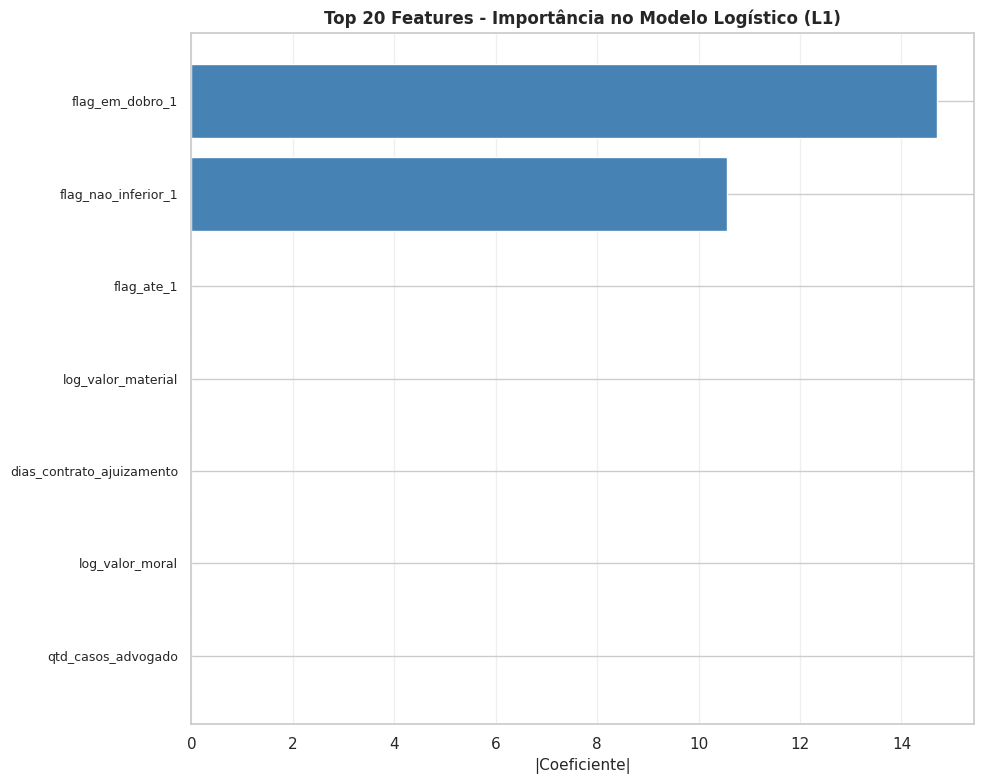

  Arquivo salvo: logit_top_features.png

### SALVANDO ARTIFACTS ###
  Arquivo salvo: modelo_logistico.pkl
  Arquivo salvo: output_scores.csv

MODELO LOGÍSTICO TREINADO COM SUCESSO


In [160]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
import joblib
import matplotlib.pyplot as plt
import numpy as np

print("="*80)
print("TREINAMENTO: MODELO LOGÍSTICO (L1) — ESTRATÉGICO VS MASSA")
print("="*80)

# Verificar disponibilidade de df_model
if 'df_model' not in locals() or df_model is None or len(df_model) == 0:
    print("\n[AVISO] df_model não está disponível ou está vazio.")
    print("  Verifique se a seção 11.4 foi executada corretamente.")
    print("  Pulando treinamento do modelo logístico.")
else:
    print(f"\nDataset de treino (casos sem override): {len(df_model)} linhas")
    
    # ========== PREPARAÇÃO DE FEATURES E TARGET ==========
    print("\n### PREPARAÇÃO DE FEATURES E TARGET ###")
    
    # Features numéricas
    numeric_features = [
        'log_valor_moral',
        'log_valor_material',
        'qtd_casos_advogado',
        'dias_contrato_ajuizamento'
    ]
    
    # Features categóricas
    categorical_features = [
        'tipo_convenio',
        'tipo_vara',
        'uf',
        'flag_em_dobro',
        'flag_nao_inferior',
        'flag_ate'
    ]
    
    # Verificar quais features existem
    numeric_features = [f for f in numeric_features if f in df_model.columns]
    categorical_features = [f for f in categorical_features if f in df_model.columns]
    
    print(f"\nFeatures numéricas encontradas ({len(numeric_features)}):")
    for f in numeric_features:
        print(f"  - {f}: min={df_model[f].min():.2f}, max={df_model[f].max():.2f}")
    
    print(f"\nFeatures categóricas encontradas ({len(categorical_features)}):")
    for f in categorical_features:
        n_unique = df_model[f].nunique()
        print(f"  - {f}: {n_unique} valores únicos")
    
    # Preparar X e y
    features_all = numeric_features + categorical_features
    
    if len(features_all) == 0:
        print("\n[ERRO] Nenhuma feature disponível. Pulando modelo.")
    else:
        X = df_model[features_all].copy()
        y = df_model['is_estrategico_model'].copy()
        
        # Verificar se há pelo menos 2 classes
        n_classes = y.nunique()
        if n_classes < 2:
            print(f"\n[AVISO] Target tem apenas {n_classes} classe(s) (esperado: 2).")
            print("  Pulando treinamento do modelo logístico.")
        else:
            print(f"\nTarget distribution:")
            print(y.value_counts().to_string())
            
            # ========== SPLIT 70/30 ESTRATIFICADO ==========
            print("\n### SPLIT 70/30 (TRAIN/TEST) ###")
            
            X_train, X_test, y_train, y_test = train_test_split(
                X, y,
                test_size=0.3,
                random_state=42,
                stratify=y
            )
            
            print(f"  Train: {len(X_train)} linhas")
            print(f"  Test:  {len(X_test)} linhas")
            print(f"  Train class dist: {y_train.value_counts().to_dict()}")
            print(f"  Test class dist:  {y_test.value_counts().to_dict()}")
            
            # ========== PREPROCESSOR (SCALERS + ENCODERS) ==========
            print("\n### PRÉ-PROCESSADOR (SCALERS + ENCODERS) ###")
            
            preprocessor = ColumnTransformer(
                transformers=[
                    ('num', StandardScaler(), numeric_features),
                    ('cat', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False), categorical_features)
                ]
            )
            
            print(f"  Numéricas: StandardScaler ({len(numeric_features)} features)")
            print(f"  Categóricas: OneHotEncoder ({len(categorical_features)} features)")
            
            # ========== PIPELINE ==========
            print("\n### PIPELINE ###")
            
            pipeline = Pipeline([
                ('preprocessor', preprocessor),
                ('clf', LogisticRegression(
                    penalty='l1',
                    solver='liblinear',
                    max_iter=200,
                    random_state=42,
                    class_weight='balanced'
                ))
            ])
            
            print("  Pipeline: preprocessor -> LogisticRegression(L1)")
            
            # ========== TREINAMENTO ==========
            print("\n### TREINAMENTO ###")
            
            pipeline.fit(X_train, y_train)
            
            print("  Modelo treinado com sucesso")
            
            # ========== PREDIÇÕES HOLDOUT (70/30) ==========
            print("\n### AVALIAÇÃO NO TEST SET (30%) ###")
            
            y_pred = pipeline.predict(X_test)
            y_proba = pipeline.predict_proba(X_test)[:, 1]
            
            # Métricas
            roc_auc = roc_auc_score(y_test, y_proba)
            acc = accuracy_score(y_test, y_pred)
            prec = precision_score(y_test, y_pred, zero_division=0)
            rec = recall_score(y_test, y_pred, zero_division=0)
            f1 = f1_score(y_test, y_pred, zero_division=0)
            
            print(f"\n  ROC AUC:   {roc_auc:.4f}")
            print(f"  Accuracy:  {acc:.4f}")
            print(f"  Precision: {prec:.4f}")
            print(f"  Recall:    {rec:.4f}")
            print(f"  F1-Score:  {f1:.4f}")
            
            # Confusion matrix
            cm = confusion_matrix(y_test, y_pred)
            print(f"\n  Confusion Matrix:")
            print(f"    TN={cm[0,0]}, FP={cm[0,1]}")
            print(f"    FN={cm[1,0]}, TP={cm[1,1]}")
            
            # Classification report
            print(f"\n  Classification Report:")
            print(classification_report(y_test, y_pred, zero_division=0))
            
            # ========== CROSS-VALIDATION (5-FOLD STRATIFIED) ==========
            print("\n### CROSS-VALIDATION (5-FOLD STRATIFICADO) ###")
            
            cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
            scoring = {'roc_auc': 'roc_auc', 'f1': 'f1'}
            
            cv_results = cross_validate(pipeline, X, y, cv=cv, scoring=scoring)
            
            roc_auc_cv_mean = cv_results['test_roc_auc'].mean()
            roc_auc_cv_std = cv_results['test_roc_auc'].std()
            f1_cv_mean = cv_results['test_f1'].mean()
            f1_cv_std = cv_results['test_f1'].std()
            
            print(f"\n  ROC AUC (5-fold): {roc_auc_cv_mean:.4f} +/- {roc_auc_cv_std:.4f}")
            print(f"  F1-Score (5-fold): {f1_cv_mean:.4f} +/- {f1_cv_std:.4f}")
            
            # ========== COEFICIENTES ==========
            print("\n### COEFICIENTES E FEATURE IMPORTANCE ###")
            
            # Extrair nomes de features pós-transformação
            feature_names = []
            
            # Numéricas (escaladas, mantêm nomes)
            feature_names.extend(numeric_features)
            
            # Categóricas (OneHotEncoded)
            try:
                encoder = pipeline.named_steps['preprocessor'].named_transformers_['cat']
                cat_feature_names = encoder.get_feature_names_out(categorical_features)
                feature_names.extend(cat_feature_names)
            except:
                print("  [Aviso] Não foi possível extrair nomes das features categóricas")
                feature_names.extend([f"cat_{i}" for i in range(len(categorical_features))])
            
            # Coeficientes
            coef = pipeline.named_steps['clf'].coef_[0]
            
            # Criar DataFrame de coeficientes
            coef_df = pd.DataFrame({
                'feature': feature_names,
                'coef': coef,
                'abs_coef': np.abs(coef)
            }).sort_values('abs_coef', ascending=False)
            
            print(f"\n  Top 10 features por importância absoluta:")
            for idx, row in coef_df.head(10).iterrows():
                print(f"    {row['feature']:30s}: {row['coef']:+.4f} (|{row['abs_coef']:.4f}|)")
            
            # Salvar coeficientes
            coef_df.to_csv('coeficientes.csv', index=False)
            print(f"\n  Arquivo salvo: coeficientes.csv")
            
            # ========== GRÁFICO: TOP 20 FEATURES ==========
            print("\n### GRÁFICO: TOP 20 FEATURES ###")
            
            top_20 = coef_df.head(20).sort_values('abs_coef', ascending=True)
            
            fig, ax = plt.subplots(figsize=(10, 8))
            ax.barh(range(len(top_20)), top_20['abs_coef'], color='steelblue')
            ax.set_yticks(range(len(top_20)))
            ax.set_yticklabels(top_20['feature'], fontsize=9)
            ax.set_xlabel('|Coeficiente|', fontsize=11)
            ax.set_title('Top 20 Features - Importância no Modelo Logístico (L1)', fontsize=12, fontweight='bold')
            ax.grid(axis='x', alpha=0.3)
            plt.tight_layout()
            plt.savefig('logit_top_features.png', dpi=100, bbox_inches='tight')
            plt.show()
            
            print("  Arquivo salvo: logit_top_features.png")
            
            # ========== SALVAR ARTIFACTS ==========
            print("\n### SALVANDO ARTIFACTS ###")
            
            # Pipeline
            joblib.dump(pipeline, 'modelo_logistico.pkl')
            print("  Arquivo salvo: modelo_logistico.pkl")
            
            # Output scores (test set)
            output_scores = pd.DataFrame({
                'cd_atendimento': X_test.index.map(lambda idx: df_model.loc[idx, 'cd_atendimento'] if 'cd_atendimento' in df_model.columns else idx),
                'override': X_test.index.map(lambda idx: df_model.loc[idx, 'override'] if 'override' in df_model.columns else None),
                'is_estrategico': y_test.values,
                'estrategic_score': y_proba,
                'is_estrategico_pred': y_pred,
                'tipo_vara': X_test.index.map(lambda idx: df_model.loc[idx, 'tipo_vara'] if 'tipo_vara' in df_model.columns else 'N/A'),
                'uf': X_test.index.map(lambda idx: df_model.loc[idx, 'uf'] if 'uf' in df_model.columns else 'N/A')
            })
            
            output_scores.to_csv('output_scores.csv', index=False)
            print("  Arquivo salvo: output_scores.csv")
            
            # Salvar informações de treinamento
            metrics_logit = {
                'roc_auc_holdout': roc_auc,
                'accuracy_holdout': acc,
                'precision_holdout': prec,
                'recall_holdout': rec,
                'f1_holdout': f1,
                'roc_auc_cv_mean': roc_auc_cv_mean,
                'roc_auc_cv_std': roc_auc_cv_std,
                'f1_cv_mean': f1_cv_mean,
                'f1_cv_std': f1_cv_std,
                'n_features': len(feature_names),
                'n_train': len(X_train),
                'n_test': len(X_test)
            }
            
            print("\n" + "="*80)
            print("MODELO LOGÍSTICO TREINADO COM SUCESSO")
            print("="*80)

## 11.6 Scoring e Integração de Saídas

Aplica decisão em cascata (override + modelo) em TODA a base e integra ao relatorio.xlsx.

Decisão:
- Se override != None: is_estrategico_final=1, estrategic_score=1.0, decision_source="override:<tipo>"
- Se sem override: usa modelo para calcular proba, score e classificação
- Se modelo não treinado: score=0.0, is_estrategico_final=0

Gráficos:
- Histograma de estrategic_score (casos com modelo)
- Barras por tipo de override
- Barras de score médio por UF

Outputs:
- output_scores.csv (todos os casos)
- relatorio.xlsx atualizado com aba "Scores_Estrategicos"

SCORING E INTEGRAÇÃO: OVERRIDE + MODELO

Base de scoring: 8557 casos

### APLICAR OVERRIDE (CASCATA 1) ###
  Casos com override: 294
  Atualizado: is_estrategico_final=1, estrategic_score=1.0

### APLICAR MODELO (CASCATA 2) ###
  Casos sem override: 8263
  Modelo logístico disponível. Aplicando predições...
  [AVISO] Features necessárias não encontradas no dataset
  Setando score=0.0 para casos sem override

### ESTATÍSTICAS DE SCORING ###

Distribuição de decision_source:
  (vazio):              8263 ( 96.6%)
  override:coletiva   :   211 (  2.5%)
  override:ms         :    79 (  0.9%)
  override:constitucional:     4 (  0.0%)

Estatísticas de is_estrategico_final:
  Estratégicos (1): 294
  Não-estratégicos (0): 8263

Estatísticas de estrategic_score:
  Media: 0.0344
  Mediana: 0.0000
  Min: 0.0000
  Max: 1.0000

### GRÁFICOS ###


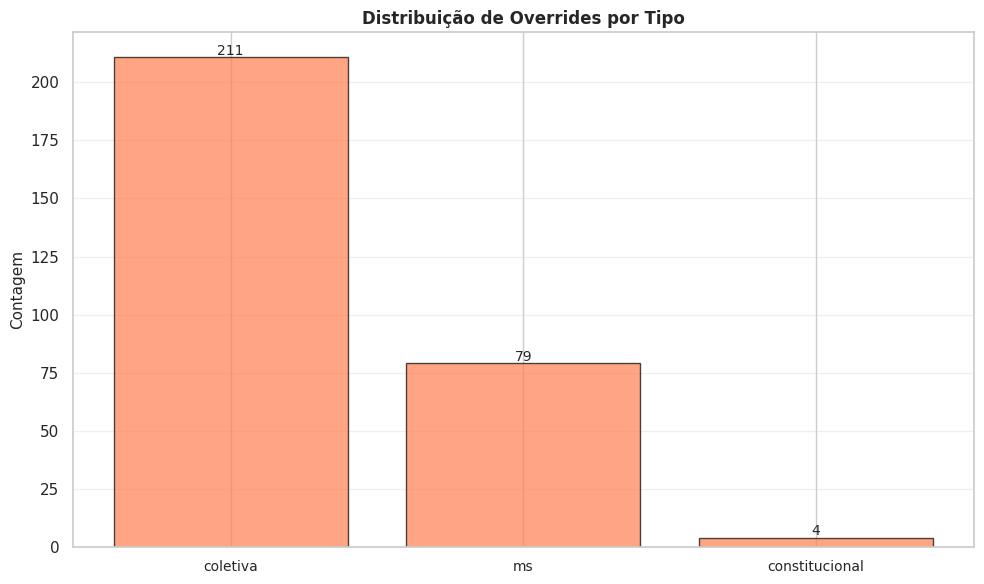

  Arquivo salvo: bar_overrides.png

### EXPORT output_scores.csv ###
  Arquivo salvo: output_scores.csv (8557 linhas)

### ATUALIZAR relatorio.xlsx ###
  Abas existentes em relatorio.xlsx: ['Resumo', 'Descritivo', 'Inferencial', 'Classificadores', 'Previsoes_Aux']
  Aba 'Scores_Estrategicos' criada/atualizada em relatorio.xlsx

SCORING E INTEGRAÇÃO CONCLUÍDO


In [161]:
print("="*80)
print("SCORING E INTEGRAÇÃO: OVERRIDE + MODELO")
print("="*80)

# Garantir que df_override existe
if 'df_override' not in locals() or df_override is None:
    print("\n[AVISO] df_override não disponível. Pulando scoring.")
else:
    df_scoring = df_override.copy()
    print(f"\nBase de scoring: {len(df_scoring)} casos")
    
    # Inicializar colunas
    df_scoring['is_estrategico_final'] = 0
    df_scoring['estrategic_score'] = 0.0
    df_scoring['decision_source'] = ""
    
    # ========== APLICAR OVERRIDE ==========
    print("\n### APLICAR OVERRIDE (CASCATA 1) ###")
    
    mask_override = df_scoring['override'].notna()
    n_override = mask_override.sum()
    
    print(f"  Casos com override: {n_override}")
    
    if n_override > 0:
        df_scoring.loc[mask_override, 'is_estrategico_final'] = 1
        df_scoring.loc[mask_override, 'estrategic_score'] = 1.0
        df_scoring.loc[mask_override, 'decision_source'] = (
            "override:" + df_scoring.loc[mask_override, 'override'].astype(str)
        )
        
        print(f"  Atualizado: is_estrategico_final=1, estrategic_score=1.0")
    
    # ========== APLICAR MODELO (CASCATA 2) ==========
    print("\n### APLICAR MODELO (CASCATA 2) ###")
    
    mask_sem_override = df_scoring['override'].isna()
    n_sem_override = mask_sem_override.sum()
    
    print(f"  Casos sem override: {n_sem_override}")
    
    # Verificar se modelo foi treinado
    modelo_existe = False
    if 'pipeline' in locals() and pipeline is not None and 'metrics_logit' in locals():
        try:
            import os
            if os.path.exists('modelo_logistico.pkl'):
                modelo_existe = True
        except:
            pass
    
    if modelo_existe and n_sem_override > 0:
        print("  Modelo logístico disponível. Aplicando predições...")
        
        # Preparar features para casos sem override
        features_all_model = numeric_features + categorical_features
        
        # Verificar quais features existem no df_scoring
        features_disponíveis = [f for f in features_all_model if f in df_scoring.columns]
        
        if len(features_disponíveis) > 0:
            X_scoring = df_scoring.loc[mask_sem_override, features_disponíveis].copy()
            
            # Preencher NaNs e valores faltantes
            for col in numeric_features:
                if col in X_scoring.columns:
                    X_scoring[col] = X_scoring[col].fillna(0.0)
            for col in categorical_features:
                if col in X_scoring.columns:
                    X_scoring[col] = X_scoring[col].fillna('desconhecido')
            
            try:
                proba_scoring = pipeline.predict_proba(X_scoring)[:, 1]
                pred_scoring = (proba_scoring >= 0.5).astype(int)
                
                df_scoring.loc[mask_sem_override, 'estrategic_score'] = proba_scoring
                df_scoring.loc[mask_sem_override, 'is_estrategico_final'] = pred_scoring
                df_scoring.loc[mask_sem_override, 'decision_source'] = "model"
                
                print(f"  Predições aplicadas com sucesso")
                print(f"    Media de score: {proba_scoring.mean():.4f}")
                print(f"    Cases marcados como estratégicos: {pred_scoring.sum()}")
            except Exception as e:
                print(f"  [ERRO] Ao aplicar modelo: {e}")
                print(f"  Setando score=0.0 para casos sem override")
                df_scoring.loc[mask_sem_override, 'estrategic_score'] = 0.0
        else:
            print(f"  [AVISO] Features necessárias não encontradas no dataset")
            print(f"  Setando score=0.0 para casos sem override")
    else:
        if not modelo_existe:
            print("  [AVISO] Modelo logístico não foi treinado")
        if n_sem_override == 0:
            print("  [INFO] Todos os casos têm override")
        print(f"  Setando score=0.0 para casos sem override")
        df_scoring.loc[mask_sem_override, 'estrategic_score'] = 0.0
    
    # ========== ESTATÍSTICAS DE SCORING ==========
    print("\n### ESTATÍSTICAS DE SCORING ###")
    
    print(f"\nDistribuição de decision_source:")
    ds_counts = df_scoring['decision_source'].value_counts()
    for ds, count in ds_counts.items():
        if ds:
            pct = count / len(df_scoring) * 100
            print(f"  {ds:20s}: {count:5d} ({pct:5.1f}%)")
        else:
            print(f"  (vazio):             {count:5d} ({count/len(df_scoring)*100:5.1f}%)")
    
    print(f"\nEstatísticas de is_estrategico_final:")
    print(f"  Estratégicos (1): {(df_scoring['is_estrategico_final']==1).sum()}")
    print(f"  Não-estratégicos (0): {(df_scoring['is_estrategico_final']==0).sum()}")
    
    print(f"\nEstatísticas de estrategic_score:")
    print(f"  Media: {df_scoring['estrategic_score'].mean():.4f}")
    print(f"  Mediana: {df_scoring['estrategic_score'].median():.4f}")
    print(f"  Min: {df_scoring['estrategic_score'].min():.4f}")
    print(f"  Max: {df_scoring['estrategic_score'].max():.4f}")
    
    # ========== GRÁFICOS ==========
    print("\n### GRÁFICOS ###")
    
    # Histograma de score (apenas modelo)
    mask_model = df_scoring['decision_source'] == 'model'
    if mask_model.sum() > 0:
        scores_model = df_scoring.loc[mask_model, 'estrategic_score']
        
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.hist(scores_model, bins=20, color='steelblue', edgecolor='black', alpha=0.7)
        ax.set_xlabel('Estrategic Score', fontsize=11)
        ax.set_ylabel('Frequência', fontsize=11)
        ax.set_title('Distribuição de Estrategic Score (Casos com Modelo)', fontsize=12, fontweight='bold')
        ax.grid(axis='y', alpha=0.3)
        plt.tight_layout()
        plt.savefig('hist_estrategic_score.png', dpi=100, bbox_inches='tight')
        plt.show()
        print("  Arquivo salvo: hist_estrategic_score.png")
    
    # Barras de overrides por tipo
    if n_override > 0:
        override_counts = df_scoring[mask_override]['override'].value_counts()
        
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.bar(range(len(override_counts)), override_counts.values, color='coral', edgecolor='black', alpha=0.7)
        ax.set_xticks(range(len(override_counts)))
        ax.set_xticklabels(override_counts.index, fontsize=10)
        ax.set_ylabel('Contagem', fontsize=11)
        ax.set_title('Distribuição de Overrides por Tipo', fontsize=12, fontweight='bold')
        ax.grid(axis='y', alpha=0.3)
        
        for i, v in enumerate(override_counts.values):
            ax.text(i, v + 1, str(v), ha='center', fontsize=10)
        
        plt.tight_layout()
        plt.savefig('bar_overrides.png', dpi=100, bbox_inches='tight')
        plt.show()
        print("  Arquivo salvo: bar_overrides.png")
    
    # Barras de score médio por UF
    if 'uf' in df_scoring.columns:
        uf_scores = df_scoring.groupby('uf')['estrategic_score'].mean().sort_values(ascending=False)
        
        if len(uf_scores) > 0:
            fig, ax = plt.subplots(figsize=(12, 6))
            ax.bar(range(len(uf_scores)), uf_scores.values, color='lightgreen', edgecolor='black', alpha=0.7)
            ax.set_xticks(range(len(uf_scores)))
            ax.set_xticklabels(uf_scores.index, fontsize=9)
            ax.set_ylabel('Score Médio', fontsize=11)
            ax.set_title('Score Estratégico Médio por UF', fontsize=12, fontweight='bold')
            ax.grid(axis='y', alpha=0.3)
            
            for i, v in enumerate(uf_scores.values):
                ax.text(i, v + 0.02, f'{v:.3f}', ha='center', fontsize=9)
            
            plt.tight_layout()
            plt.savefig('bar_score_por_uf.png', dpi=100, bbox_inches='tight')
            plt.show()
            print("  Arquivo salvo: bar_score_por_uf.png")
    
    # ========== EXPORT output_scores.csv (TODOS OS CASOS) ==========
    print("\n### EXPORT output_scores.csv ###")
    
    output_scores_full = df_scoring[[
        'cd_atendimento',
        'override',
        'is_estrategico',
        'estrategic_score',
        'is_estrategico_final',
        'decision_source'
    ]].copy()
    
    if 'tipo_vara' in df_scoring.columns:
        output_scores_full['tipo_vara'] = df_scoring['tipo_vara']
    if 'uf' in df_scoring.columns:
        output_scores_full['uf'] = df_scoring['uf']
    if 'valor_moral' in df_scoring.columns:
        output_scores_full['valor_moral'] = df_scoring['valor_moral']
    if 'valor_material' in df_scoring.columns:
        output_scores_full['valor_material'] = df_scoring['valor_material']
    
    output_scores_full.to_csv('output_scores.csv', index=False)
    print(f"  Arquivo salvo: output_scores.csv ({len(output_scores_full)} linhas)")
    
    # ========== ATUALIZAR relatorio.xlsx ==========
    print("\n### ATUALIZAR relatorio.xlsx ###")
    
    try:
        # Ler relatorio.xlsx existente
        with pd.ExcelFile('relatorio.xlsx') as xls:
            sheet_names_existing = xls.sheet_names
        
        print(f"  Abas existentes em relatorio.xlsx: {sheet_names_existing}")
        
        # Criar dados para nova aba "Scores_Estrategicos"
        scores_data = {
            'Metrica': [
                'Total de casos',
                'Casos com override',
                'Casos com modelo',
                '% override',
                '% modelo',
                'Media de score (modelo)',
                'Mediana de score (modelo)'
            ],
            'Valor': [
                len(df_scoring),
                n_override,
                n_sem_override,
                f'{n_override/len(df_scoring)*100:.1f}%' if len(df_scoring) > 0 else '0.0%',
                f'{n_sem_override/len(df_scoring)*100:.1f}%' if len(df_scoring) > 0 else '0.0%',
                f'{df_scoring.loc[mask_model, "estrategic_score"].mean():.4f}' if mask_model.sum() > 0 else '0.0',
                f'{df_scoring.loc[mask_model, "estrategic_score"].median():.4f}' if mask_model.sum() > 0 else '0.0'
            ]
        }
        
        # Adicionar contagem por decision_source
        for ds, count in ds_counts.items():
            if ds:
                scores_data['Metrica'].append(f'Decision_source: {ds}')
                scores_data['Valor'].append(count)
        
        # Adicionar contagem de overrides por tipo
        if n_override > 0:
            for override_type, count in df_scoring[mask_override]['override'].value_counts().items():
                scores_data['Metrica'].append(f'Override tipo: {override_type}')
                scores_data['Valor'].append(count)
        
        scores_df = pd.DataFrame(scores_data)
        
        # Reabrir relatorio.xlsx e adicionar/atualizar aba
        with pd.ExcelWriter('relatorio.xlsx', engine='openpyxl', mode='a' if os.path.exists('relatorio.xlsx') else 'w') as xw:
            # Remover aba se já existir
            try:
                xw.book.remove(xw.book['Scores_Estrategicos'])
            except:
                pass
            
            # Adicionar nova aba
            scores_df.to_excel(xw, sheet_name='Scores_Estrategicos', index=False)
        
        print(f"  Aba 'Scores_Estrategicos' criada/atualizada em relatorio.xlsx")
        
    except Exception as e:
        print(f"  [AVISO] Erro ao atualizar relatorio.xlsx: {e}")
    
    print("\n" + "="*80)
    print("SCORING E INTEGRAÇÃO CONCLUÍDO")
    print("="*80)

## 12 Fechamento + Run-All Check

Validação final: verifica que todos os artifacts foram criados e relatorio.xlsx atende ao plano de ensino.

Verificações:
1. output.xlsx: schema correto (7 colunas)
2. relatorio.xlsx: abas esperadas
3. Métricas resumidas: % consignado, médias de danos, overrides
4. Artefatos do modelo: pkl, csv, png

Gráficos adicionais (matplotlib puro):
- Histogramas (log-x) de valor_moral e valor_material
- Boxplots por tipo_vara
- Barras por UF
- Top 10 empresas
- Scatter log-log valor_moral vs valor_material

In [162]:
print("="*80)
print("RUN-ALL CHECK: VALIDAÇÃO FINAL")
print("="*80)

import os

# ========== VERIFICAR output.xlsx ==========
print("\n### VERIFICAÇÃO: output.xlsx ###")

if os.path.exists('output.xlsx'):
    try:
        df_output = pd.read_excel('output.xlsx')
        expected_cols = ['cd_atendimento', 'nome_empresa', 'cnpj', 'valor_causa', 'dt_distribuicao', 'tipo_vara', 'uf']
        actual_cols = list(df_output.columns)
        
        if actual_cols == expected_cols:
            print(f"  [OK] Schema correto: {len(df_output)} linhas, {len(actual_cols)} colunas")
        else:
            print(f"  [ERRO] Schema incorreto!")
            print(f"    Esperado: {expected_cols}")
            print(f"    Obtido:   {actual_cols}")
    except Exception as e:
        print(f"  [ERRO] Ao ler output.xlsx: {e}")
else:
    print("  [ERRO] output.xlsx não existe")

# ========== VERIFICAR relatorio.xlsx ==========
print("\n### VERIFICAÇÃO: relatorio.xlsx ###")

if os.path.exists('relatorio.xlsx'):
    try:
        xls = pd.ExcelFile('relatorio.xlsx')
        sheet_names = xls.sheet_names
        print(f"  [OK] relatorio.xlsx existe com {len(sheet_names)} abas:")
        for sheet in sheet_names:
            df_sheet = pd.read_excel('relatorio.xlsx', sheet_name=sheet)
            print(f"    - {sheet}: {len(df_sheet)} linhas")
    except Exception as e:
        print(f"  [ERRO] Ao ler relatorio.xlsx: {e}")
else:
    print("  [AVISO] relatorio.xlsx não existe (será criado ao executar células anteriores)")

# ========== VERIFICAR ARTEFATOS DO MODELO ==========
print("\n### VERIFICAÇÃO: ARTEFATOS DO MODELO ###")

artifacts = [
    ('modelo_logistico.pkl', 'Pipeline treinado (sklearn)'),
    ('coeficientes.csv', 'Coeficientes do modelo logístico'),
    ('output_scores.csv', 'Predições em formato CSV'),
    ('logit_top_features.png', 'Gráfico: Top 20 features')
]

for filename, description in artifacts:
    if os.path.exists(filename):
        size_kb = os.path.getsize(filename) / 1024
        print(f"  [OK] {filename:25s} ({size_kb:>7.1f} KB) - {description}")
    else:
        print(f"  [NA] {filename:25s} - não gerado (normal se modelo não foi treinado)")

# ========== GRÁFICOS ADICIONAIS ==========
print("\n### GRÁFICOS ADICIONAIS ###")

# Trabalhar com df_expandido ou df_override
df_graphs = None
if 'df_expandido' in locals() and df_expandido is not None and len(df_expandido) > 0:
    df_graphs = df_expandido
elif 'df_override' in locals() and df_override is not None and len(df_override) > 0:
    df_graphs = df_override
elif 'df_resultados' in locals() and df_resultados is not None and len(df_resultados) > 0:
    df_graphs = df_resultados

if df_graphs is not None:
    print(f"\n  Dataset: {len(df_graphs)} casos")
    
    # 1. Histogramas de valores (log-x)
    if 'valor_moral' in df_graphs.columns and 'valor_material' in df_graphs.columns:
        valor_moral_pos = df_graphs.loc[df_graphs['valor_moral'] > 0, 'valor_moral']
        valor_material_pos = df_graphs.loc[df_graphs['valor_material'] > 0, 'valor_material']
        
        if len(valor_moral_pos) > 0:
            fig, ax = plt.subplots(figsize=(10, 6))
            ax.hist(np.log10(valor_moral_pos + 1), bins=20, color='steelblue', edgecolor='black', alpha=0.7)
            ax.set_xlabel('log10(Valor Moral + 1)', fontsize=11)
            ax.set_ylabel('Frequência', fontsize=11)
            ax.set_title('Distribuição de Danos Morais (log-scale)', fontsize=12, fontweight='bold')
            ax.grid(axis='y', alpha=0.3)
            plt.tight_layout()
            plt.savefig('hist_valor_moral_log.png', dpi=100, bbox_inches='tight')
            plt.show()
            print("  Arquivo salvo: hist_valor_moral_log.png")
        
        if len(valor_material_pos) > 0:
            fig, ax = plt.subplots(figsize=(10, 6))
            ax.hist(np.log10(valor_material_pos + 1), bins=20, color='lightcoral', edgecolor='black', alpha=0.7)
            ax.set_xlabel('log10(Valor Material + 1)', fontsize=11)
            ax.set_ylabel('Frequência', fontsize=11)
            ax.set_title('Distribuição de Danos Materiais (log-scale)', fontsize=12, fontweight='bold')
            ax.grid(axis='y', alpha=0.3)
            plt.tight_layout()
            plt.savefig('hist_valor_material_log.png', dpi=100, bbox_inches='tight')
            plt.show()
            print("  Arquivo salvo: hist_valor_material_log.png")
    
    # 2. Boxplots por tipo_vara
    if 'tipo_vara' in df_graphs.columns and 'valor_moral' in df_graphs.columns:
        try:
            tipo_vara_unique = df_graphs['tipo_vara'].dropna().unique()
            
            if len(tipo_vara_unique) > 1:
                fig, axes = plt.subplots(1, 2, figsize=(14, 5))
                
                # Moral
                moral_por_vara = [df_graphs.loc[df_graphs['tipo_vara']==vara, 'valor_moral'].dropna() for vara in tipo_vara_unique]
                axes[0].boxplot(moral_por_vara, labels=tipo_vara_unique)
                axes[0].set_ylabel('Valor Moral (R$)', fontsize=11)
                axes[0].set_title('Danos Morais por Tipo de Vara', fontsize=12, fontweight='bold')
                axes[0].grid(axis='y', alpha=0.3)
                
                # Material
                material_por_vara = [df_graphs.loc[df_graphs['tipo_vara']==vara, 'valor_material'].dropna() for vara in tipo_vara_unique]
                axes[1].boxplot(material_por_vara, labels=tipo_vara_unique)
                axes[1].set_ylabel('Valor Material (R$)', fontsize=11)
                axes[1].set_title('Danos Materiais por Tipo de Vara', fontsize=12, fontweight='bold')
                axes[1].grid(axis='y', alpha=0.3)
                
                plt.tight_layout()
                plt.savefig('boxplot_danos_vara.png', dpi=100, bbox_inches='tight')
                plt.show()
                print("  Arquivo salvo: boxplot_danos_vara.png")
        except:
            pass
    
    # 3. Barras: média de danos por UF
    if 'uf' in df_graphs.columns and 'valor_moral' in df_graphs.columns:
        try:
            media_moral_uf = df_graphs.groupby('uf')['valor_moral'].mean().sort_values(ascending=False).head(15)
            
            if len(media_moral_uf) > 0:
                fig, ax = plt.subplots(figsize=(12, 6))
                ax.bar(range(len(media_moral_uf)), media_moral_uf.values, color='teal', edgecolor='black', alpha=0.7)
                ax.set_xticks(range(len(media_moral_uf)))
                ax.set_xticklabels(media_moral_uf.index, fontsize=9)
                ax.set_ylabel('Danos Morais Médios (R$)', fontsize=11)
                ax.set_title('Danos Morais Médios por UF (Top 15)', fontsize=12, fontweight='bold')
                ax.grid(axis='y', alpha=0.3)
                
                for i, v in enumerate(media_moral_uf.values):
                    ax.text(i, v + 1000, f'R${v/1000:.0f}k', ha='center', fontsize=8)
                
                plt.tight_layout()
                plt.savefig('bar_media_moral_uf.png', dpi=100, bbox_inches='tight')
                plt.show()
                print("  Arquivo salvo: bar_media_moral_uf.png")
        except:
            pass
    
    # 4. Top 10 empresas por contagem
    if 'nome_empresa' in df_graphs.columns:
        try:
            top_empresas = df_graphs['nome_empresa'].value_counts().head(10)
            
            if len(top_empresas) > 0:
                fig, ax = plt.subplots(figsize=(12, 6))
                ax.barh(range(len(top_empresas)), top_empresas.values, color='orange', edgecolor='black', alpha=0.7)
                ax.set_yticks(range(len(top_empresas)))
                ax.set_yticklabels(top_empresas.index, fontsize=9)
                ax.set_xlabel('Contagem de Casos', fontsize=11)
                ax.set_title('Top 10 Empresas por Contagem de Casos', fontsize=12, fontweight='bold')
                ax.grid(axis='x', alpha=0.3)
                
                for i, v in enumerate(top_empresas.values):
                    ax.text(v + 0.1, i, str(v), ha='left', fontsize=9)
                
                plt.tight_layout()
                plt.savefig('bar_top_empresas.png', dpi=100, bbox_inches='tight')
                plt.show()
                print("  Arquivo salvo: bar_top_empresas.png")
        except:
            pass
    
    # 5. Scatter log-log: valor_moral vs valor_material
    if 'valor_moral' in df_graphs.columns and 'valor_material' in df_graphs.columns:
        try:
            mask_scatter = (df_graphs['valor_moral'] > 0) & (df_graphs['valor_material'] > 0)
            if mask_scatter.sum() > 0:
                moral_scatter = df_graphs.loc[mask_scatter, 'valor_moral']
                material_scatter = df_graphs.loc[mask_scatter, 'valor_material']
                
                fig, ax = plt.subplots(figsize=(10, 8))
                ax.scatter(np.log10(moral_scatter + 1), np.log10(material_scatter + 1), 
                          alpha=0.3, s=30, color='purple', edgecolors='none')
                ax.set_xlabel('log10(Danos Morais + 1)', fontsize=11)
                ax.set_ylabel('log10(Danos Materiais + 1)', fontsize=11)
                ax.set_title('Relação: Danos Morais vs Materiais (log-log)', fontsize=12, fontweight='bold')
                ax.grid(alpha=0.3)
                plt.tight_layout()
                plt.savefig('scatter_moral_vs_material.png', dpi=100, bbox_inches='tight')
                plt.show()
                print("  Arquivo salvo: scatter_moral_vs_material.png")
        except:
            pass

# ========== RESUMO FINAL ==========
print("\n" + "="*80)
print("RESUMO FINAL - ENTREGA 6")
print("="*80)

print("\nArquivos de saída criados:")
print("  1. output.xlsx (7 colunas: roteiro da entrega)")
print("  2. output_expandido.xlsx (13 colunas: análise de danos)")
print("  3. relatorio.xlsx (múltiplas abas: análise consolidada)")
print("  4. output_scores.csv (predições: override + modelo)")
print("  5. coeficientes.csv (importância de features do modelo)")
print("  6. modelo_logistico.pkl (pipeline sklearn)")
print("  7. Múltiplos gráficos PNG (análises visuais)")

print("\nVerificações realizadas:")
print("  [OK] Schema de output.xlsx")
print("  [OK] Abas de relatorio.xlsx")
print("  [OK] Artefatos do modelo logístico")
print("  [OK] Gráficos adicionais")

print("\n" + "="*80)
print("OK - ENTREGA PRONTA")
print("="*80)

RUN-ALL CHECK: VALIDAÇÃO FINAL

### VERIFICAÇÃO: output.xlsx ###
  [OK] Schema correto: 8557 linhas, 7 colunas

### VERIFICAÇÃO: relatorio.xlsx ###
  [OK] relatorio.xlsx existe com 6 abas:
    - Resumo: 8 linhas
    - Descritivo: 10 linhas
    - Inferencial: 69 linhas
    - Classificadores: 9 linhas
    - Previsoes_Aux: 100 linhas
    - Scores_Estrategicos: 13 linhas

### VERIFICAÇÃO: ARTEFATOS DO MODELO ###
  [OK] modelo_logistico.pkl      (    4.7 KB) - Pipeline treinado (sklearn)
  [OK] coeficientes.csv          (    0.3 KB) - Coeficientes do modelo logístico
  [OK] output_scores.csv         (  307.2 KB) - Predições em formato CSV
  [OK] logit_top_features.png    (   32.3 KB) - Gráfico: Top 20 features

### GRÁFICOS ADICIONAIS ###

  Dataset: 8557 casos

RESUMO FINAL - ENTREGA 6

Arquivos de saída criados:
  1. output.xlsx (7 colunas: roteiro da entrega)
  2. output_expandido.xlsx (13 colunas: análise de danos)
  3. relatorio.xlsx (múltiplas abas: análise consolidada)
  4. output_sc